# PALSEA Paleo sea-level spatio-temporal hierarchical modelling workshop (11-12 June 2024)

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

### Workshop overview

#### Day 1
- Analysis choice 
- A taste of various process level models 
- Temporal Gaussian Process basics


#### Day 2
- Considering temporal uncertainty
- Spatiotemporal Gaussian Process -  basics
- Spatiotemporal Gaussian Process - kernel design and decomposition
- Spatiotemporal Gaussian Process - interaction with physics based models
- Spatiotemporal Gaussian Process - example application (Kopp et al., 2016)


In [ ]:
# Installs the necessary pyro-ppl package as well as mounts the tutorial directory into google colab from drive so users can access the data directory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Install pyro-ppl
    !pip install pyro-ppl cartopy

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Change directory
    %cd /content/drive/MyDrive/PaleoSTeHM/Tutorials/5. PALSEA workshop
else:
    # Continue to the next cell
    pass

## Day 1


In [298]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import sys
from scipy import interpolate

sys.path.append('../..')
import PSTHM 
import time

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

### 1. Analysis choice

In this section, we will try to fit a temporally linear model to salt marsh sea-level data from Norhtern North Carolina by [Kemp et al., 2011](https://www.pnas.org/doi/abs/10.1073/pnas.1015619108):

$$
y_{i} = \beta t_{i} +\alpha + \epsilon_{i}\\
\epsilon_{i} \sim N(0,\sigma_{\epsilon_{i}})\\
\overline{t}_{i} = t_{i} + \delta{i}\\
\delta_{i} \sim N(0,\sigma_{\delta_{i}})
$$
where a and b are objective parameters for optimization, $\epsilon_{i}$ indicates RSL vertical reconstruction uncertainty and $\delta{i}$ denotes geochronological uncertainties. 


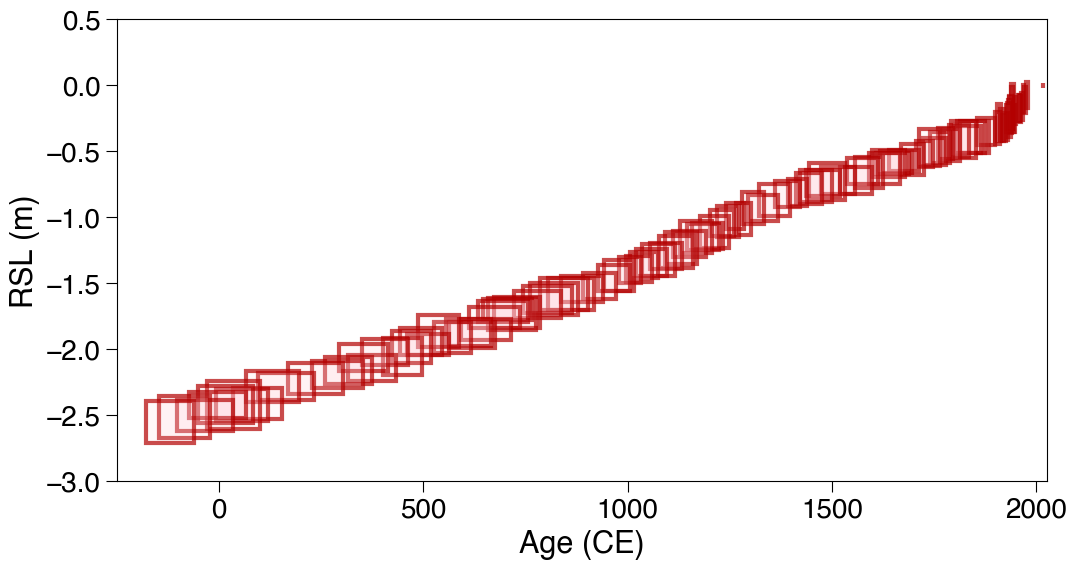

In [2]:

#load data 
NNC_X,NNC_y,NNC_y_sigma,NNC_x_sigma,NNC_lon,NNC_lat = PSTHM.load.load_local_rsl_data('../../Data/NNC_CC.csv')

#visualize data
ax = PSTHM.plotting.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2,CE=True)
ax.set_xlim(-250,2025)
ax.set_ylim(-3,0.5)
plt.show();

**Define a temporal linear model**

In [3]:
#------Define process model------
#note this is the same linear model as in PSTHM.model but without x uncertainty

def linear_model(X, y,y_sigma,intercept_prior,coefficient_prior):
    '''
    A function to define a linear model in pyro 

    ------------Inputs--------------
    X: 2D torch tensor with shape (n_samples,n_features)
    y: 1D torch tensor with shape (n_samples)
    x_sigma: float, standard deviation of the error for age, which is obtained from the age data model
    y_sigma: float, standard deviation of the error for the RSL, which is obtained from the RSL datamodel
    intercept_prior: pyro distribution for the intercept coefficient
    coefficient_prior: pyro distribution for the slope coefficient

    '''
    # Define our intercept prior
    
    alpha = pyro.sample("alpha", intercept_prior)
    #Define our coefficient prior
    
    beta_coef = pyro.sample("beta", coefficient_prior)
    #generate random error for age

    
    #calculate mean prediction
    mean = alpha + ( X * beta_coef)
    with pyro.plate("data", y.shape[0]):        
        # Condition the expected mean on the observed target y
        #define data level model
        observation = pyro.sample("obs", dist.Normal(mean, y_sigma), obs=y)

**Sampling posterior distribution of parameters with no-u-turn sampler**

In [4]:
from pyro.infer import MCMC, NUTS 
torch.manual_seed(30)

st = time.time() 

pyro.clear_param_store()
#------Define the process mdoel---------
model = linear_model
#-------Define parameter model---------
#you can change the prior distribution here to see how it affects the model!
intercept_prior = dist.Uniform(-5., 0.)
coefficient_prior = dist.Uniform(-0.01,0.01)
#-------Run MCMC---------

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=6000, warmup_steps=500)
mcmc.run(NNC_X,NNC_y,NNC_y_sigma,intercept_prior,coefficient_prior)

#--------get posterior samples----------
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}
for name, value in hmc_samples.items():
    print('-----{}: {:4.7f} +/-  {:4.7f} (2sd)-----'.format(name,value.mean(),2*value.std()))
    print('Gelman-Rubin statistic for {}: {:4.2f}'.format(name,mcmc.diagnostics()[name]['r_hat'].item()))
    print('Effective sample size for {}: {:4.2f}'.format(name,mcmc.diagnostics()[name]['n_eff'].item()))

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

Warmup:   0%|          | 0/6500 [00:00, ?it/s]

Sample: 100%|██████████| 6500/6500 [00:27, 236.67it/s, step size=1.20e-01, acc. prob=0.920]


-----alpha: -2.5763923 +/-  0.0213706 (2sd)-----
Gelman-Rubin statistic for alpha: 1.00
Effective sample size for alpha: 1324.10
-----beta: 0.0012348 +/-  0.0000141 (2sd)-----
Gelman-Rubin statistic for beta: 1.00
Effective sample size for beta: 1450.29
Execution time: 27.617 s


After several minutes of computation, we now have the posterior distributions of two hyperparameters for the RBF kernel. It should be noted that, when working with any MCMC based approach, we should check two metrics to ensure the MCMC results are ready for further analysis: (1) convergence status; (2) effective sample size.

`1. Convergence:` For MCMC, t is crucial to ensure that the Markov Chains have reached the stationary stage, indicating a good convergence stage and it can accurately represent the posterior distribution. One commonly used approach for assessing convergence is the Gelman-Rubin statistic. This statistical measure analyzes the differences between multiple Markov chains to evaluate convergence. 

The Gelman-Rubin statistic assesses convergence by comparing the estimated between-chains and within-chain variances for each model parameter. Typically, a Gelman-Rubin statistic of less than 1.1 indicates good convergence, denoting that the Markov Chains have adequately explored the posterior distribution. We can see our Gelman-Rubin stats are both below 1.1 above, hence, the hyperparameters aboved should be converged. 

`2. Effective sample size:` [effective sample size](https://andrewcharlesjones.github.io/journal/21-effective-sample-size.html#:~:text=The%20effective%20sample%20size%20is,and%20redundancy%20between%20the%20samples.) is a metric that measures how much information content is loss due to the correlation in the sequence. It therefore measures the information content, or effectiveness of a sample chain. Usually, an effective sample size greater than 1,000 is sufficient for stable estimates ([Bürkner, 2017](https://www.jstatsoft.org/article/view/v080i01)). 

We can see our Gelman-Rubin stats are both below 1.1 above, and the effective sample size are more than 1,000, so we are good to go! Let's check the posterior distributions of our model parameters and latent process (sea-level change). 

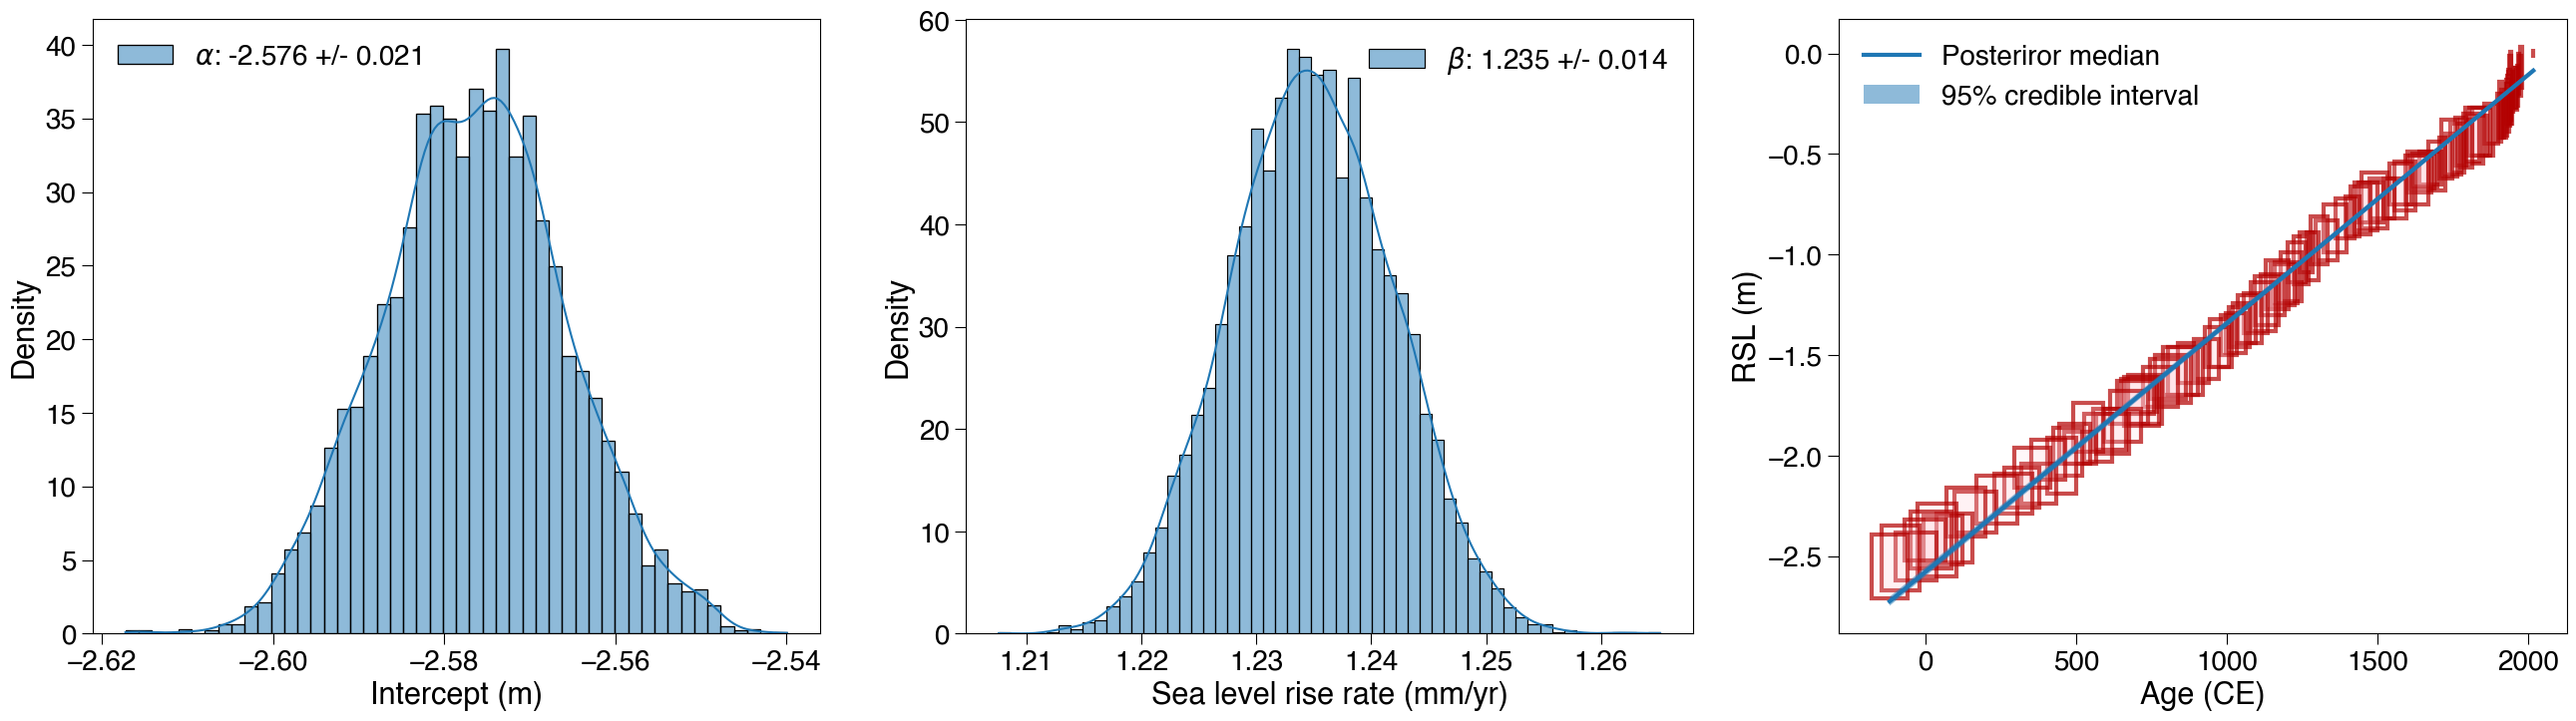

In [5]:
import seaborn as sns
#-------plot the posterior distribution---------
fig = plt.figure(figsize=(32, 8))
ax1 = plt.subplot(131)
sns.histplot(hmc_samples['alpha'], ax=ax1,label=r'$\alpha$: {:4.3f} +/- {:4.3f}'.format(hmc_samples['alpha'].mean(),2*hmc_samples['alpha'].std()),
             kde=True, stat='density')
plt.xlabel('Intercept (m)')
plt.legend()

ax2 = plt.subplot(132)
sns.histplot(hmc_samples['beta']*1000, ax=ax2,label=r'$\beta$: {:4.3f} +/- {:4.3f}'.format(hmc_samples['beta'].mean()*1000,2*hmc_samples['beta'].std()*1000),
             kde=True, stat='density')
plt.xlabel('Sea level rise rate (mm/yr)')
plt.legend()

ax3 = plt.subplot(133)
PSTHM.plotting.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2,ax=ax3,CE=True)
posterior_pred = np.zeros([len(hmc_samples['alpha']),2])
forward_x = np.array([NNC_X.min(),NNC_X.max()])
for i in range(len(hmc_samples['alpha'])):
    forward_y = hmc_samples['alpha'][i] + forward_x * hmc_samples['beta'][i]
    posterior_pred[i] = forward_y
posterior_2p5,posterior_50,posterior_97p5 = np.percentile(posterior_pred,[2.5,50,97.5],axis=0)
ax3.plot(forward_x,posterior_50,lw=3,label='Posteriror median')
ax3.fill_between(forward_x,posterior_2p5,posterior_97p5,alpha=0.5,label='95% credible interval')
plt.legend();

**Variational Bayes Methods**

A prominent problem of MCMC is the computational resources required by it, with more complicated process model and observational data, it can easily takes several days to complete. A popular way to mitigate this is [variational Bayesian methods](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), which allow us to re-write statistical inference problems (i.e. infer the value of a random variable given the value of another random variable) as optimization problems (i.e. find the parameter values that minimize some objective function). That's why we use loss function to check our model performance, instead of MCMC stats we shown above, in the last two tutorials!

In variational inference, the goal is to approximate the true posterior distribution by finding the "closest" distribution from a simpler family of distributions. In this figure below, we can see $P(Z|X)$ is the true posterior distribution we want to sample and $Q(Z)$ is a normal distribution we can easily sample from. The goal here is therefore to adjust the parameters of $Q$ parameters so that $Q(Z)$ is as close to $P$ as possible. We won't cover too much details about it here, you can check [this blog by Eric Jang](https://blog.evjang.com/2016/08/variational-bayes.html) for more details about variational method.
  
<img width=500px src="../1.Introduction/VI.png"/>

In pyro, the $Q$ distribution is referred as `guide`, which can be easily optimized to fit the posterior distribution by Stochastic Variational Inference (SVI) method, which extends variational inference by introducing [stochastic optimization techniques](https://en.wikipedia.org/wiki/Stochastic_optimization), making it more scalable and efficient for large-scale problems. Let's try it using the same linear model above, assuming model parameters $a$ and $b$ are from multivariate normal distribution:

Execution time: 2.557 s


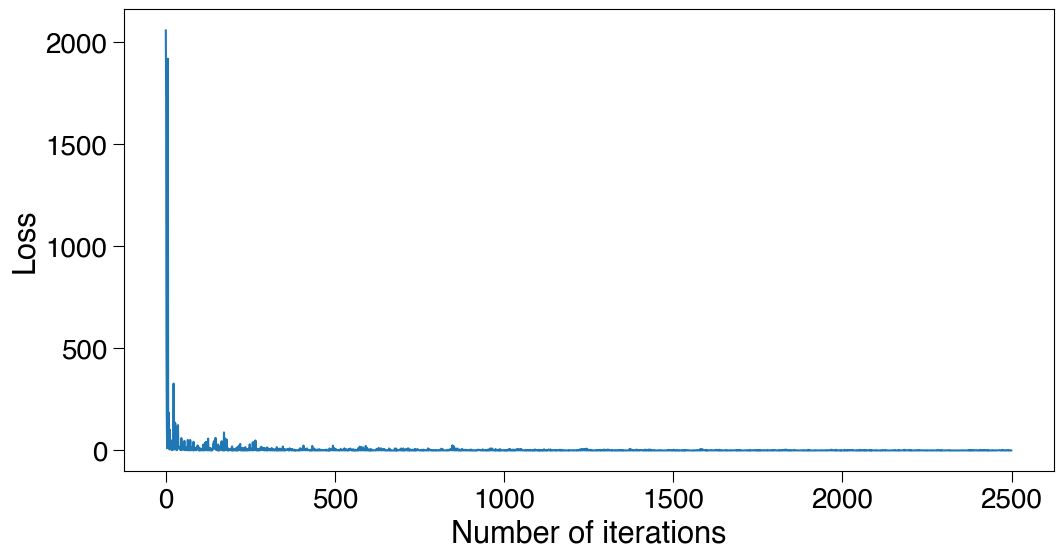

In [6]:
torch.manual_seed(30)

from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.infer import SVI, Trace_ELBO
st = time.time() 
pyro.set_rng_seed(12345)
model = linear_model
#define the guide to be multivariate normal
guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

#-------Define parameter model---------
#you can change the prior distribution here to see how it affects the model!
intercept_prior = dist.Uniform(-5., 0.)
coefficient_prior = dist.Uniform(-0.01,0.01)

#-------Train the model---------
pyro.clear_param_store()
losses = []
adam = pyro.optim.Adam({"lr":0.075})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
for j in range(2500):
    # calculate the loss and take a gradient step
    loss = svi.step(NNC_X,NNC_y,NNC_y_sigma,intercept_prior,coefficient_prior)
    losses.append(loss/len(NNC_X))

plt.plot(losses)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


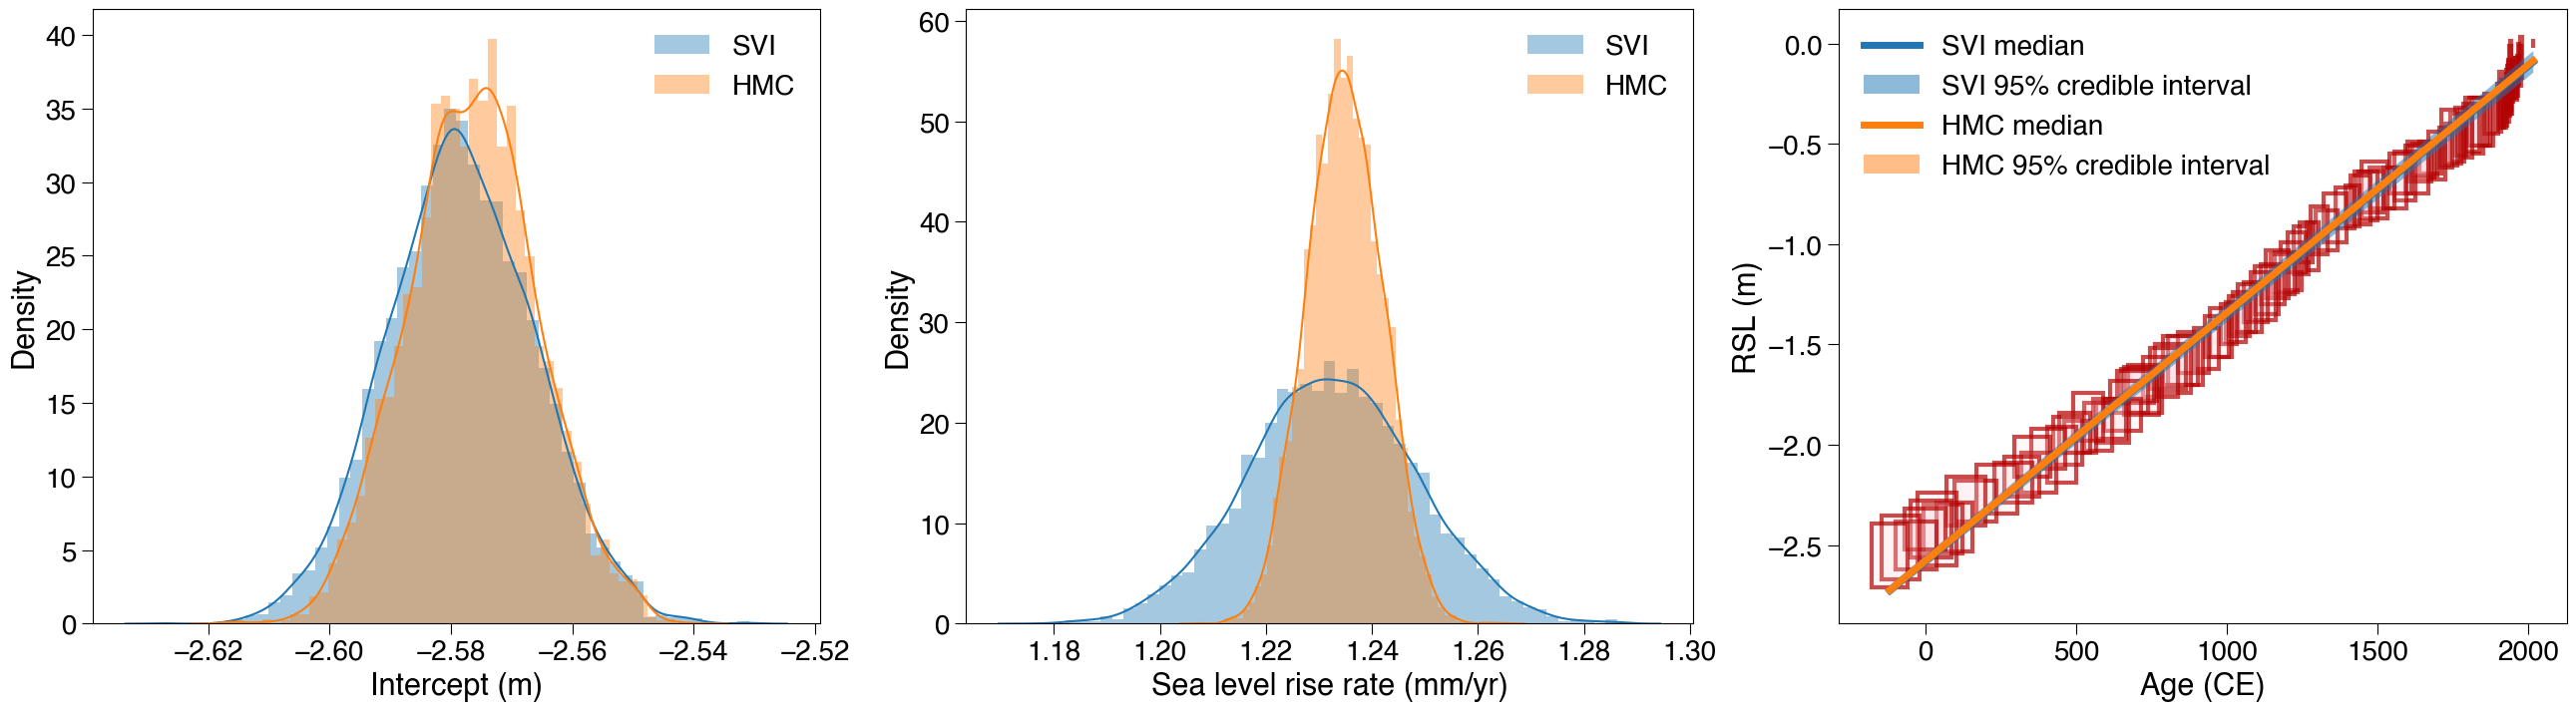

In [7]:
#-------get posterior samples---------
forward_x = np.array([NNC_X.min(),NNC_X.max()])
SVI_a,SVI_b,SVI_pred = np.zeros(7000),np.zeros(7000),np.zeros([7000,2])

for i in range(7000):
    SVI_sample = guide()
    SVI_a[i] = SVI_sample['beta'].detach().cpu().numpy()
    SVI_b[i] = SVI_sample['alpha'].detach().cpu().numpy()
    SVI_pred[i] = SVI_b[i] + forward_x * SVI_a[i]

#-------plot the posterior distribution---------
fig = plt.figure(figsize=(32, 8))
ax1 = plt.subplot(131)
sns.distplot(SVI_b, ax=ax1,label='SVI')
sns.distplot(hmc_samples['alpha'], ax=ax1,label='HMC')


plt.xlabel('Intercept (m)')
plt.legend()

ax2 = plt.subplot(132)
sns.distplot(SVI_a*1000, ax=ax2,label='SVI')
sns.distplot(hmc_samples['beta']*1000, ax=ax2,label='HMC')
plt.xlabel('Sea level rise rate (mm/yr)')
plt.legend()

ax3 = plt.subplot(133)
PSTHM.plotting.plot_uncertainty_boxes(NNC_X,NNC_y, NNC_x_sigma*2,NNC_y_sigma*2,ax=ax3,CE=True)
SVI_2p5,SVI_50,SVI_97p5 = np.percentile(SVI_pred,[2.5,50,97.5],axis=0)
plt.plot(forward_x,SVI_50,lw=5,label='SVI median')
plt.fill_between(forward_x,SVI_2p5,SVI_97p5,alpha=0.5,label='SVI 95% credible interval')
ax3.plot(forward_x,posterior_50,lw=5,label='HMC median')
ax3.fill_between(forward_x,posterior_2p5,posterior_97p5,alpha=0.5,label='HMC 95% credible interval')
plt.legend();

### 2. Process level models

The process level is hierarchical level at which the variability of sea-levle change is modeled and in some cases, decomposed based on data model. The process level reflects our understandings of sea-level change processes. For simplicity, we introduce process level for modelling temporal sea-level processes here, but it can be easily extended to a higher dimension (e.g., spatio-temporal). 

Here we will try:

- Linear model
- Change-point model
- Gaussian Process model 
- Physical model
- Gaussian Process model together with physical model

For this part, let's use a different data set from New Jersey ([Kemp et al., 2013](https://www.sciencedirect.com/science/article/abs/pii/S0277379113003740)), which contains 135 sea-level data points each with: reconstructed RSL, age, RSL reconstructeion uncertainty and age uncertainty. Let's check the data first. Note, we will now start to use PaleoSTeHM module (PSTHM), which contains python functions to load/plot data, create/optimize statistical model.  

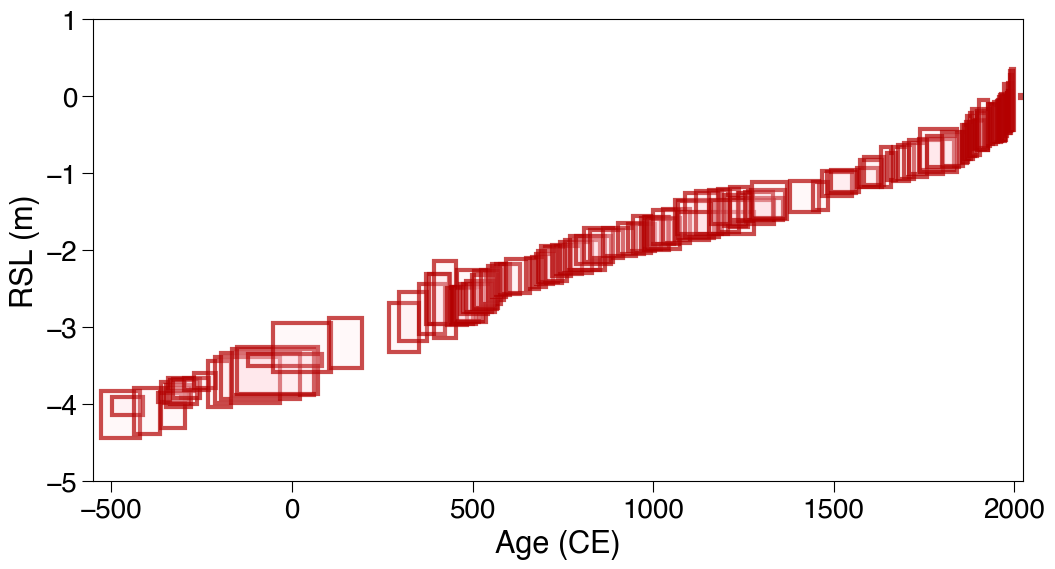

In [8]:

#load data 
X,y,y_sigma,x_sigma,lon,lat = PSTHM.load.load_local_rsl_data('../../Data/NJ_CC.csv')
X,X_index = torch.sort(X)
y = y[X_index]
y_sigma = y_sigma[X_index]
x_sigma = x_sigma[X_index]
lon = torch.tensor(lon)[X_index]
lat = torch.tensor(lat)[X_index]
#visualize data
ax = PSTHM.plotting.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,CE=True)
ax.set_xlim(-550,2025)
ax.set_ylim(-5,1)
plt.show();

**Temporally linear model**

Ok, now we have our first hierarchical model, we can now try to run it. Now we will start to use PaleoSTeHM API, which is built upon pyro, the code is fully commented, you can check the source code for more details. For every process/parameter model implementation, we will follow three general steps:

&#10148; 1. Define the process and parameter models

&#10148; 2. Optimize the parameter models based conditioned upon data model

&#10148; 3. Visulize model outputs


  0%|          | 0/1500 [00:00<?, ?it/s]

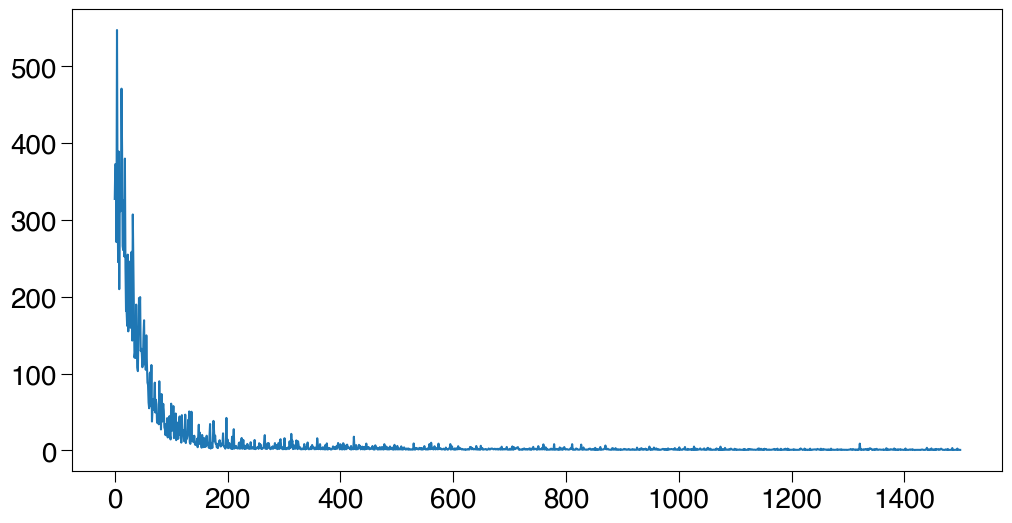

In [9]:
torch.manual_seed(1)

#------Define the process mdoel---------
linear_model = PSTHM.model.linear_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
#you can change the prior distribution here to see how it affects the model!
intercept_prior = dist.Uniform(-5., 5.)
coefficient_prior = dist.Uniform(-0.01,0.01)
#-------Optimize parameter model---------
guide,losses = PSTHM.opti.opti_pyro_model(linear_model,test_X,y,x_sigma,y_sigma,intercept_prior,coefficient_prior,lr=0.02,number_of_steps=1500)
#-------Visualize the training loss---------
plt.plot(losses);

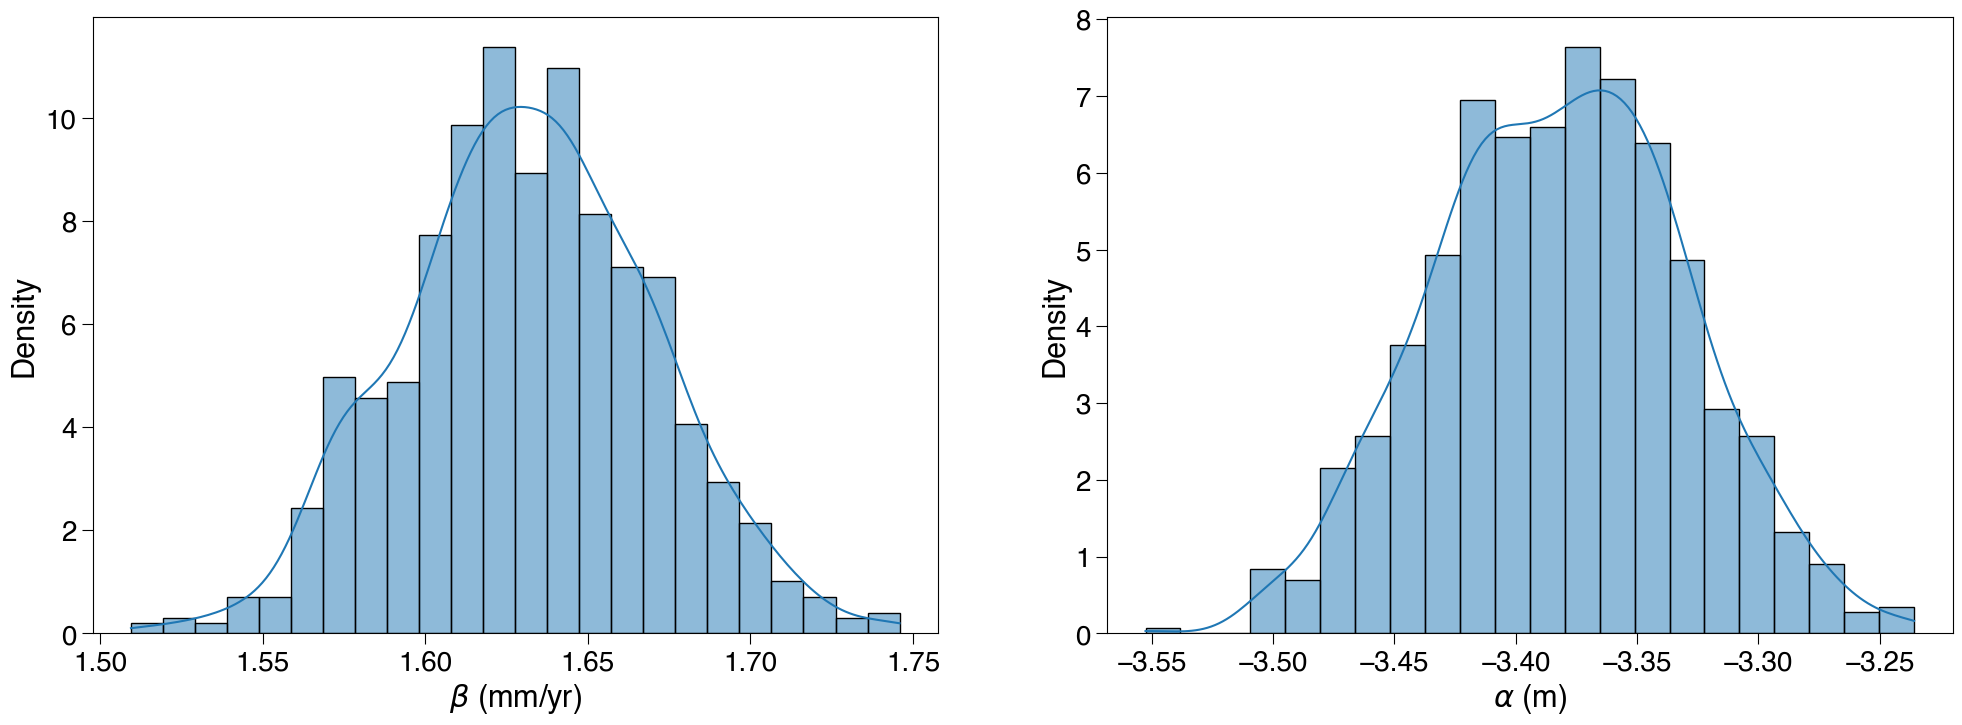

In [10]:
#-------Visualize the optimized model---------
#estimate the posterior distribution of the model parameters from optimized model 
pred_x = torch.tensor([-500,2023])
sample_number = 1000 #number of samples to draw from the posterior distribution
a_dis,b_dis,y_pred = torch.zeros(sample_number),torch.zeros(sample_number),torch.zeros(sample_number,len(pred_x))
for i in range(sample_number):
    test_b,test_a,_ = guide().values()
    y_pred[i] = pred_x*test_a + test_b
    a_dis[i] = test_a
    b_dis[i] = test_b
y_pred = y_pred.detach().numpy()
a_dis = a_dis.detach().numpy()
b_dis = b_dis.detach().numpy()

#-------Visualize the posterior distribution of the model parameters---------
plt.figure(figsize=(24,8))
plt.subplot(121)
sns.histplot(a_dis*1000,kde=True,stat='density')
plt.xlabel(r'$\beta$ (mm/yr)')
plt.subplot(122)
sns.histplot(b_dis,kde=True,stat='density')
plt.xlabel(r'$\alpha$ (m)');


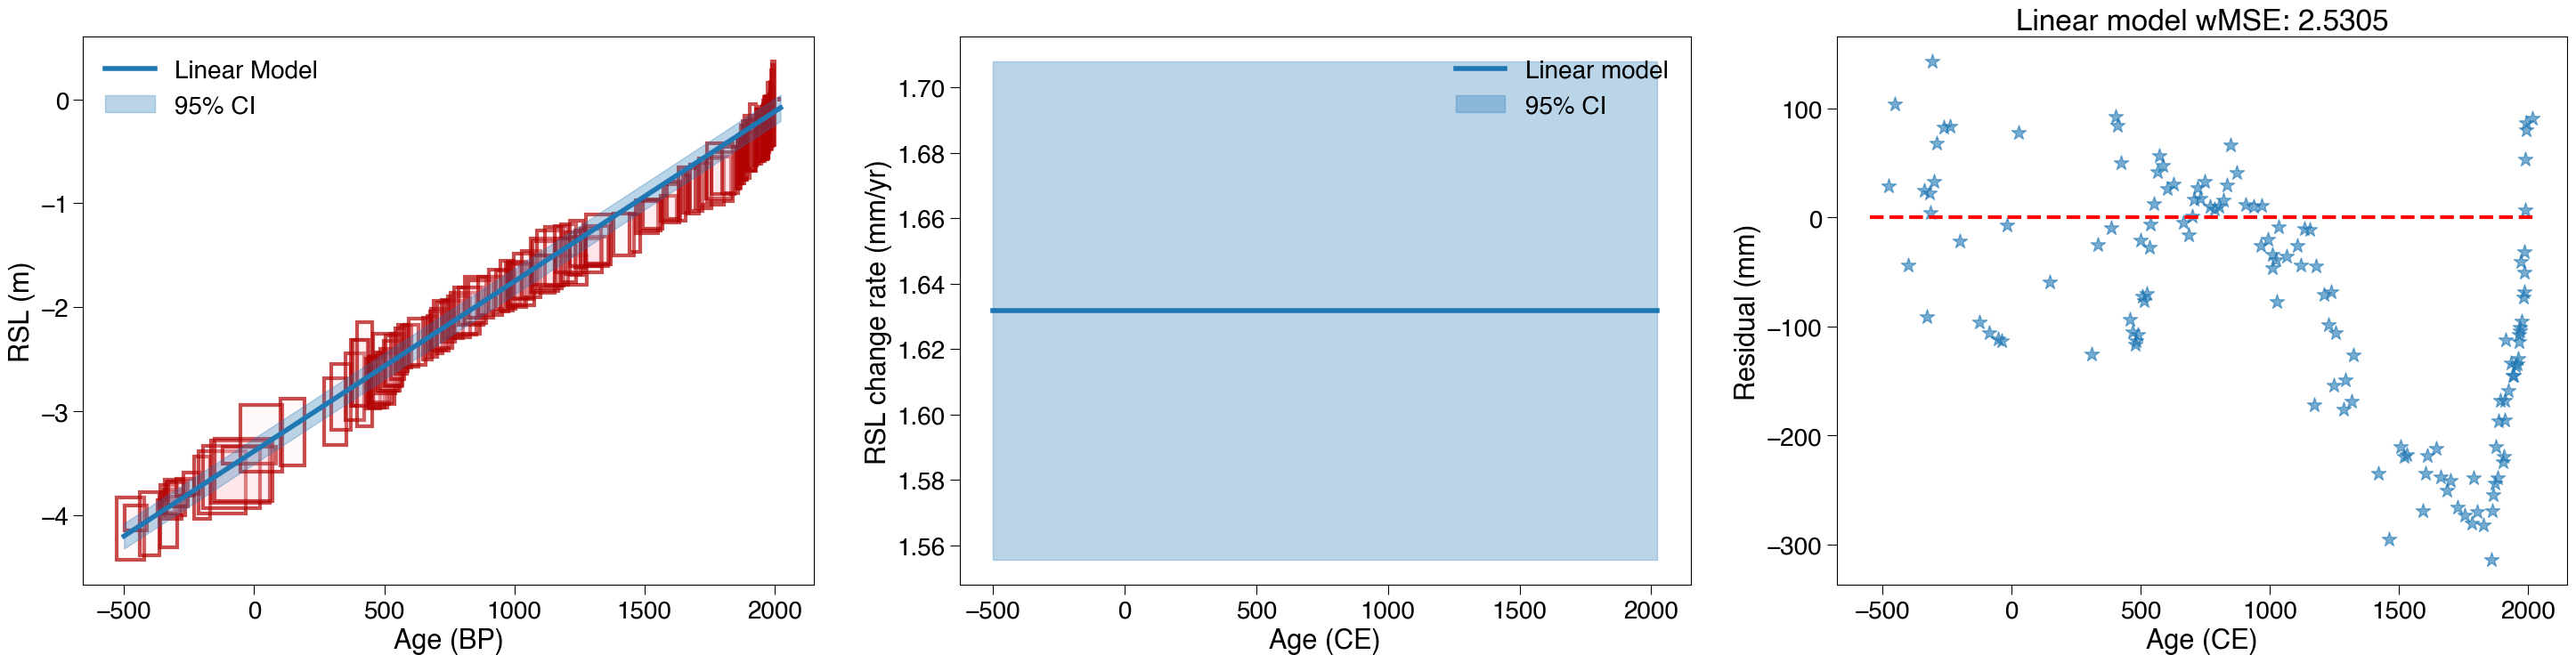

In [11]:
a_mean,a_std = np.mean(a_dis),np.std(a_dis)
b_mean,b_std = np.mean(b_dis),np.std(b_dis)
mean_pred = np.mean(y_pred,axis=0)
pred_2p5,pred_97p5 = np.percentile(y_pred,[2.5,97.5],axis=0)
#--------visualize modelled RSL, RSL change rate and model residual-----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plotting.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(pred_x,mean_pred,color='C0',linewidth=4,label='Linear Model')
plt.fill_between(pred_x,pred_2p5,pred_97p5,color='C0',alpha=0.3,label='95% CI')
# ax.set_xlim(-550,2025)
# ax.set_ylim(-5,1)
plt.legend()

ax2 = plt.subplot(132)
plt.plot(pred_x,[a_mean*1000,a_mean*1000],color='C0',linewidth=4,label='Linear model')
plt.fill_between(pred_x,(a_mean-2*a_std)*1000,(a_mean+2*a_std)*1000,color='C0',alpha=0.3,label='95% CI')
plt.ylabel('RSL change rate (mm/yr)')
plt.xlabel('Age (CE)')
plt.legend()

ax3 = plt.subplot(133)
f_linear= interpolate.interp1d(pred_x,mean_pred)
linear_prediction = f_linear(X)
plt.scatter(X,(y.detach().numpy()-linear_prediction)*1000,s=150,marker='*',color='C0',alpha=0.6)
plt.xlabel('Age (CE)')

plt.ylabel('Residual (mm)')
plt.title('Linear model wMSE: {:4.4f}'.format(PSTHM.post.cal_wMSE(y.detach().numpy(),linear_prediction,y_sigma.detach().numpy())))
plt.hlines(0,-550,2025,linestyle='--',color='r',lw=3)

plt.show()



**Change-point model**

The change-point model is a popular process model to infer time series data because it can not only infer the rate of change in different periods of time but also when the rate is chaning, a very handy property for inferring abrupt change in sea level and climate science (see examples like [Caesar et al., 2021](https://www.nature.com/articles/s41561-021-00699-z)). This change-point model we used here is based on a [change-point modelling blog](https://www.niamhcahill.com/post/cptutorial/) by Niamh Cahill.  


  0%|          | 0/2000 [00:00<?, ?it/s]

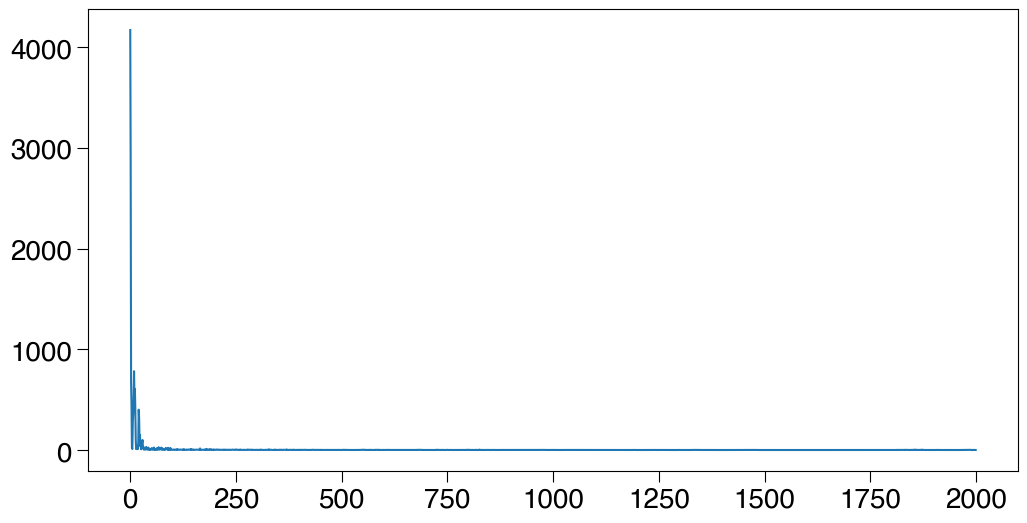

In [160]:
torch.manual_seed(1)

#------Define the process mdoel---------
change_point_model = PSTHM.model.change_point_model
test_X = X[:,None] #convert X to a 2D array which is more common for pytorch models
#-------Define parameter model---------
intercept_prior = dist.Uniform(-15., -0.)  #prior distribution for b
coefficient_prior = dist.Uniform(-0.01,0.01) #prior distribution for A

num_change_points = 3

guide,losses = PSTHM.opti.opti_pyro_model(change_point_model,test_X,y,x_sigma,y_sigma,num_change_points,intercept_prior,coefficient_prior,lr=0.1,number_of_steps=2000, step_size=20, decay_r=0.8)
#-------Visualize the training loss---------
plt.plot(losses);

#----here you can use MCMC instead of SVI to get the posterior distribution of the model parameters
# mcmc = PSTHM.opti.mcmc_pyro_model(change_point_model,[test_X,y,x_sigma,y_sigma,num_change_points,intercept_prior,coefficient_prior],
#                                   num_samples=200,warmup_steps=50,target_accept_prob=0.7)
# hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

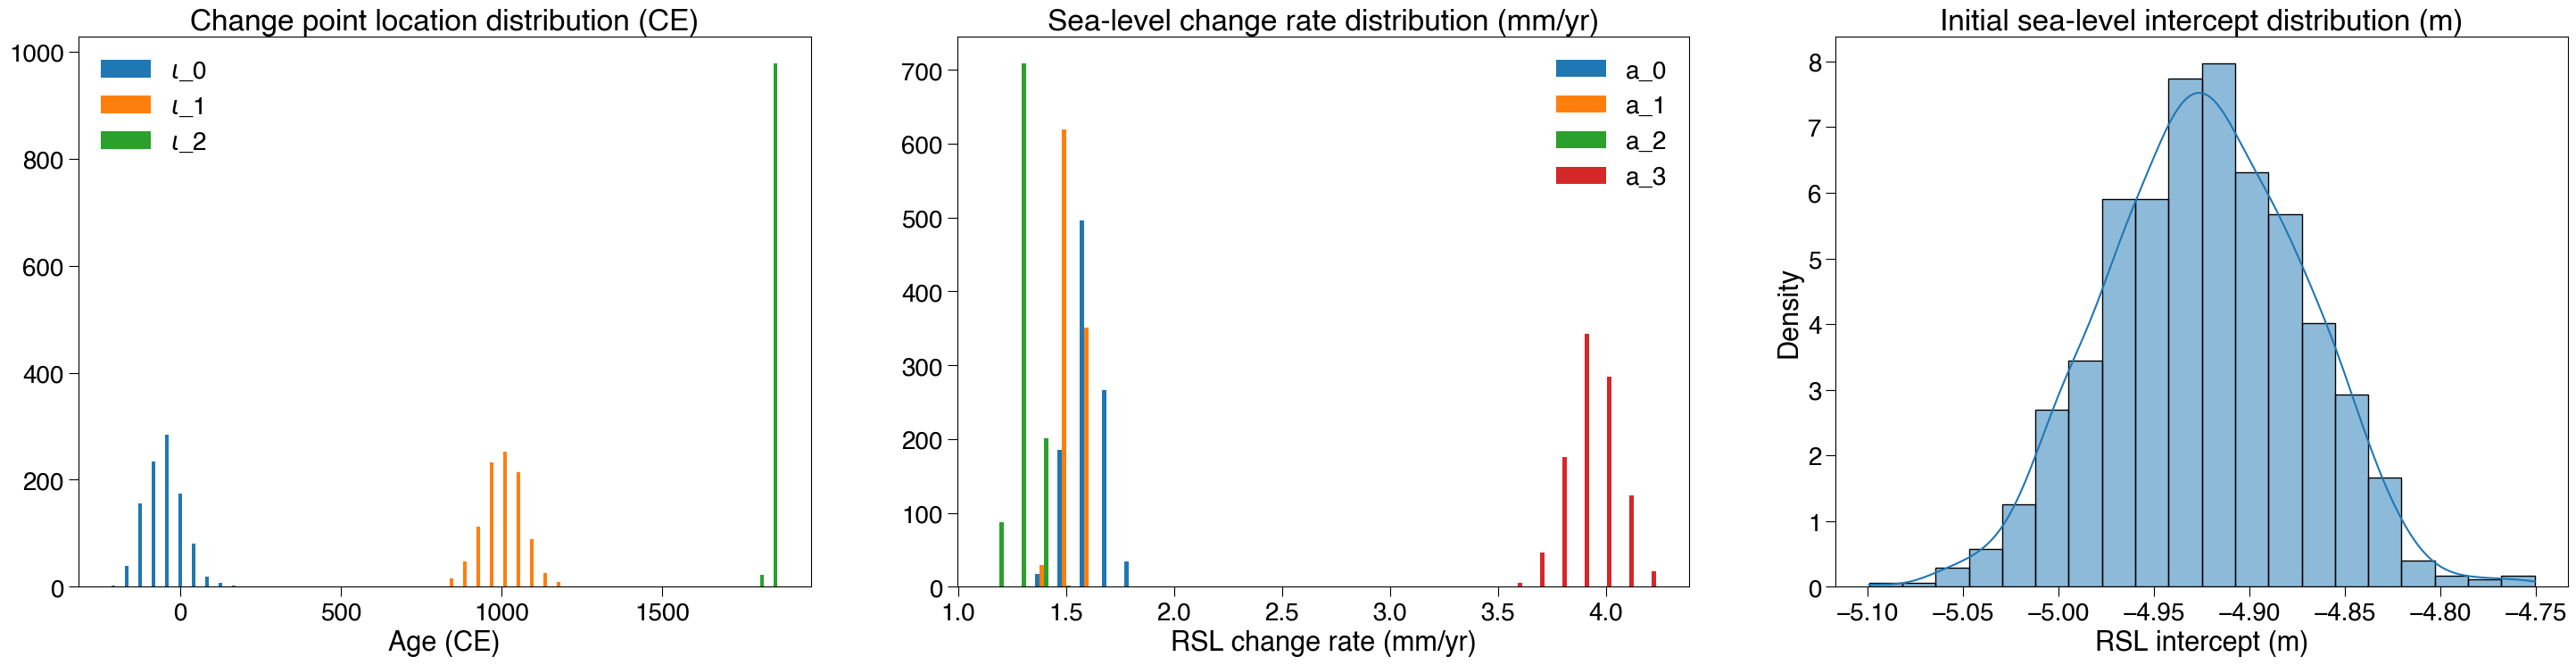

In [161]:
posterior = PSTHM.post.get_change_point_posterior(guide,1000)

plt.figure(figsize=(36,8))
plt.subplot(131)
plt.hist(posterior['cp'],bins=50,label=[f'$\iota$_{str(i)}' for i in range( posterior['cp'].shape[1])])
plt.xlabel('Age (CE)')
plt.title('Change point location distribution (CE)')
plt.legend()

plt.subplot(132)
plt.hist(posterior['a']*1000,bins=30,label=[f'a_{str(i)}' for i in range( posterior['a'].shape[1])])
plt.xlabel('RSL change rate (mm/yr)')
plt.legend()
plt.title('Sea-level change rate distribution (mm/yr)')

plt.subplot(133)
sns.histplot(posterior['b'],bins=20,kde=True,stat='density')

plt.xlabel('RSL intercept (m)')
plt.title('Initial sea-level intercept distribution (m)');

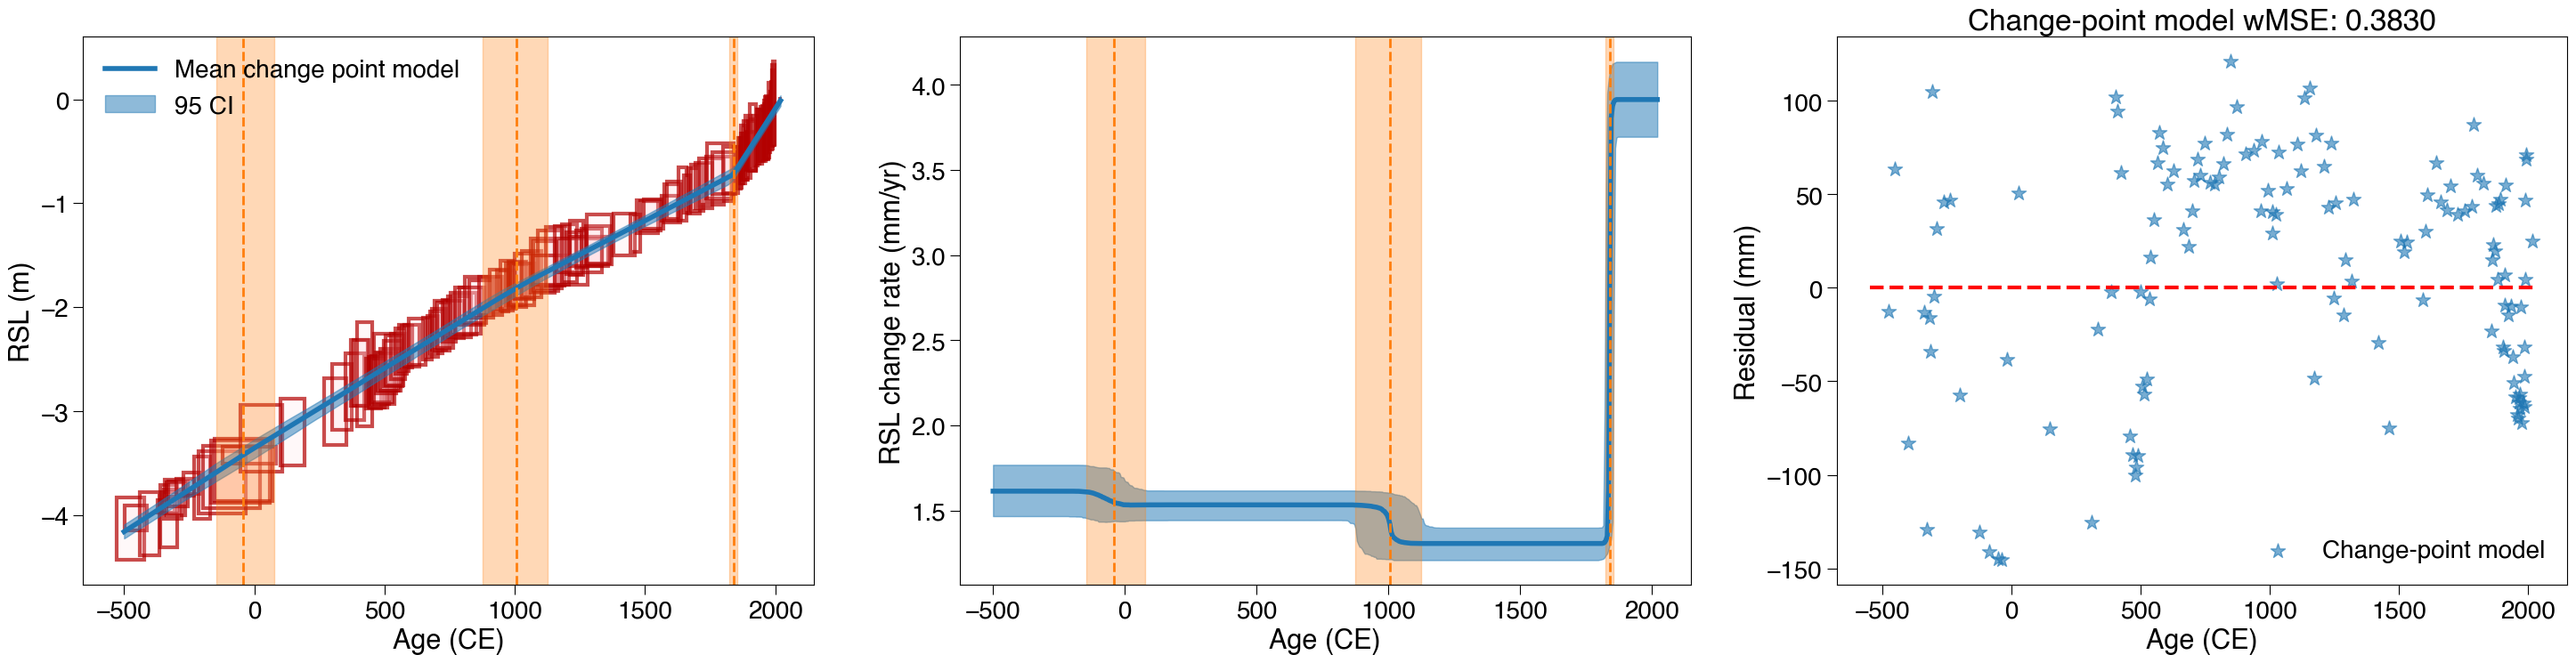

In [162]:
#-------Calculate posterior predictive and sea-level change rate-------
forward_x = torch.arange(-500,2025,5)
change_point_pred = np.zeros([1000,len(forward_x)])
change_point_pred_rate = np.zeros([1000,len(forward_x)])

for i in range(1000):
    change_point_pred[i,:] = PSTHM.post.change_point_forward(num_change_points,posterior['cp'][i],forward_x[:,None],test_X,posterior['a'][i],posterior['b'][i])
    change_point_pred_rate[i] = np.gradient(change_point_pred[i],forward_x)
change_point_pred_2p5,change_point_pred_50,change_point_pred_97p5 = np.percentile(change_point_pred,[2.5,50,97.5],axis=0)
change_point_pred_rate_2p5,change_point_pred_rate_50,change_point_pred_rate_97p5 = np.percentile(change_point_pred_rate,[2.5,50,97.5],axis=0)*1000
#------------Visualize the change point model----------------
plt.figure(figsize=(36,8))
ax = plt.subplot(131)
PSTHM.plotting.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax,CE=True)
plt.plot(forward_x,change_point_pred_50,'C0',linewidth=4,label='Mean change point model')
plt.fill_between(forward_x,change_point_pred_2p5,change_point_pred_97p5,color='C0',alpha=0.5,label='95 CI')

for i in range(posterior['cp'].shape[1]):
    cp_2p5,cp_50,cp_97p5 = np.percentile(posterior['cp'][:,i],[2.5,50,97.5])
    plt.axvline(cp_50,color='C1',linestyle='--',linewidth=2)
    plt.axvspan(cp_2p5,cp_97p5,color='C1',alpha=0.3)
plt.legend()
ax2 = plt.subplot(132)
# plot_time = [X.min(),*posterior['cp'].mean(axis=0),forward_x.max()]
# for i in range(posterior['a'].shape[1]):
#     a_2p5,a_50,a_97p5 = np.percentile(posterior['a'][:,i],[2.5,50,97.5])*1000
#     plt.plot(plot_time[i:i+2],[a_50,a_50],color='C0',linewidth=4)
#     plt.fill_between(plot_time[i:i+2],[a_2p5,a_2p5],[a_97p5,a_97p5],color='C0',alpha=0.3)
plt.plot(forward_x,change_point_pred_rate_50,'C0',linewidth=4,label='Mean change point model')
plt.fill_between(forward_x,change_point_pred_rate_2p5,change_point_pred_rate_97p5,color='C0',alpha=0.5,label='95 CI')
for i in range(posterior['cp'].shape[1]):
    cp_2p5,cp_50,cp_97p5 = np.percentile(posterior['cp'][:,i],[2.5,50,97.5])
    plt.axvline(cp_50,color='C1',linestyle='--',linewidth=2)
    plt.axvspan(cp_2p5,cp_97p5,color='C1',alpha=0.3)
plt.xlabel('Age (CE)')
plt.ylabel('RSL change rate (mm/yr)')

ax3 = plt.subplot(133)
f_cp = interpolate.interp1d(forward_x,change_point_pred_50)
cp_prediction = f_cp(X)
ax3.scatter(X,(y.detach().numpy()-cp_prediction)*1000,s=150,marker='*',color='C0',alpha=0.6,label = 'Change-point model')

plt.xlabel('Age (CE)')
plt.ylabel('Residual (mm)')
plt.legend()
plt.hlines(0,-550,2025,linestyle='--',color='r',lw=3)

plt.title('Change-point model wMSE: {:4.4f}'.format(PSTHM.post.cal_wMSE(y.detach().numpy(),cp_prediction,y_sigma.detach().numpy())));


**Gaussian Process model**

Gaussian Process (GP) is a nonparametric and Bayesian approach used to infer temporal (or spatio-temporal) variation of sea-level change, including magntiude and rate. In a GP, the relationship among any arbitrary set of points (e.g., in time, or in space and time) is a multivariate normal distribution defined by a mean vector and a covariance matrix (or kernel). Compared to using other parametric models (e.g., linear mdoel, change-point model) to infer time series, GP time-series models have much more flexibility because the shape of the curve is driven by the covariance matrix, which is estimated conditional upon the data, as opposed to a predetermined functional form. 

GP-based technique is quite popular among sea-level science, you can see it in papers like [Kopp et al., 2009](https://www.nature.com/articles/nature08686), [Khan et al., 2017](https://www.sciencedirect.com/science/article/pii/S0277379116303304?casa_token=tWT35cjkorAAAAAA:eYvTa65bm0kIdkUPZb1d7OZjGjl2itDd15FQ9qaSqUmVNssKTVOetOir1OWV62qleehmIw8kUQ), [Walker et al., 2022](https://www.nature.com/articles/s41467-022-28564-6) etc...

Here we just give you a bit taste of what GP can do for this time series analysis, more will come in the next section. 

The GP model we use here is a GP model with zero mean function with an RBF kernel.

  0%|          | 0/500 [00:00<?, ?it/s]

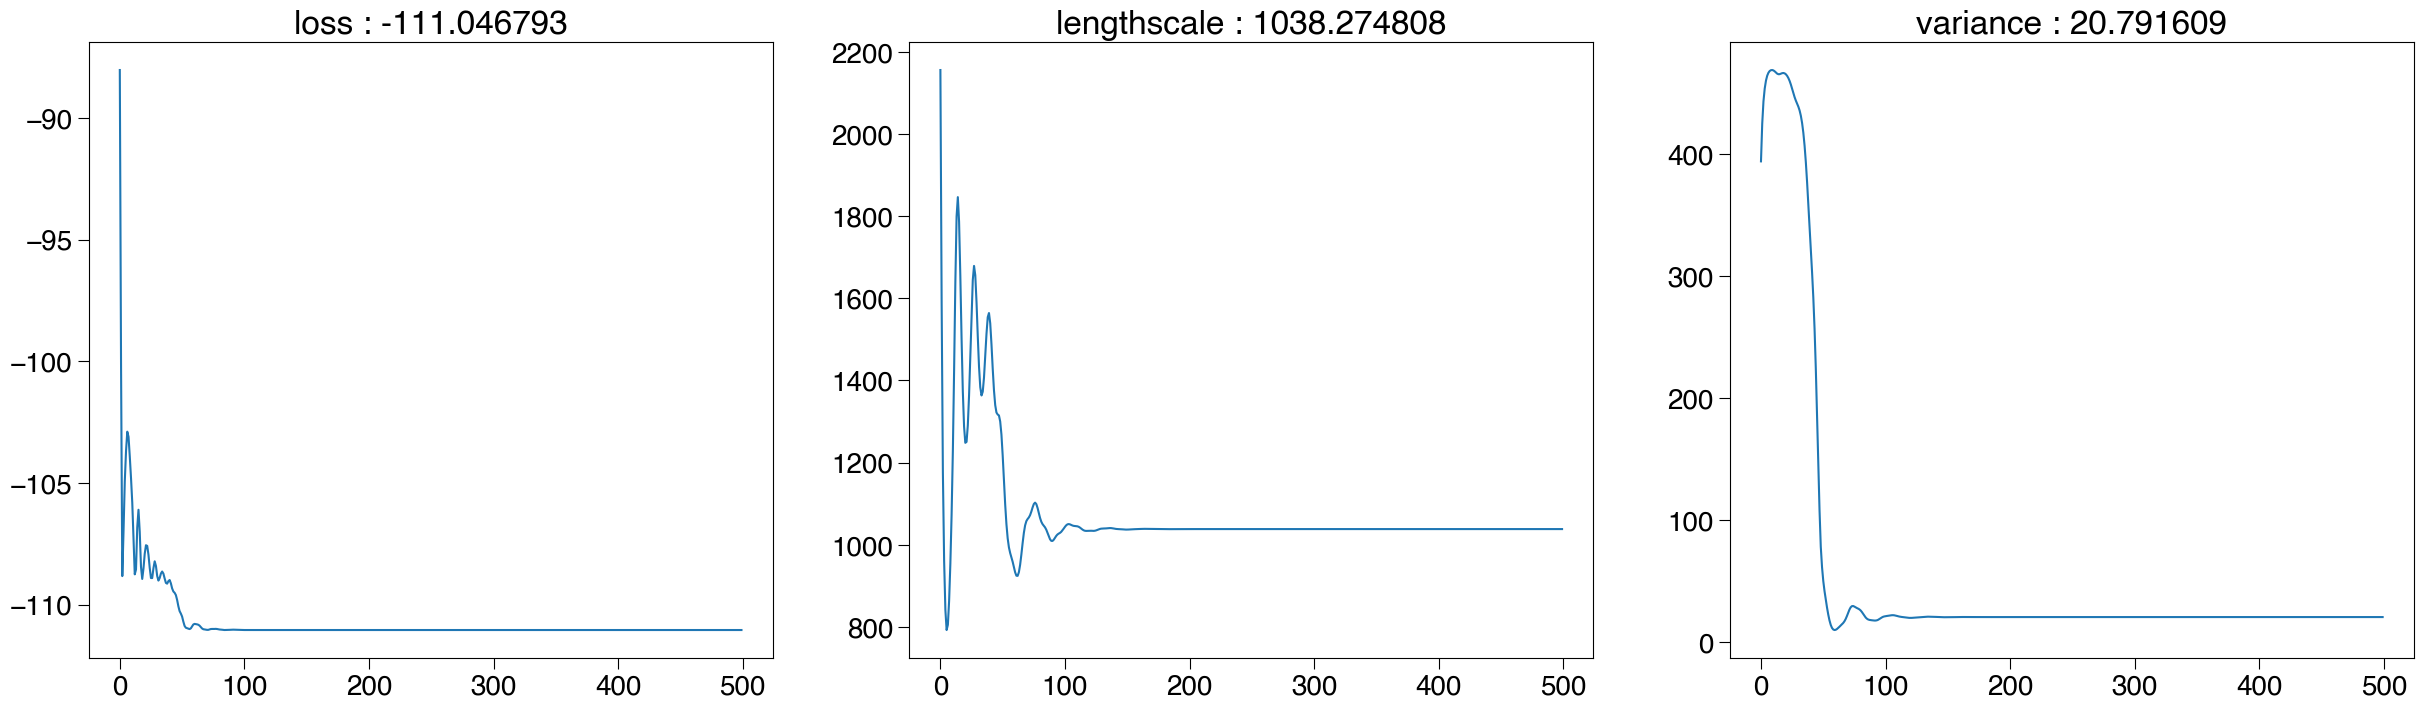

In [163]:

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = PSTHM.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(500.))
#set prior distribution for kernels
RBF_kernel.set_prior("variance", dist.Uniform(torch.tensor(1.), torch.tensor(500.)))
# uncomment this for variational bayes optimization with normal variational distribution
# RBF_kernel.autoguide("variance",dist.Normal) 
RBF_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(5000.)))
# RBF_kernel.autoguide("lengthscale",dist.Normal)

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(X, y, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_NI_optm(gpr,x_sigma,num_iteration=500,lr=0.5,decay_r = 0.8,step_size=50)

axes = PSTHM.plotting.plot_track_list(track_list);

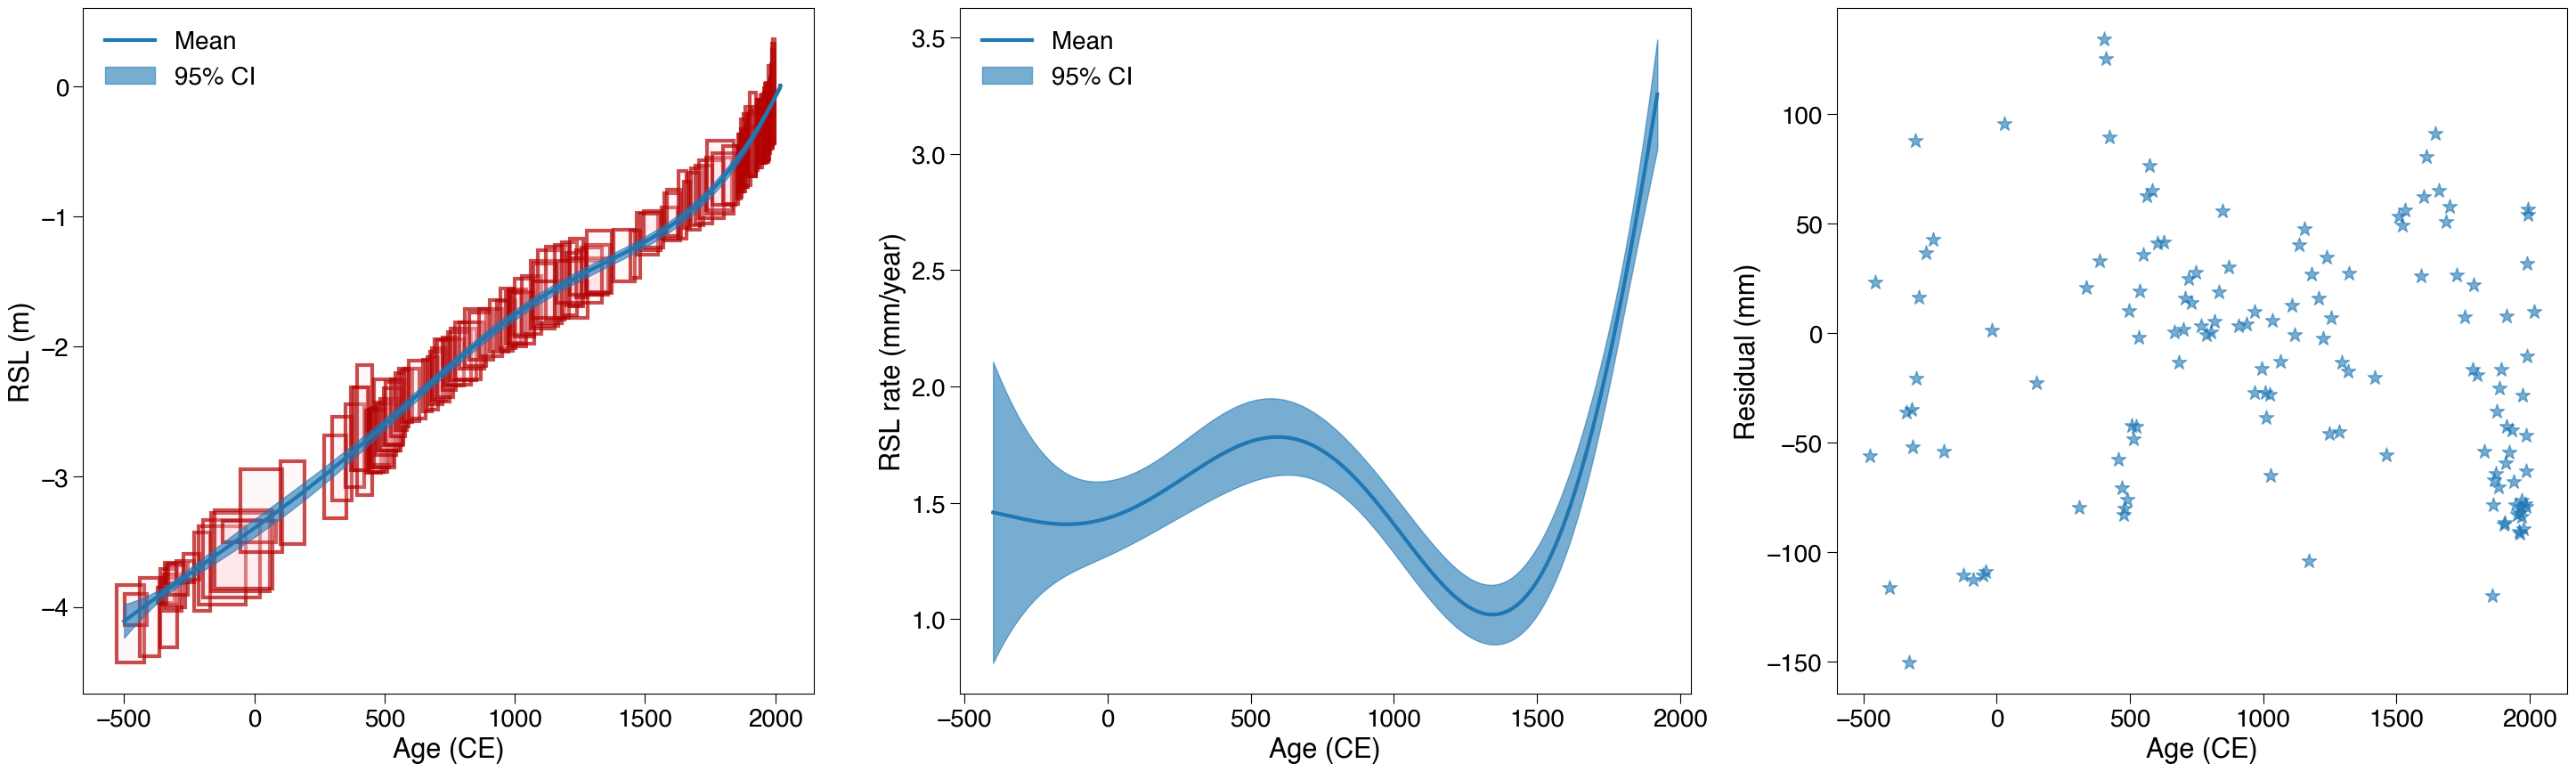

In [164]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5)
c_kernel_y_mean, c_kernel_y_var = gpr(x_test.double(), full_cov=True)
c_kernel_sd = torch.diag(c_kernel_y_var).sqrt()  # standard deviation at each input point x
rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),c_kernel_y_var.detach().numpy(),c_kernel_y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,c_kernel_y_mean,c_kernel_sd,
                          rsl_time,c_kernel_rsl_rate,c_kernel_rsl_rate_sd)

**Comparing three differenct methods**

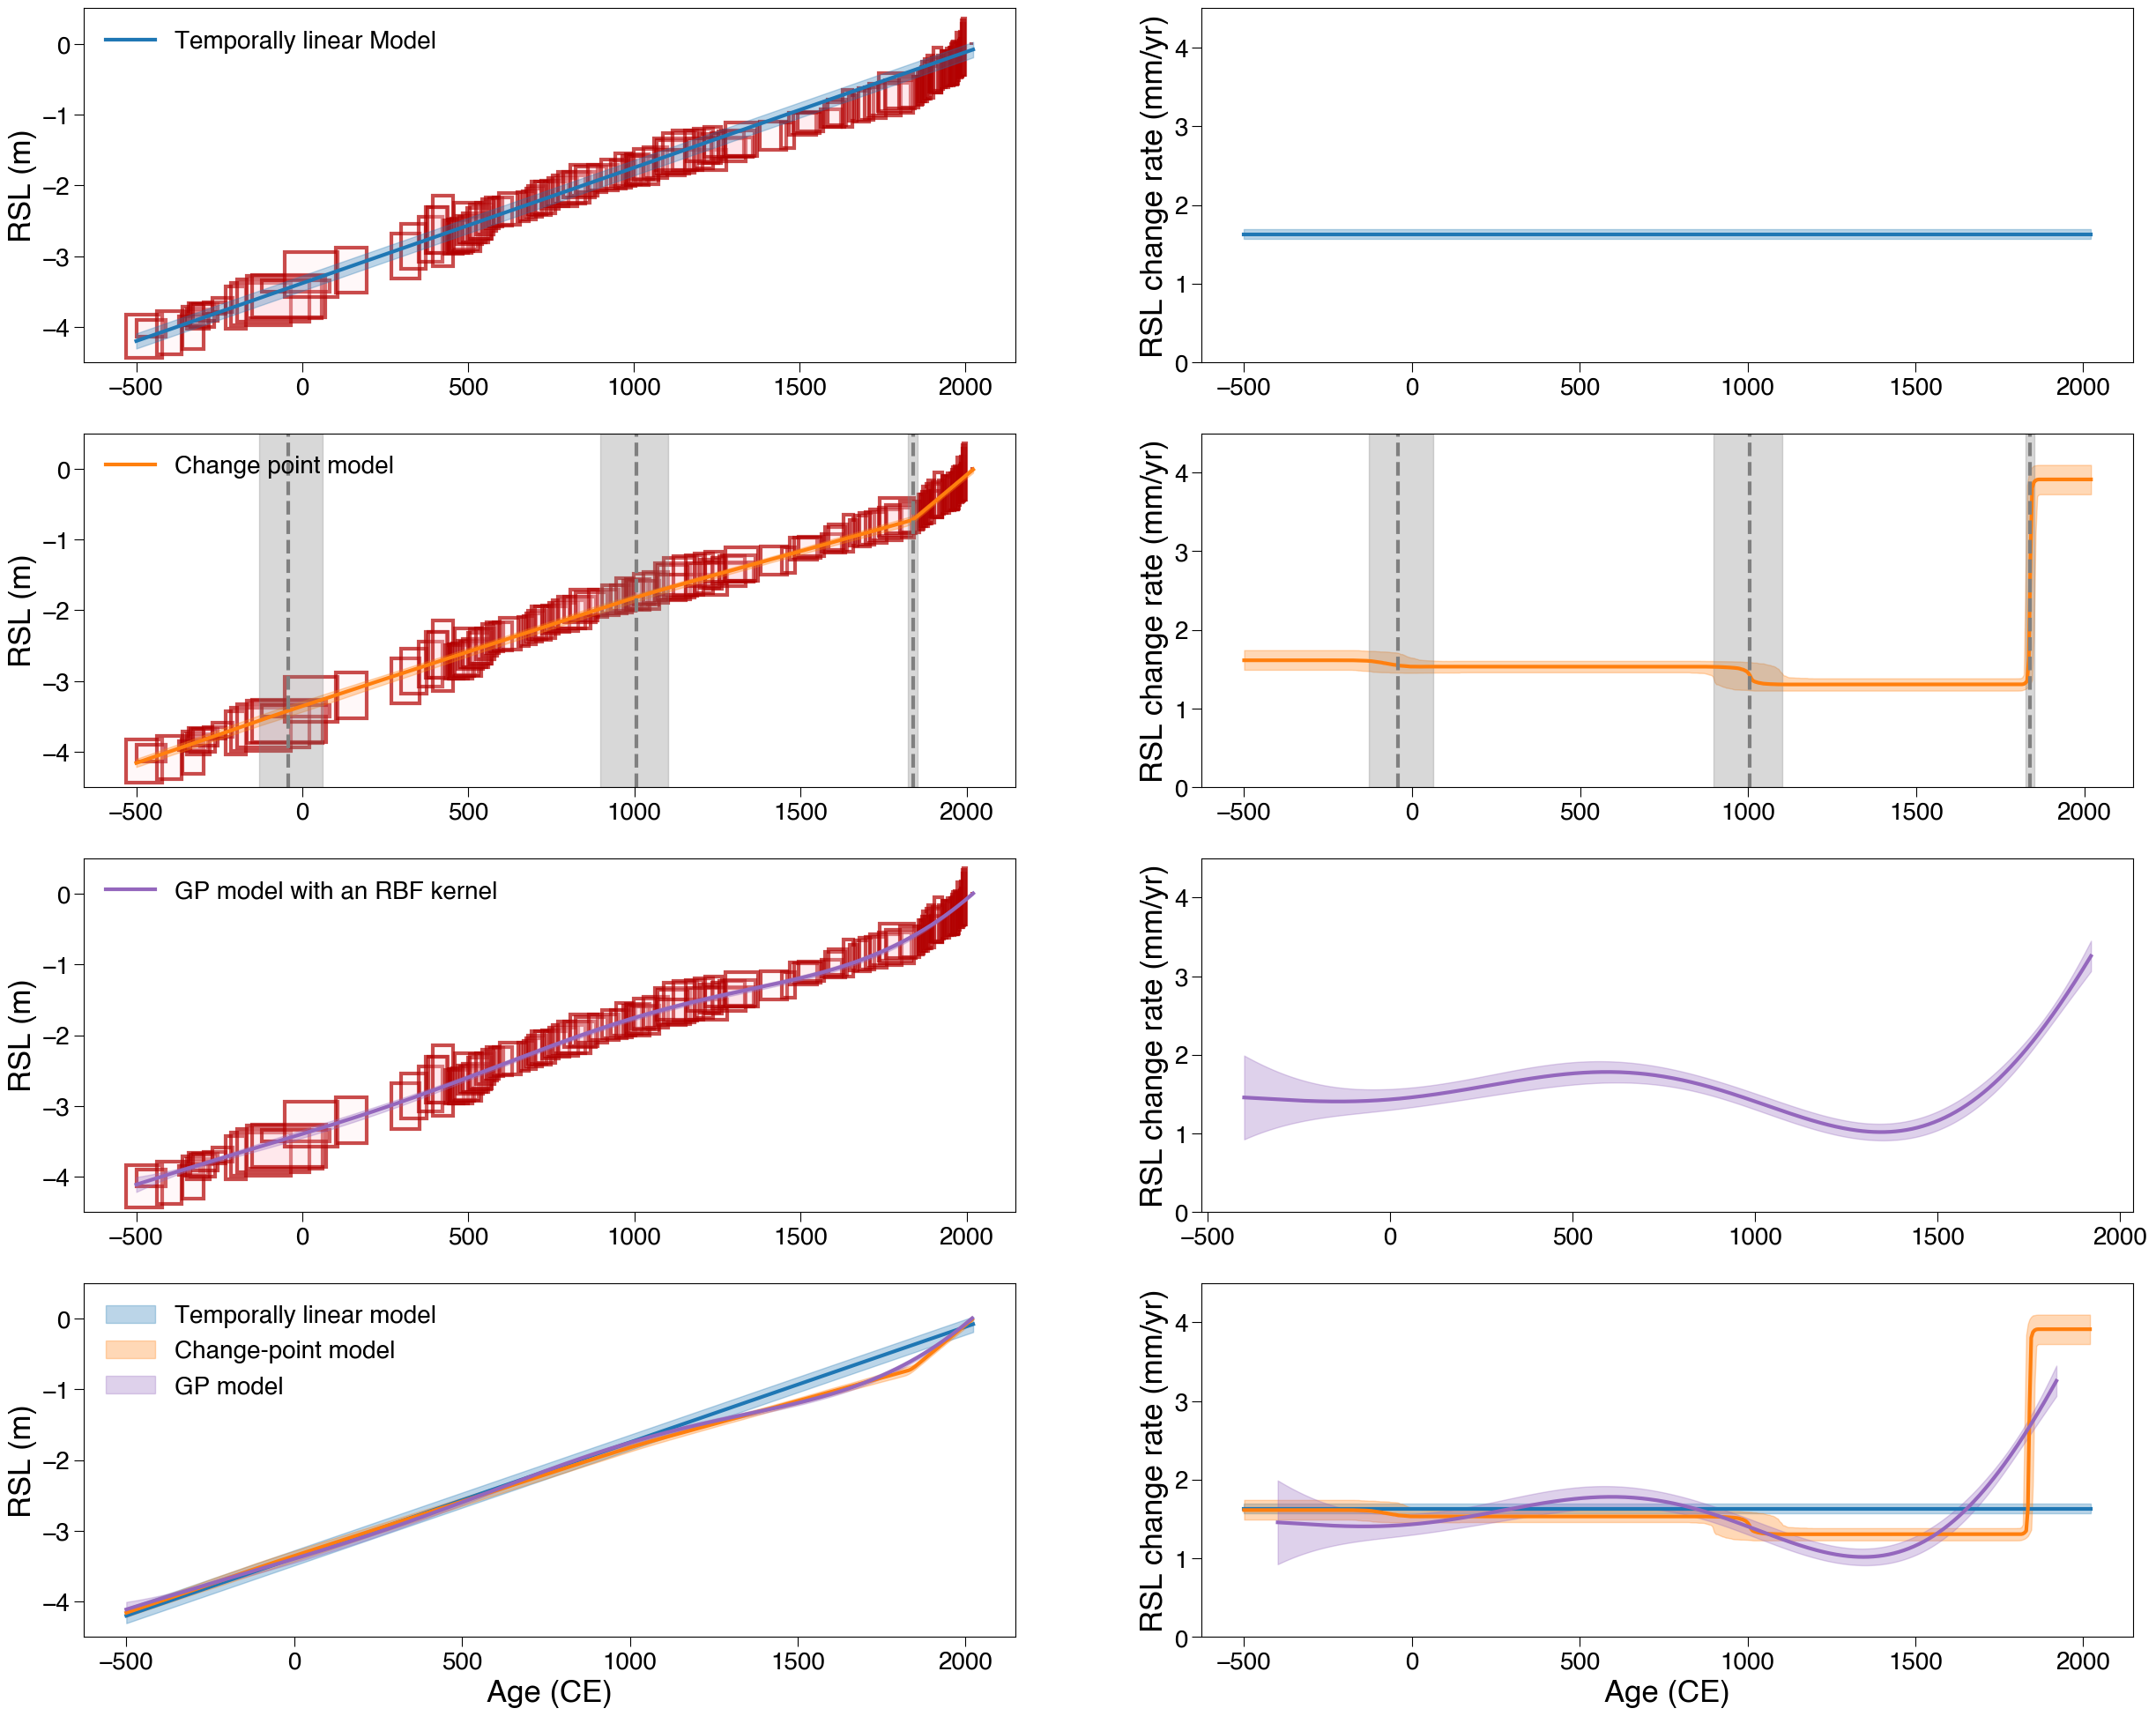

In [165]:
plt.figure(figsize=(30,24))
ax = plt.subplot(421)
linear_pred_5,linear_pred_95 = np.percentile(y_pred,[5,95],axis=0)
PSTHM.plotting.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax)
plt.plot(pred_x,mean_pred,color='C0',linewidth=3,label='Temporally linear Model')
plt.fill_between(pred_x,linear_pred_5,linear_pred_95,color='C0',alpha=0.3)
plt.ylabel('RSL (m)',fontsize=25)

# ax.set_xlim(-550,2025)
# ax.set_ylim(-5,1)
plt.xlabel('')
plt.ylim(-4.5,0.5)

plt.legend()

ax2 = plt.subplot(422)
plt.plot(pred_x,[a_mean*1000,a_mean*1000],color='C0',linewidth=3,label='Temporally linear model')
plt.fill_between(pred_x,(a_mean-1.645*a_std)*1000,(a_mean+1.645*a_std)*1000,color='C0',alpha=0.3)
plt.ylabel('RSL change rate (mm/yr)',fontsize=25)
# plt.xlabel('Age (CE)')
# plt.legend()
plt.ylim(0,4.5)

change_point_pred_5,change_point_pred_95 = np.percentile(change_point_pred,[5,95],axis=0)
change_point_pred_rate_5,change_point_pred_rate_95 = np.percentile(change_point_pred_rate,[5,95],axis=0)*1000

ax = plt.subplot(423)
PSTHM.plotting.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax,CE=True)
plt.plot(forward_x,change_point_pred_50,'C1',linewidth=3,label='Change point model')
plt.fill_between(forward_x,change_point_pred_5,change_point_pred_95,color='C1',alpha=0.3)
plt.ylabel('RSL (m)',fontsize=25)

for i in range(posterior['cp'].shape[1]):
    cp_5,cp_50,cp_95 = np.percentile(posterior['cp'][:,i],[5,50,95])
    plt.axvline(cp_50,color='grey',linestyle='--',linewidth=3)
    plt.axvspan(cp_5,cp_95,color='grey',alpha=0.3)
plt.legend()
plt.xlabel('')
plt.ylim(-4.5,0.5)

ax2 = plt.subplot(424)
plt.plot(forward_x,change_point_pred_rate_50,'C1',linewidth=3,label='Change-point model')
plt.fill_between(forward_x,change_point_pred_rate_5,change_point_pred_rate_95,color='C1',alpha=0.3)
for i in range(posterior['cp'].shape[1]):
    cp_p5,cp_50,cp_95 = np.percentile(posterior['cp'][:,i],[5,50,95])
    plt.axvline(cp_50,color='grey',linestyle='--',linewidth=3)
    plt.axvspan(cp_p5,cp_95,color='grey',alpha=0.3)
# plt.xlabel('Age (CE)')
plt.ylabel('RSL change rate (mm/yr)',fontsize=25)
plt.ylim(0,4.5)

ax2 = plt.subplot(425)
PSTHM.plotting.plot_uncertainty_boxes(X,y, x_sigma*2,y_sigma*2,ax=ax2,CE=True)
plt.plot(x_test,c_kernel_y_mean.detach().numpy(),color='C4',linewidth=3,label='GP model with an RBF kernel')
plt.fill_between(x_test,c_kernel_y_mean.detach().numpy()-1.645*c_kernel_sd.detach().numpy(),c_kernel_y_mean.detach().numpy()+1.645*c_kernel_sd.detach().numpy(),
                 color='C4',alpha=0.3)
plt.legend()
plt.xlabel('')
plt.ylabel('RSL (m)',fontsize=25)
plt.ylim(-4.5,0.5)
ax = plt.subplot(426)
plt.plot(rsl_time,c_kernel_rsl_rate*1000,'C4',linewidth=3)
plt.fill_between(rsl_time,(c_kernel_rsl_rate-1.645*c_kernel_rsl_rate_sd)*1000,(c_kernel_rsl_rate+1.645*c_kernel_rsl_rate_sd)*1000,color='C4',alpha=0.3)
# plt.xlabel('Age (CE)')
plt.ylabel('RSL change rate (mm/yr)',fontsize=25)
plt.ylim(0,4.5)
ax = plt.subplot(427)
plt.plot(pred_x,mean_pred,color='C0',linewidth=3)
plt.fill_between(pred_x,linear_pred_5,linear_pred_95,color='C0',alpha=0.3,label='Temporally linear model')
plt.plot(forward_x,change_point_pred_50,'C1',linewidth=3)
plt.fill_between(forward_x,change_point_pred_5,change_point_pred_95,color='C1',alpha=0.3,label='Change-point model')
plt.plot(x_test,c_kernel_y_mean.detach().numpy(),'C4',linewidth=3)
plt.fill_between(x_test,c_kernel_y_mean.detach().numpy()-1.645*c_kernel_sd.detach().numpy(),c_kernel_y_mean.detach().numpy()+1.645*c_kernel_sd.detach().numpy()
                 ,color='C4',alpha=0.3,label='GP model')
plt.xlabel('Age (CE)',fontsize=25)
plt.ylabel('RSL (m)',fontsize=25)
plt.ylim(-4.5,0.5)
plt.legend(loc=2)
ax = plt.subplot(428)
plt.plot(pred_x,[a_mean*1000,a_mean*1000],color='C0',linewidth=3)
plt.fill_between(pred_x,(a_mean-1.645*a_std)*1000,(a_mean+1.645*a_std)*1000,color='C0',alpha=0.3,label='Temporally linear model')
plt.plot(forward_x,change_point_pred_rate_50,'C1',linewidth=3)
plt.fill_between(forward_x,change_point_pred_rate_5,change_point_pred_rate_95,color='C1',alpha=0.3,label='Change-point model')
plt.plot(rsl_time,c_kernel_rsl_rate*1000,'C4',linewidth=3)
plt.fill_between(rsl_time,(c_kernel_rsl_rate-1.645*c_kernel_rsl_rate_sd)*1000,(c_kernel_rsl_rate+1.645*c_kernel_rsl_rate_sd)*1000,color='C4',alpha=0.3,label='GP model')
plt.ylabel('RSL change rate (mm/yr)',fontsize=25)
plt.ylim(0,4.5)
plt.xlabel('Age (CE)',fontsize=25);
# plt.savefig('model_comparison.pdf',dpi=300)

### 3. Gaussian Process basics

**Multivariate Normal distribution**

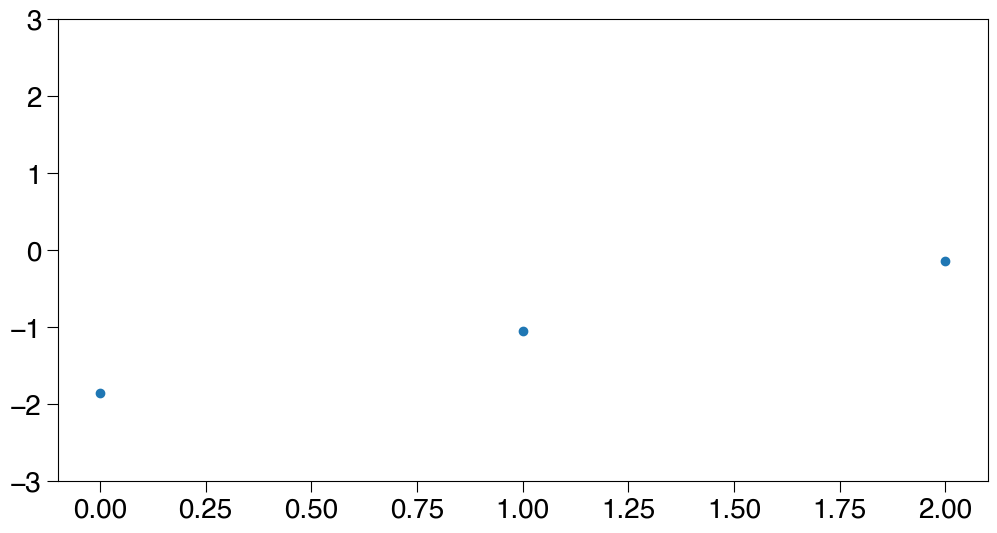

In [297]:
test_x = np.arange(3)
from scipy.stats import multivariate_normal
cov_1 = [[0.5,0,0],[0,0.5,0],[0,0,3]]
cov_2 = [[0.5,0.49,0],[0.49,0.5,0],[0,0,3]]
test_dis = multivariate_normal(mean=[0,0,0],cov = cov_1)
plt.scatter(test_x,test_dis.rvs(1))
plt.ylim(-3,3);


Following the process level tutorial in introduction series, we can get a bit of taste that what Gaussian Process (GP) can do to infer sea-level change pattern and rate. In this temporal GP tutorial series, you will further explore the capability of GP in modelling sea-level change. In specific you will learn:

**&#10148; 1.** Squared distance function and covariance function 

**&#10148; 2.** RBF kernel and its hyperparameters

**&#10148; 3.** Conditional probability

**&#10148; 4.** Hyperparameter optimization

Note this GP tutorial series was written based on [this blog](https://www.niamhcahill.com/post/gp_tutorial/) by Niamh Cahill and [this tutorial](https://github.com/christopherpiecuch/bayesGavle/blob/main/20230705_gia_v7.pdf) by Chris Piecuch. 

**Squared distance function and covariance function**

The covariance function takes two input points, typically denoted as x and x', and computes a measure of similarity or correlation between them. It provides a measure of how similar the outputs at those points are expected to be. For temporal sea-level modelling, we are measuring two data points with time t and t', and we expect two data points with small time difference (say 1 hour aparts) should more similar output variable $y,y'$ (say outdoor temperature) than two data points that are far away from each other (say 10 hours apart). 

Let's take real daily outdoor temperature at New Brunswick as an example, to make it mimic the behaviour of paleo sea-level, we will add a random Gaussian noise to it with 0 mean and 2 degree F sigma. So we have two taks here:

1. Recovering the underlying signal of temperature
2. Trying to find out the noise level within observation



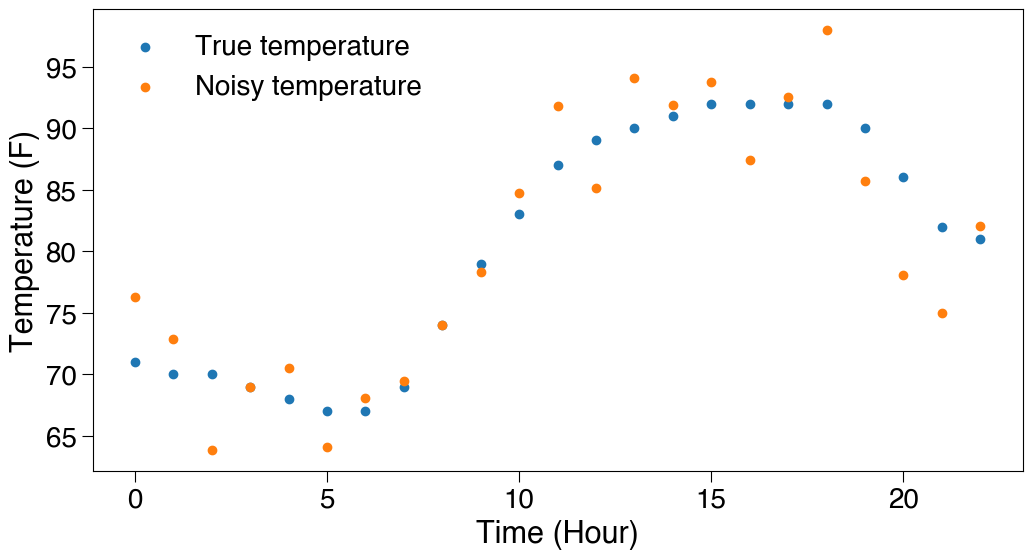

In [18]:
np.random.seed(10)
NB_t = pd.read_csv('../2.Temporal_GP/Data/tem_data_NB.csv',header=None)
t,tem = NB_t.iloc[:,0].values,NB_t.iloc[:,1].values
noise_tem = tem+np.random.normal(0,4,len(tem))

plt.scatter(t,tem,label='True temperature')

plt.scatter(t,noise_tem,label='Noisy temperature')
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (F)')
plt.legend();

We can clearly see that any two data points that are one hour apart from each other should have more similar temperature than those are 10 hours apart from each other. To quantify this, let's first generate a matrix that quantify the suqared time difference between each of two data points:
$$
D = \begin{pmatrix}
  (t_{1} -t_{1})^2      & (t_{1} -t_{2})^2     & \cdots  & (t_{1} -t_{n})^2  \\
  (t_{2} -t_{1})^2       &   (t_{2} -t_{2})^2     & \cdots  & (t_{2} -t_{n})^2 \\
  \vdots  & \vdots   & \ddots  & \vdots \\
  (t_{n} -t_{1})^2       & (t_{n} -t_{2})^2    & \cdots  & (t_{n} -t_{n})^2 \\
\end{pmatrix}
$$
where $n$ indicates the number of data points we have. Let's do this for our dataset.

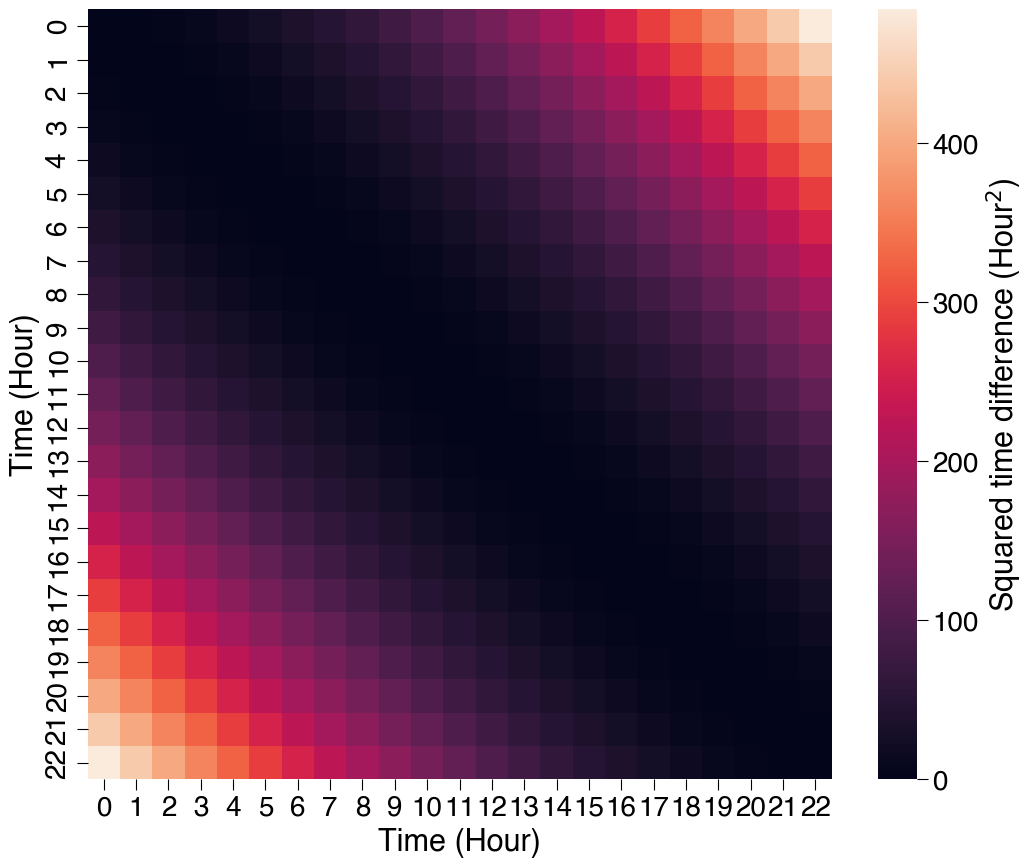

In [19]:
sqaured_diff_mat = (t[:,None]-t[None,:])**2
plt.figure(figsize=(12,10))
sns.heatmap(sqaured_diff_mat,cbar_kws={'label': 'Squared time difference (Hour$^2$)'})
plt.xlabel('Time (Hour)')
plt.ylabel('Time (Hour)');

**RBF kernel and its hyperparameters**

Now we know the squared time difference between each data point, and now, we can include a kernel to measure "how similar the temperature between two data points given their squared time difference". For GP regression, a very popular choice is the squared exponential kernel (i.e., [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel); RBF):
$$
k_{RBF}(t,t') = \sigma^2\exp\left(-0.5 \times \frac{|t-t'|^2}{l^2}\right)
$$
where $|t-t'|^2$ is equivalent to our sqaured time difference function $D$ above; $\sigma ^2$ and $l$ are variance and lengthscale hyperparameters that control the overall amplitude and smoothness of the kernel function. To give you some ideas about how they control the covariance, let's try three different combinations:


| Model | $l$  | $\sigma ^2$ |
|  :---:|  :---:  |    :---: |
| 1  | 3      |    10|
|  2  | 3      |    30 |
|  3  | 9      |    10 |


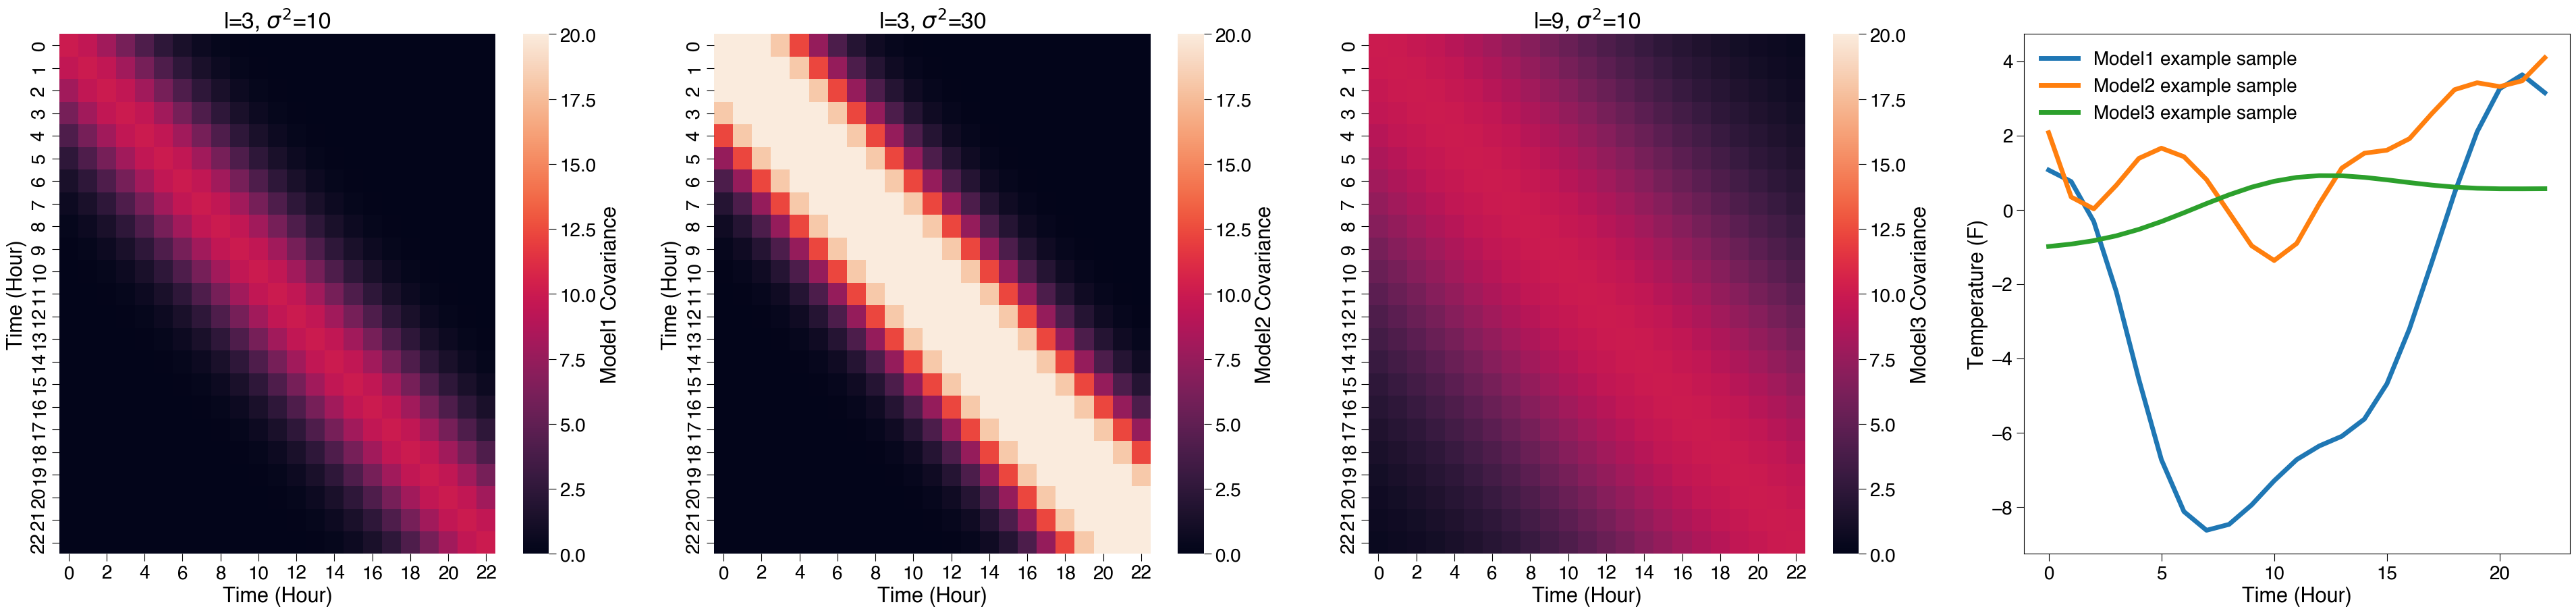

In [20]:
model1 = 10*np.exp(-0.5*sqaured_diff_mat/3**2)
model2 = 30*np.exp(-0.5*sqaured_diff_mat/3**2)
model3 = 10*np.exp(-0.5*sqaured_diff_mat/9**2)

plt.figure(figsize=(48,10))

plt.subplot(1,4,1)
sns.heatmap(model1, vmax=20,vmin=0,cbar_kws={'label': 'Model1 Covariance'})
plt.xlabel('Time (Hour)')
plt.ylabel('Time (Hour)')
plt.title('l=3, $\sigma^2$=10')

plt.subplot(1,4,2)
sns.heatmap(model2, vmax=20,vmin=0,cbar_kws={'label': 'Model2 Covariance'})
plt.title('l=3, $\sigma^2$=30')
plt.xlabel('Time (Hour)')
plt.ylabel('Time (Hour)')

plt.subplot(1,4,3)
sns.heatmap(model3, vmax=20,vmin=0,cbar_kws={'label': 'Model3 Covariance'})
plt.xlabel('Time (Hour)')
plt.title('l=9, $\sigma^2$=10');

#draw sample from a multivariate normal distribution using covariance matrix above
sample1 = np.random.multivariate_normal(np.zeros(len(model1)), cov=model1)
sample2 = np.random.multivariate_normal(np.zeros(len(model2)), cov=model2)
sample3 = np.random.multivariate_normal(np.zeros(len(model3)), cov=model3)
plt.subplot(1,4,4)
plt.plot(t,sample1,label='Model1 example sample',lw=5)
plt.plot(t,sample2,label='Model2 example sample',lw=5)
plt.plot(t,sample3,label='Model3 example sample',lw=5)
plt.legend()
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (F)');

The first three subplots show the covariance matrix given two hyperparameters, and the last subplot shows the example sample draws from a multivariate Gaussian distribution using the three covariance matricies on the left with 0 mean. The example sample draws here can be seen as blind draws without observing any data, which can be expressed as:
$$
p(f| \sigma, l) \sim GP(0,k_{RBF}(t,t'))
$$

where '|' means `given`. A 0 mean implies that, on average, the predicted values are expected to be centered around zero. This assumption is often used when there is no prior knowledge or specific information about the mean behavior of the underlying function. However, it's important to note that using a zero mean function does not imply that the predicted values will be exactly zero. The GP regression model captures the deviations from the mean function using the covariance defined by the kernel function. Thus, the mean function represents the average behavior, while the covariance captures the variability and patterns in the data.

By comparing model 1 and 2, we can see that $\sigma$ mainly controls the amplitude of covariance matrix, which in turn controls the average distance of function away from its mean. The impact of $l$ can be found between model 1 and 3, where we can see that the covariance between two data point decrease slower in model 3, meaning one data point will have more impact on another data point further away from it. This can be seen in the last subplot that the sample from model 3 is not as wiggle as model 1 and 2. 

For this tutorial, we will use a framework called [pyro](pyro.ai), a universal probabilistic programming language written in Python and supported by PyTorch on the backend. And because we use PyTorch as the backend, we need to make sure every data should be presented in [torch.tensor](https://pytorch.org/docs/stable/tensors.html).You can easily do the same thing in pyro by the following code:

In [21]:
pyro.clear_param_store()
#build covariance matrix
RBF1 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(3),variance=torch.tensor(10))
RBF2 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(3),variance=torch.tensor(30))
RBF3 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(9),variance=torch.tensor(10))
#calculate covariance matrix for time t
t = torch.tensor(t)
noise_tem = torch.tensor(noise_tem)
tem = torch.tensor(tem)

model1 = RBF1(t)
model2 = RBF2(t)
model3 = RBF3(t)

**Conditional probability**


Now, we can start to calculate conditional probability, given we have some observational data. This time, we can express the inference as:
$$
p(f| \sigma, l, y) \sim GP(0,k_{RBF}(t,t'))
$$
Because the conditional probability of a multivariate Gaussian distribution is another multivariate Gaussian distribution, we are interested to infer the mean (or expected value, $E$) and covariance matrix $Cov_{pred}$ of the resulting conditional probablity. But one thing before that is, with GP, we are interested to infer temperature values for a series of unknown time $t^{*}$ instead of known time $t$, so we should bring in a new notation:
$$
K = k(t,t')
$$
so $K_{RBF}$ is equivalent to what we have done above. Hence, if we have $n$ data point, $K$ should have a shape of $(n \times n)$. And for new time point $t_*$, we can write:
$$
K_* = k(t,t_*)
$$
indicating we are first calculating the sqaured distance between each new time point with known data point $t$. Hence, if we want to calculate 100 new time points (denotes as $n_{2}$), this distance matrix should have a shape of $(n \times n_{2} )$. Then this new covariance matrix ($K_*$) can be calculated based on this new squared distance matrix. And to calculate conditional probablility, we also need to calculate a covariance matrix between any two unknown time point:
$$
K_{**} = k(t_*,t_*)
$$
In this case, $K_{**}$ should have a shape of $(n_{2} \times n_{2})$. Once we calculate these, we can start to infer the conditional probablity of $y^{*}$ in unknown time $t^{*}$, which can be expressed as:
$$
E(y_{*}| \sigma, l, y) = K_{*}^{T}K^{-1}y\\
Cov(y_{*}| \sigma, l, y) = K_{**} - K_{*}^{T}K^{-1}K_{*}
$$
In many paleo-environmental applications, the observation $y$ can be noisy (recall data level tutorial):
$$
y_{i} = f(t_{i},x_{i}) + \epsilon_{i}
$$
In GP regression framework, this can be nicely embedded in kernel function by replacing $K^{-1}$ in the equation above with:
$$
\hat{K}^{-1} = (K+\Sigma_{\epsilon})^{-1}
$$
where $I$ is an identity matrix, and $\Sigma_{\epsilon}$ indicates covariance function of observational uncertainty. If we assume each observational data is independent, this can be re-written as:

$$
\hat{K}^{-1} = (K+\sigma_{\epsilon}I)^{-1}

$$

where $I$ is the identity matrix. Here we do not include the theoretical provement of these equations, if you are interested to know more about it, you can check section 2 of [this book](https://gaussianprocess.org/gpml/chapters/RW.pdf) by Rasmussen and Williams, 2006. 

It is very easy to perform these in pyro, with the following procedures:

* Clear parameter store: it is very important to clear all parameter store for every pyro model
* Build a RBF kernel: we should define 2 hyperparameters
* Build a GP model: we should set input dimension (which is 1 here), input varaible (time), output variable (temperature) and observational noise (all data points have one-sigma noise of 2 here)
* Run GP model: this indicates we are calculating conditional probability given the observations and hyperparameters

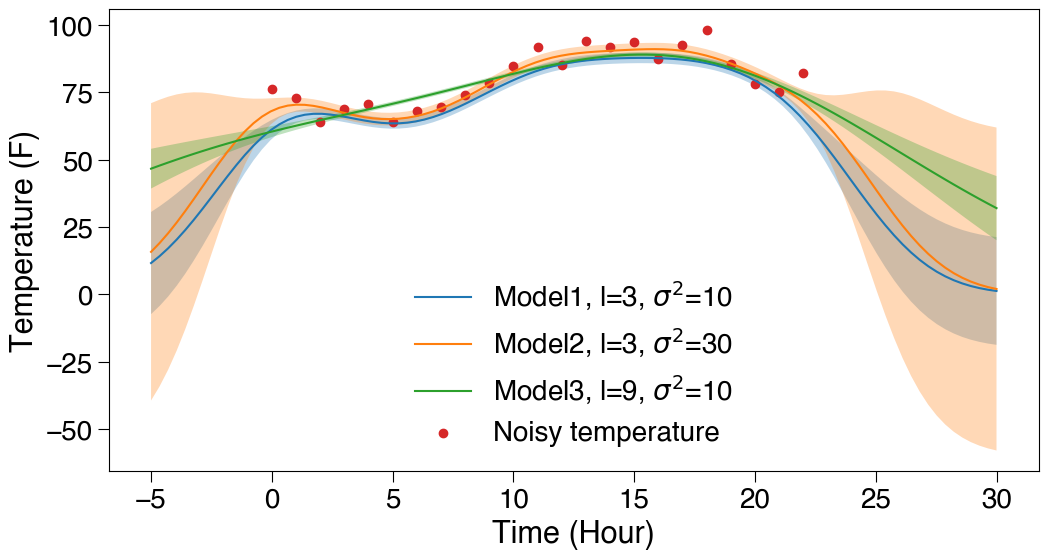

In [22]:
#make sure you clear all the parameter store before you define a new model
pyro.clear_param_store()
#define GP regression models
RBF1 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(3),variance=torch.tensor(10))
#define GP regression models
gpr1 = PSTHM.model.GPRegression_V(t, noise_tem, RBF1,noise=torch.ones(len(t))*2**2) #noise is the variance of the uncertainty 
#infer conditional probability distribution for unknown time
time_new = torch.linspace(-5,30,100).double()
mean1, sd1 = gpr1(time_new)

pyro.clear_param_store()
RBF2 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(3),variance=torch.tensor(30))
gpr2 = PSTHM.model.GPRegression_V(t, noise_tem, RBF2,noise=torch.ones(len(t))*2**2)
mean2, sd2 = gpr2(time_new)

pyro.clear_param_store()
RBF3 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(9),variance=torch.tensor(10))
gpr3 = PSTHM.model.GPRegression_V(t, noise_tem, RBF3,noise=torch.ones(len(t))*2**2)
mean3, sd3 = gpr3(time_new)

#-----------------plot-----------------
#in order to plot it with matplotlib, we need to convert torch tensor to numpy array    
plt.figure(figsize=(12,6))
plt.plot(time_new.detach().numpy(),mean1.detach().numpy(),label='Model1, l=3, $\sigma^2$=10')
plt.fill_between(time_new.detach().numpy(),(mean1-2*sd1).detach().numpy(),(mean1+2*sd1).detach().numpy(),alpha=0.3)
plt.plot(time_new.detach().numpy(),mean2.detach().numpy(),label='Model2, l=3, $\sigma^2$=30')
plt.fill_between(time_new.detach().numpy(),(mean2-2*sd2).detach().numpy(),(mean2+2*sd2).detach().numpy(),alpha=0.3)
plt.plot(time_new.detach().numpy(),mean3.detach().numpy(),label='Model3, l=9, $\sigma^2$=10')
plt.fill_between(time_new.detach().numpy(),(mean3-2*sd3).detach().numpy(),(mean3+2*sd3).detach().numpy(),alpha=0.3)
plt.scatter(t,noise_tem.detach().numpy(),label='Noisy temperature')


plt.legend(loc=8)
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (F)');


You should be able to see the following effects from different hyperparameters:

1. With larger $l$, like model 3, the output model will be less wiggle as models 1 and 2 with smaller $l$. Compared to model 3, it takes model 1 and 2 less distance to drop to the mean value of 0 after the last observation at 22.
1. The impact of $\sigma ^2$ can be found by comparing model 1 and 2, you can find out that model 2 shows much larger uncertainty range relative to model 1 in unknown time located away from the observations.
1. Mean function, as we use a 0 mean here, which means all model will present a 0 prediction for times far away from observations.

**Hyperparameter optimization**

Once you understand the impact of different hyperparameter combinations, we can start to find the hyperparameters that best fit the observational data, as we did in analysis choice tutorial. Also, we want the model to infer the variance of observational noise, which we set as 4 above. Here we use empirical Bayes method to optimize hyperparameters with maximum likelihood estimate.

  0%|          | 0/1500 [00:00<?, ?it/s]

Execution time: 1.795 s


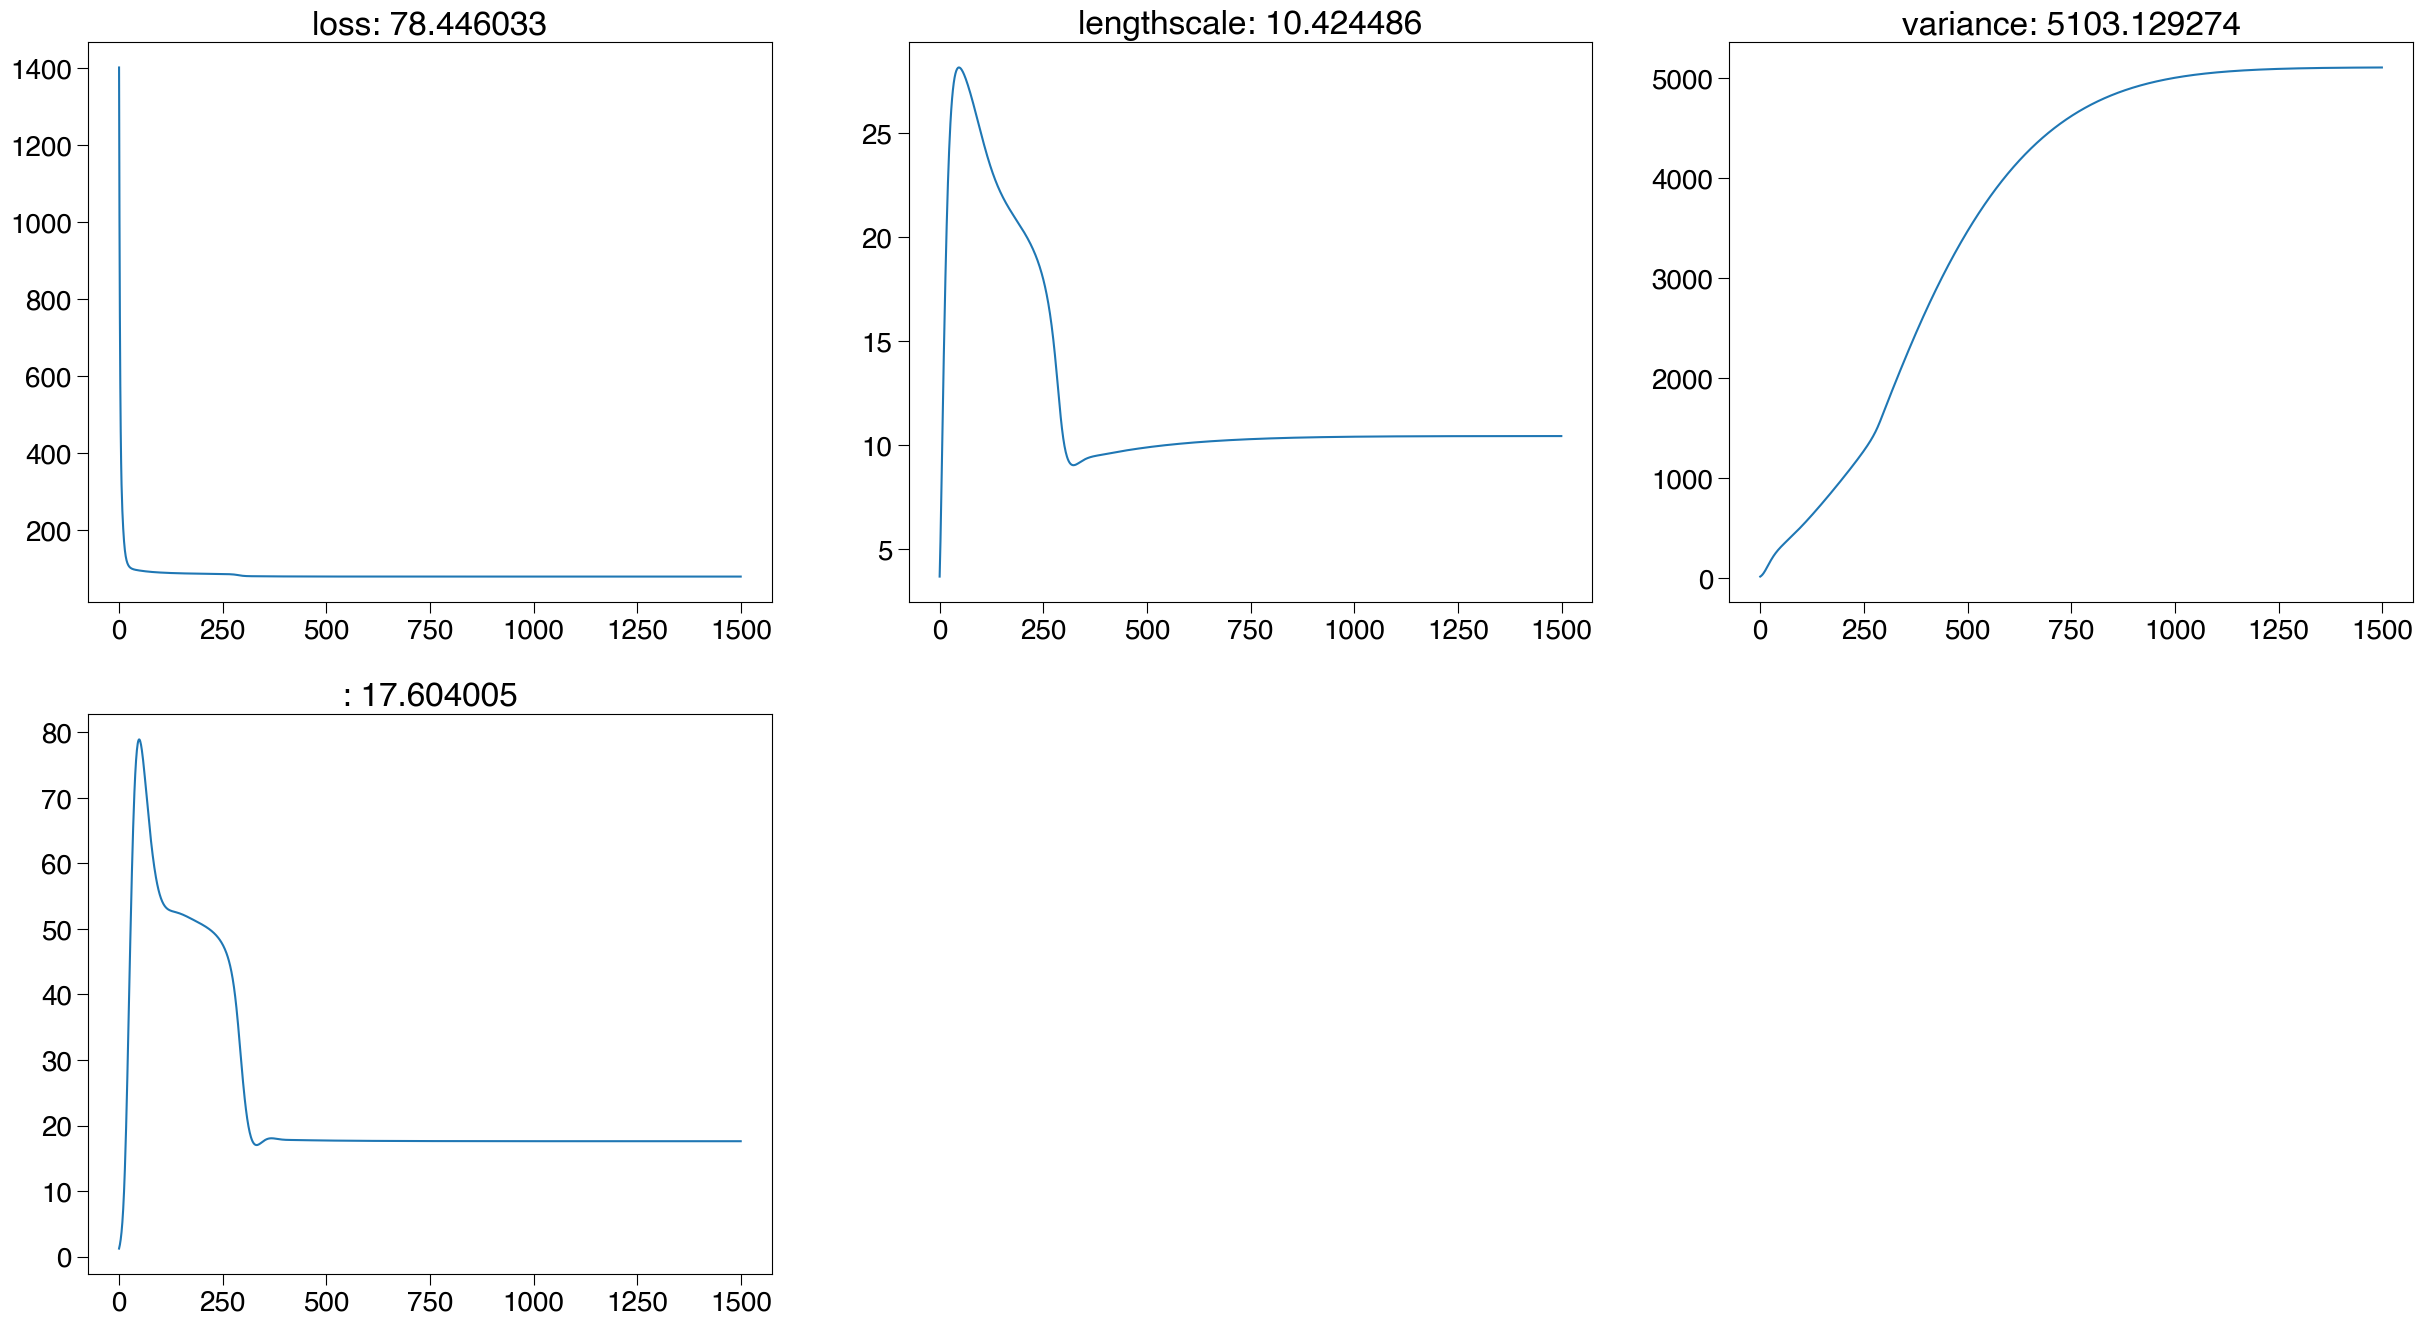

In [23]:
st = time.time() 

#make sure you clear all the parameter store before you define a new model
pyro.clear_param_store()
#define GP regression models
RBF = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(3),variance=torch.tensor(10))
#define GP regression models
# noise_variance = torch.ones(len(t))*2**2
gpr = PSTHM.model.GPRegression_V(t, noise_tem, RBF) #noise is the variance of the uncertainty 
#optimize GP model parameters
gpr,track_list = PSTHM.opti.SVI_optm(gpr,lr=0.2,num_iteration=1500)

axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

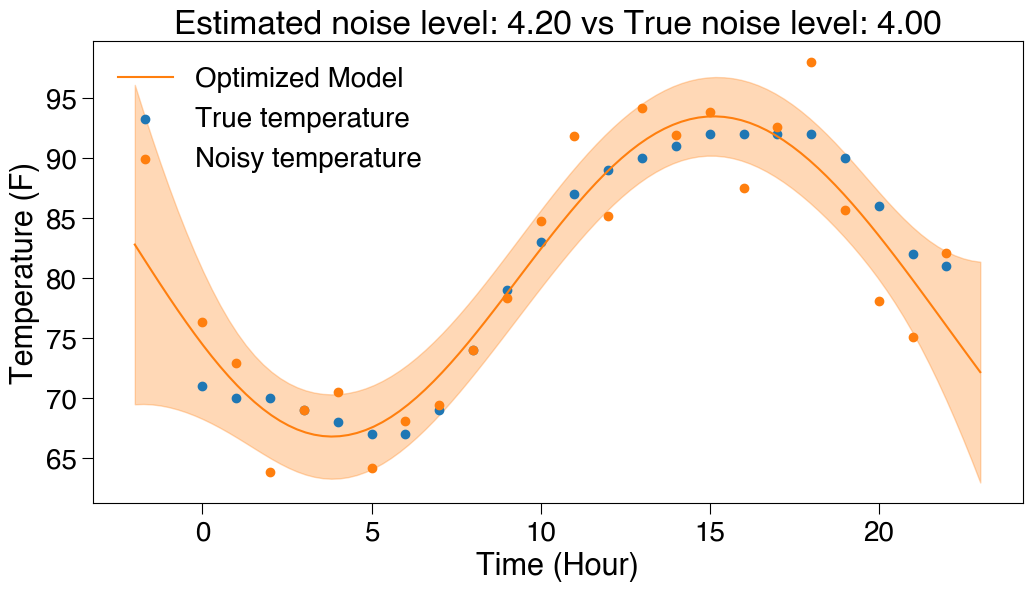

In [24]:
#infer conditional probability distribution for unknown time
time_new = torch.linspace(-2,23,100).double()
mean, cov = gpr(time_new,full_cov=True) 
sd = cov.diag().sqrt()
#-----------------plot-----------------
#in order to plot it with matplotlib, we need to convert torch tensor to numpy array    
plt.figure(figsize=(12,6))

plt.plot(time_new.detach().numpy(),mean.detach().numpy(),label='Optimized Model',color='C1')
plt.fill_between(time_new.detach().numpy(),(mean-2*sd).detach().numpy(),(mean+2*sd).detach().numpy(),alpha=0.3,color='C1')
plt.scatter(t,tem.detach().numpy(),label='True temperature',color = 'C0')
plt.scatter(t,noise_tem.detach().numpy(),label='Noisy temperature',color = 'C1')

plt.title('Estimated noise level: {:4.2f} vs True noise level: {:4.2f}'.format(gpr.noise.detach().numpy()**0.5,4))
plt.legend(loc=0)
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (F)');

We can see that, the optimized model fit well with the noisy data used for training the model, it also did a decent job to fit with true data (green points) which were not provided for model training. This is a major advantage of GP, it can easily deal with noisy that are normally distribued.

You can also draw samples from this optimized model, which can be easily done in pyro: 

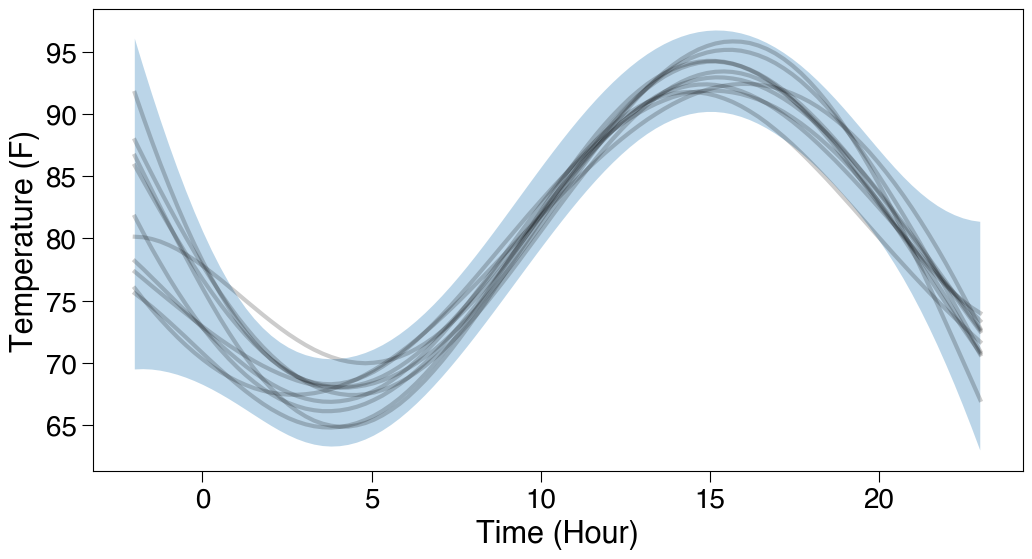

In [25]:
#add a small number to the diagonal of the covariance matrix to make it positive definite
cov += + (torch.ones(len(time_new))*1e-5).diag()
sample_num = 10
samples = dist.MultivariateNormal(
            mean, covariance_matrix=cov
        ).sample(sample_shape=(sample_num,))
plt.fill_between(time_new.detach().numpy(),(mean-2*sd).detach().numpy(),(mean+2*sd).detach().numpy(),alpha=0.3)

for i in range(sample_num):
    plt.plot(time_new.detach().numpy(),(samples[i]).detach().numpy(),lw=3,alpha=0.2,color='k')
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (F)');

### 4. Gassusian Process Kernels and Kernel Operations

**&#10148; 1.** Popular GP kernels 

**&#10148; 2.** Combining different GP kernels

**&#10148; 3.** Modelling real-world CO2 concentration



**1.1 RBF kernel** 

The Radial Basis Function kernel (AKA Squared Exponential Kernel) is a default kernel choice for many applications due to several nice properties:  It is universal, and you can integrate it against most functions that you need to. Every function in its prior has infinitely many derivatives. It also has only two parameters:

$$
k_{RBF}(t,t') = \sigma^2\exp\left(-0.5 \times \frac{|t-t'|^2}{l^2}\right)
$$

where $\sigma ^2$ and $l$ are variance and lengthscale hyperparameters that control the overall amplitude and smoothness of the kernel function. You should be familiar with them from the last tutorial. 

A reminder that, to build a GP model with pyro and PaleoSTeHM, we should go through the following precedures:

* Clear parameter store: it is very important to clear all parameter store for every pyro model
* Build a GP kernel: we should define initial value or prior distributions for hyperparameters
* Build a GP model: we should set input dimension (which is 1 here), input varaible, output variable and observational noise
* Run GP model: this indicates we are calculating conditional probability given the observations and hyperparameters



  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 163.452
Execution time: 1.696 s


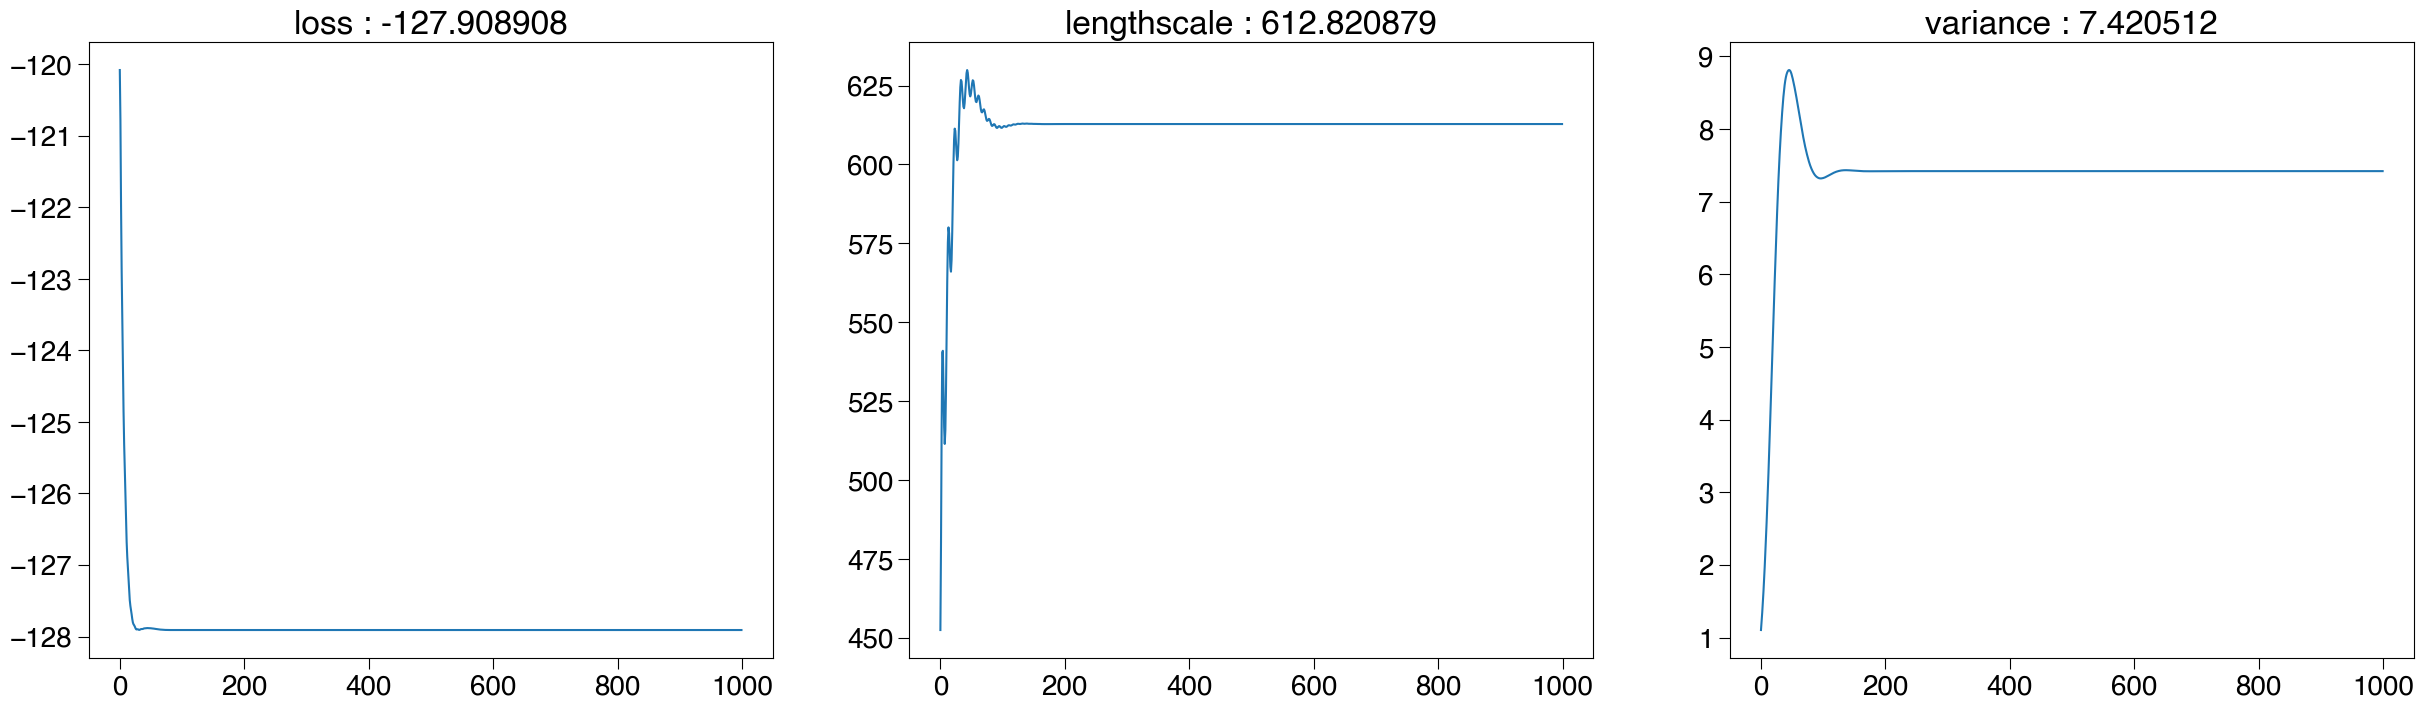

In [26]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a RBF kernel 
RBF_kernel = PSTHM.kernels.RBF(input_dim=1,variance=torch.tensor(1.),lengthscale=torch.tensor(500.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(X, y, RBF_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.post.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))

axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


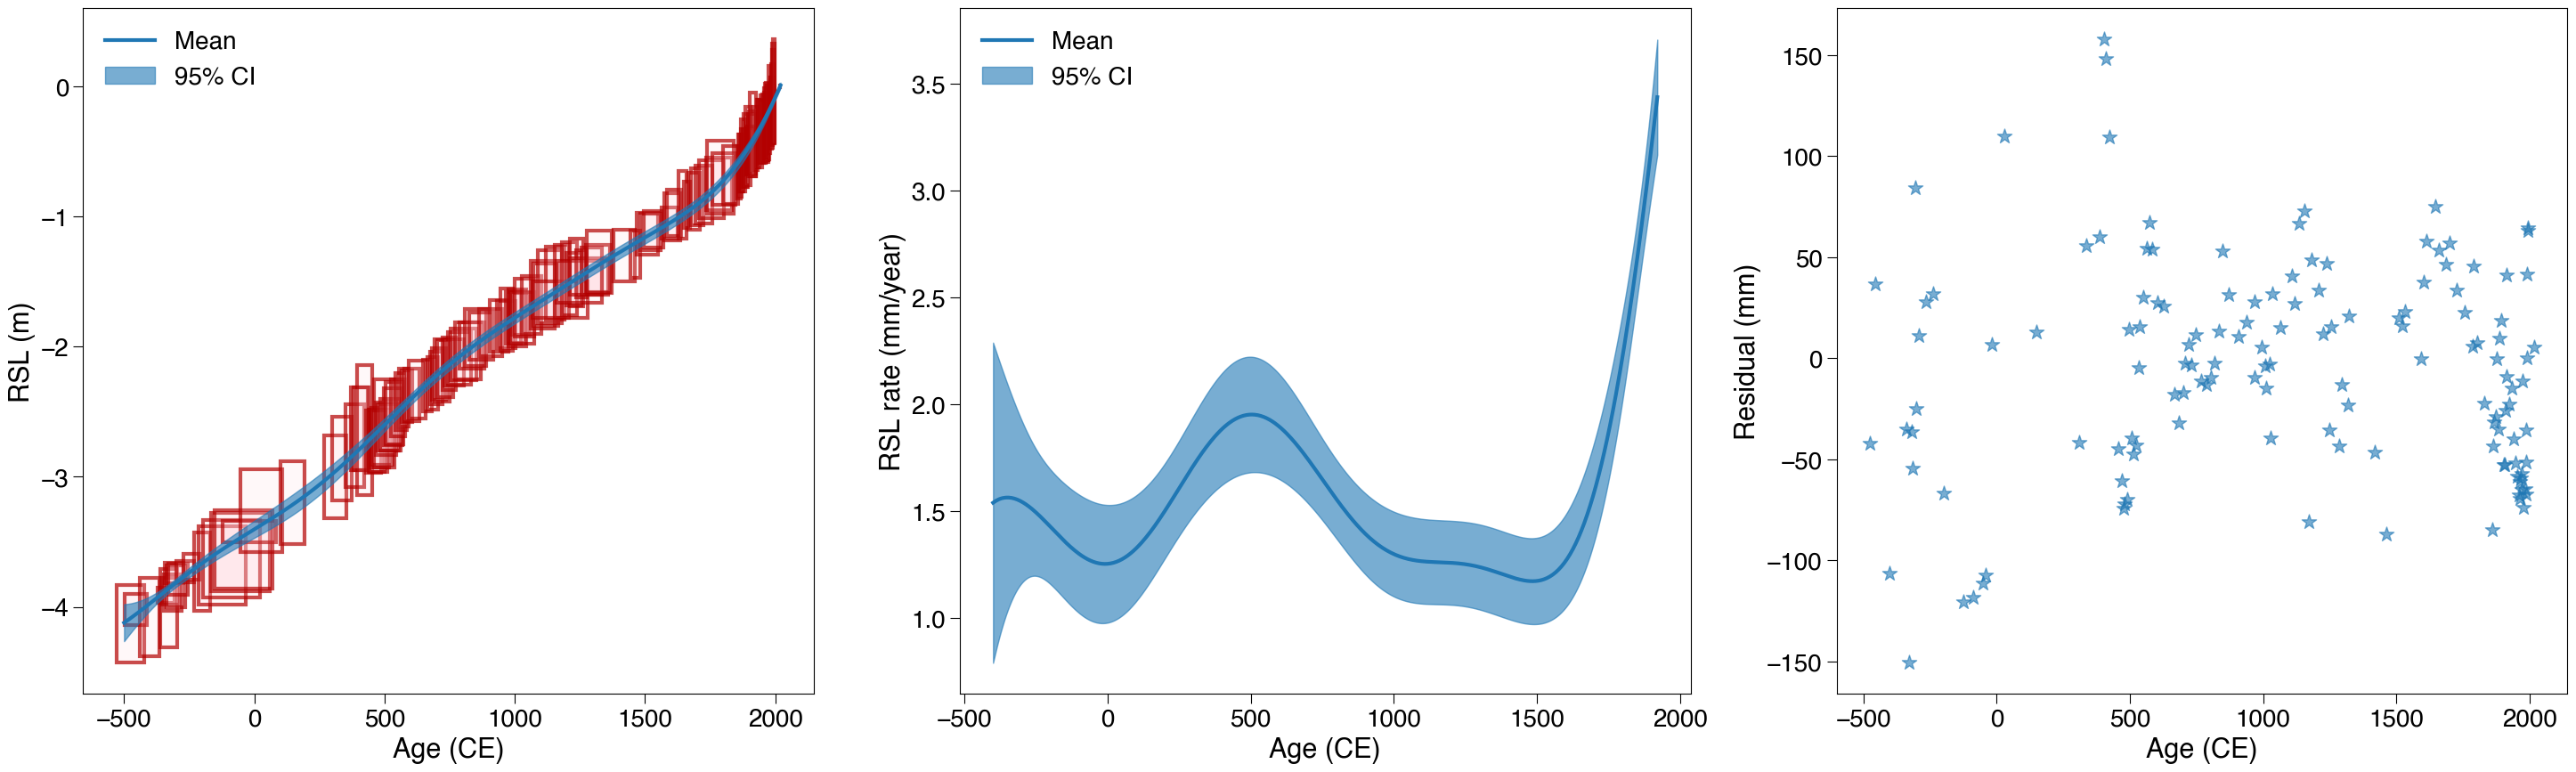

In [27]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.)
y_mean, y_var = gpr(x_test.double(), full_cov=True)
sd = torch.diag(y_var).sqrt()  # standard deviation at each input point x
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),y_var.detach().numpy(),y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,y_mean,sd,
                          rsl_time,rsl_rate,rsl_rate_sd)

You can see that the inference results by a RBF kernel is really smooth, this is due to its property of infinitely differentiable. This property is mostly ok in many cases, but it may not be appropriate for a time series that may change abruptly sometimes, like sea-level rise caused by global warming. In this case, let's introduce two alternative kernels that relif the infinitely differentiable assumption.

**1.2 3/2 Matérn kernel**

The Matérn family of kernels were popularized by Michael Stein, who coined the name based on initial work by statistician Bertil Matérn. Within Matérn family, each kernel has a $\nu$ parameter, indicating that kernel is $\nu$ - 0.5 times differentiable. For example, 3/2 Matérn kernel has a $\nu$ value of 3/2, which can be expressed as:

$$
k_{M_{32}}(t, t') = \sigma^2\left(1 + \sqrt{3} \times \frac{|t-t'|}{l}\right)
        \exp\left(-\sqrt{3} \times \frac{|t-t'|}{l}\right)
$$
therefore, 3/2 Matérn kernel is one-time differentiable. Similar to RBF kernel, $\sigma$ here is an amplitude hyperparameter and $l$ is a length scale hyperparameter. $|t-t'|$ indicate a abosolute distance matrix, which only differs squared distance function we introduced in last tutorial because it uses the abosolute distance. Since 3/2 Matérn kernel is only once differentiable, it allows sea-level to change more abruptly.



  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 165.505
Execution time: 1.817 s


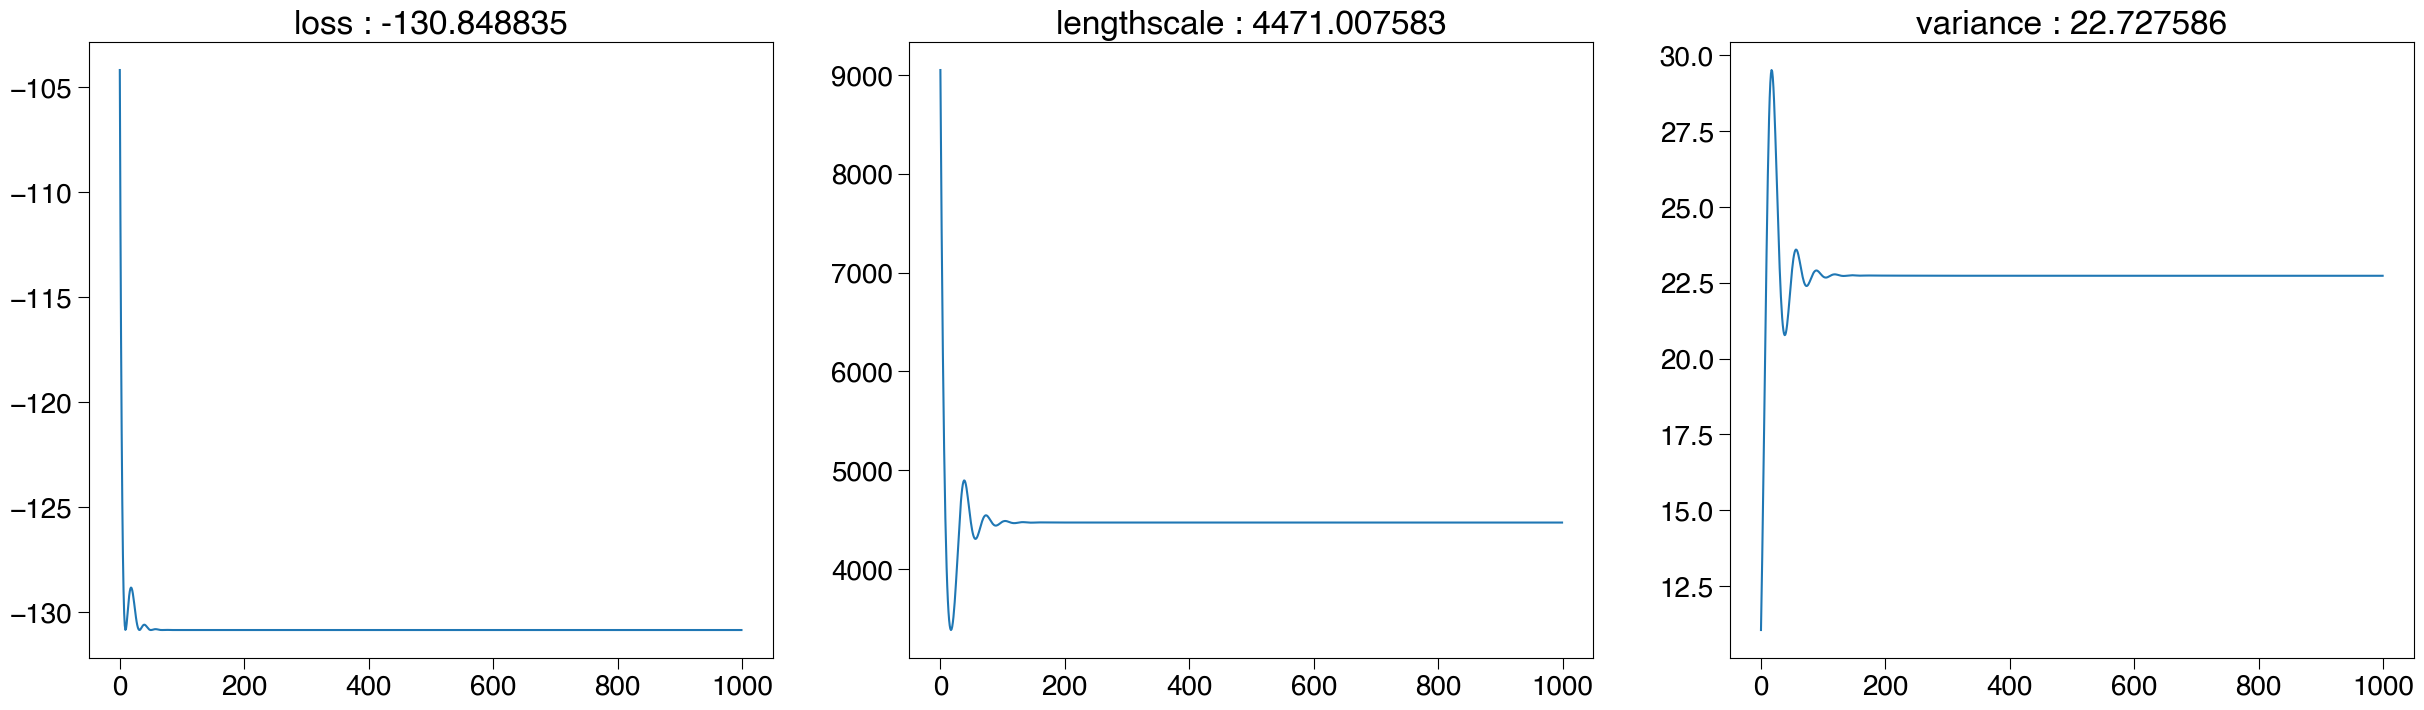

In [28]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a Matern32 kernel 
Matern32_kernel = PSTHM.kernels.Matern32(input_dim=1,variance=torch.tensor(10.),lengthscale=torch.tensor(10000.))

#generate a GP gression model conditioned on RSL data

gpr = PSTHM.model.GPRegression_V(X, y, Matern32_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.post.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))
axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

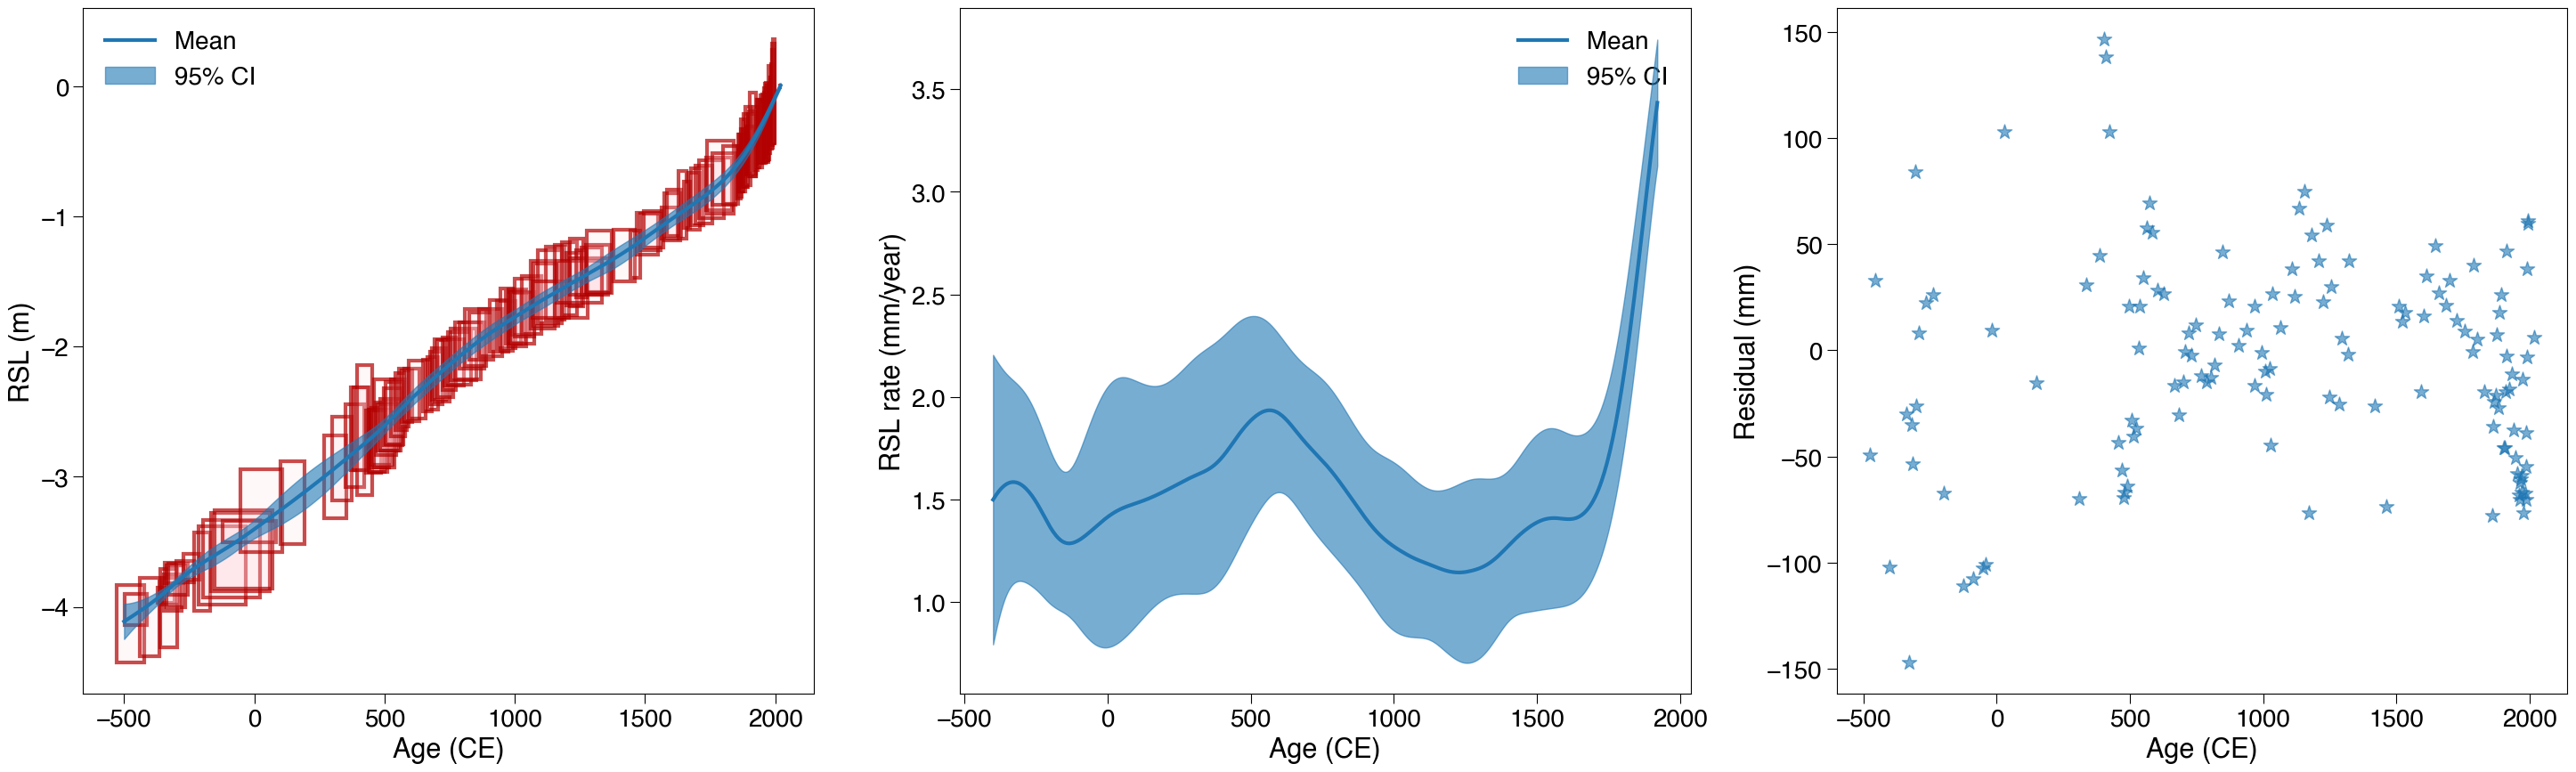

In [29]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
Matern32_y_mean, Matern32_y_var = gpr(x_test.double(), full_cov=True)
Matern32_sd = torch.diag(Matern32_y_var).sqrt()  # standard deviation at each input point x
rsl_time,Matern32_rsl_rate,Matern32_rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),Matern32_y_var.detach().numpy(),Matern32_y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,Matern32_y_mean,Matern32_sd,
                          rsl_time,Matern32_rsl_rate,Matern32_rsl_rate_sd)

You can see that 3/2 Matérn kernel is able to capture more short-wavelength information and shows higher log likelihood compared with RBF kernel!

**1.3 5/2 Matérn kernel**

And if we think the signal might change abruptly but not as much as indicated by 3/2 Matérn kernel, we have an intermideate option of 5/2 Matérn kernel, which is two-times differentiable. This kernel is useful and commonly-used in spatio-temporal analysis which we will cover in another tutorial. This kernel can be written as:
$$
k_{M_{52}}(t,t')=\sigma^2\left(1+\sqrt{5}\times\frac{|t,t'|}{l}+\frac{5}{3}\times
        \frac{|t,t'|^2}{l^2}\right)\exp\left(-\sqrt{5} \times \frac{|t,t'|}{l}\right)
$$
As above, $\sigma$ here is an amplitude hyperparameter and $l$ is a length scale hyperparameter.

  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 163.702
Execution time: 1.776 s


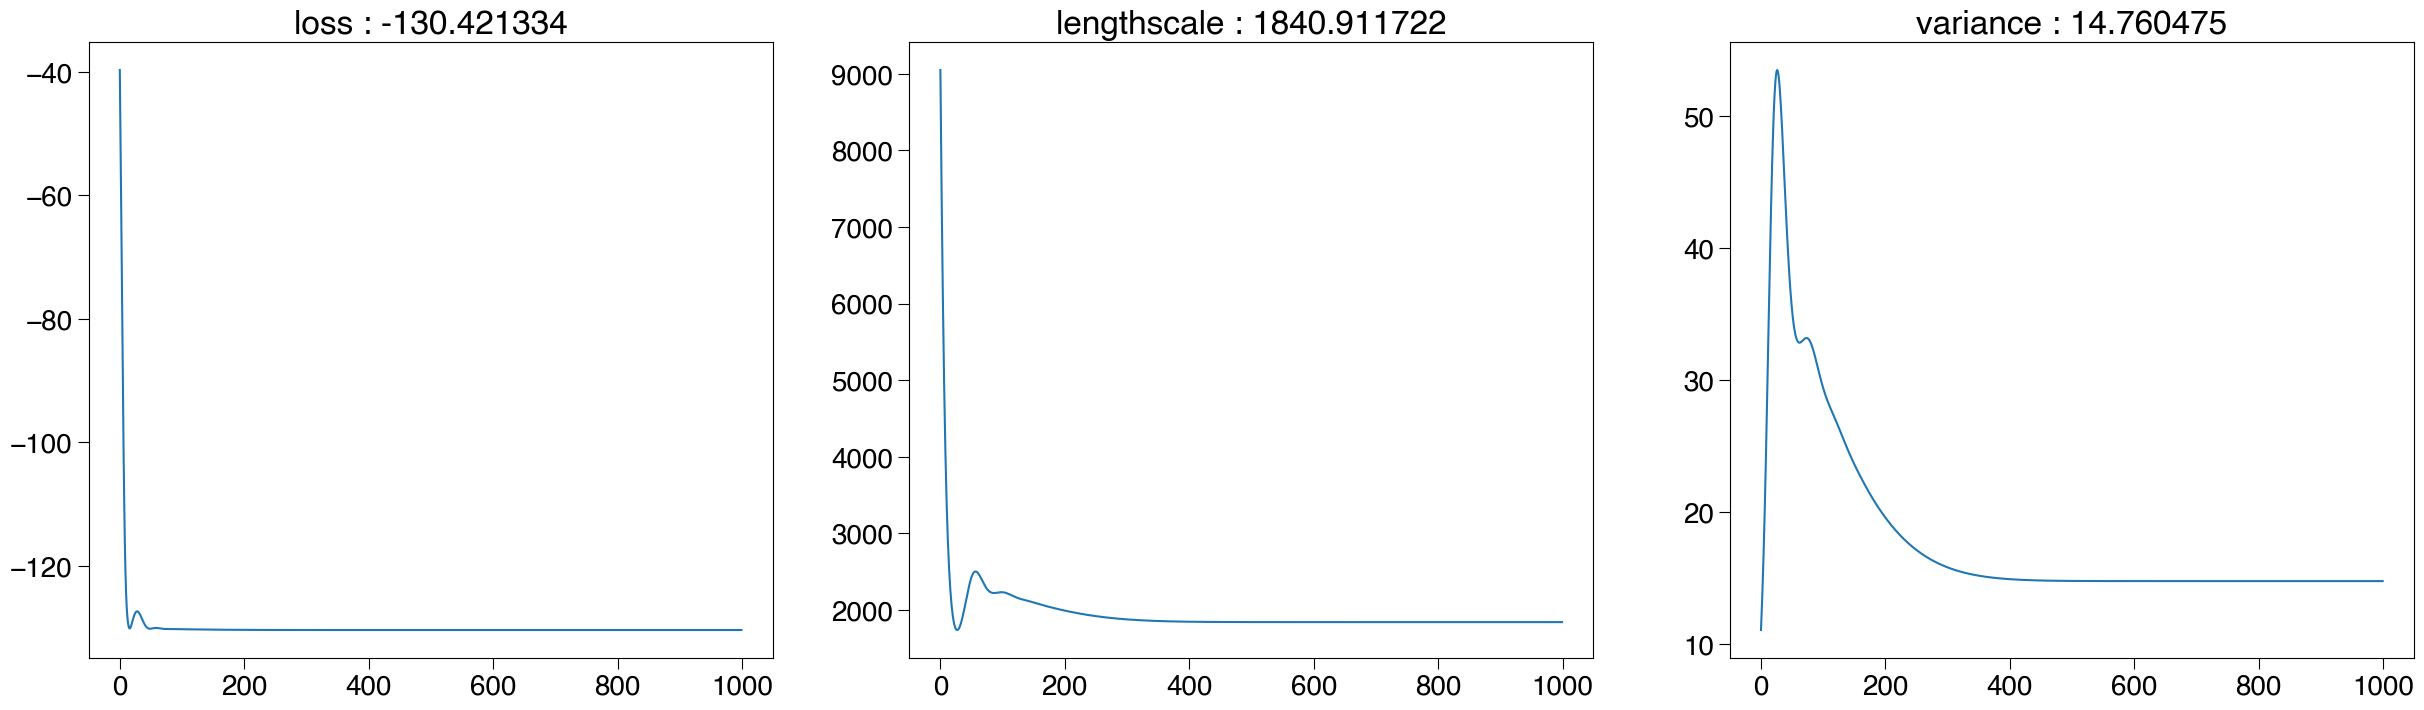

In [30]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a Matern52 kernel 
Matern52_kernel = PSTHM.kernels.Matern52(input_dim=1,variance=torch.tensor(10.),lengthscale=torch.tensor(10000.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(X, y, Matern52_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.post.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))
axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

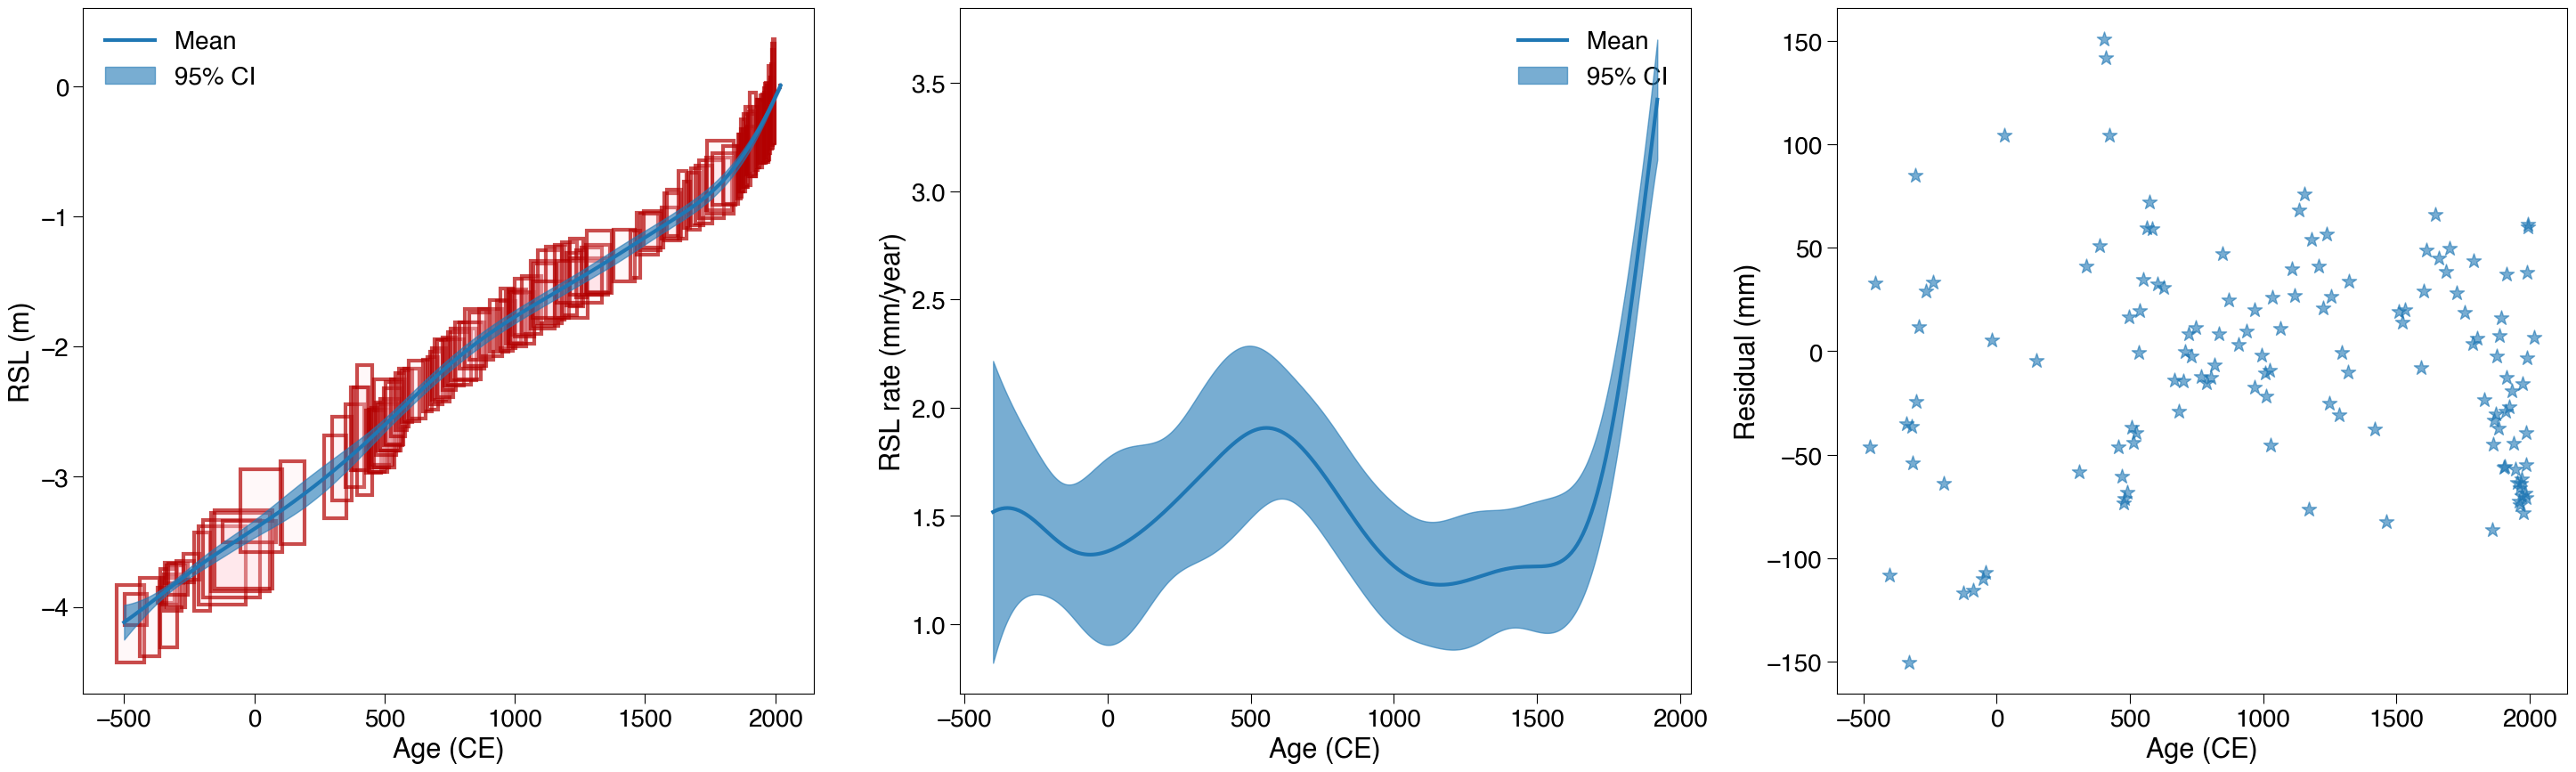

In [31]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.,requires_grad=True)
Matern52_y_mean, Matern52_y_var = gpr(x_test.double(), full_cov=True)
Matern52_sd = torch.diag(Matern52_y_var).sqrt()  # standard deviation at each input point x
rsl_time,Matern52_rsl_rate,Matern52_rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),Matern52_y_var.detach().numpy(),Matern52_y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,Matern52_y_mean,Matern52_sd,
                          rsl_time,Matern52_rsl_rate,Matern52_rsl_rate_sd)


**1.4 Linear Kernel**

Unlike stationary kernels above, linear kernel is a non-stationary kernel allows the covariance structure to vary across different regions of the input space. It therefore can capture varying patterns and trends in the data. A linear kernel can be written as:
$$
k_{Linear}(t,t') = \sigma^2(\text{bias} + t \cdot t')
$$
where $\sigma$ is a hyperparameter that determines the rate of this linear model. The bias hyperparameter determines the x-coordinate of the point that all the lines in the posterior go though. At this point, the function will have zero variance. Performing GP with a linear kernel is esstential the same as doing Bayesian linear regression.  


  0%|          | 0/1000 [00:00<?, ?it/s]

Log Likelihood 7.036
Execution time: 1.339 s


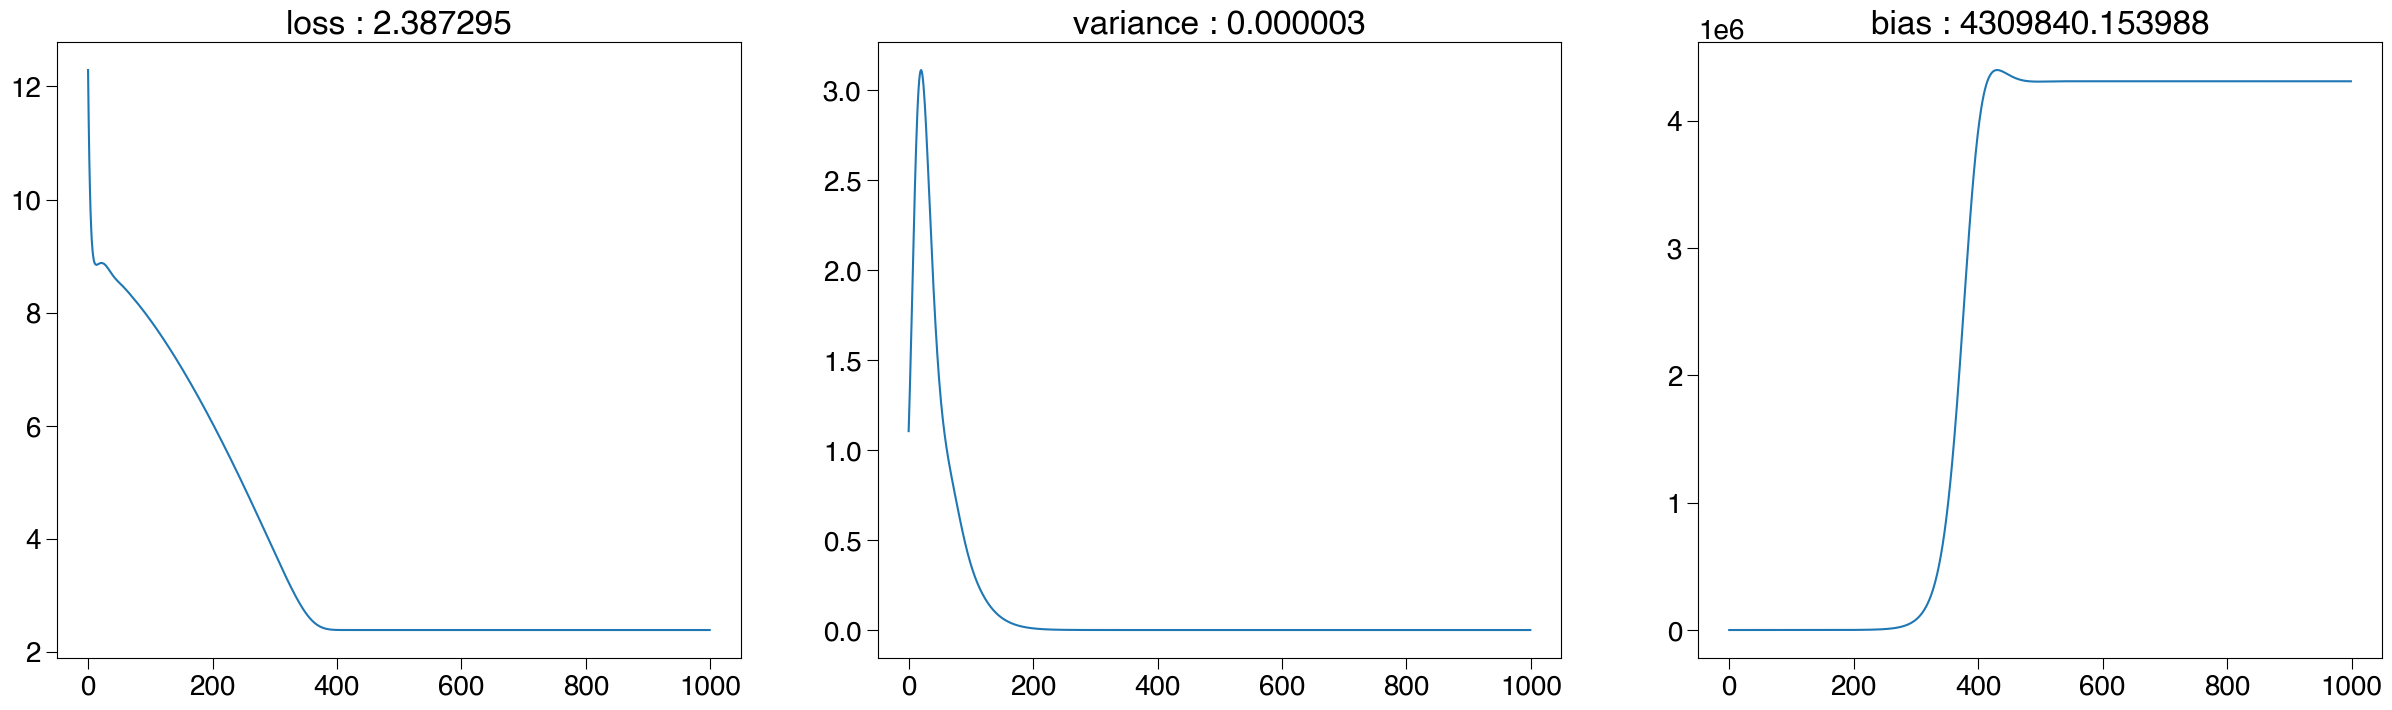

In [32]:
st = time.time() 

pyro.clear_param_store()

#generate a Linear kernel, note degree 1 polynomial kernel is a linear kernel 
Linear_kernel = PSTHM.kernels.Polynomial(input_dim=1,degree=1,bias=torch.tensor(1.),variance=torch.tensor(1.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(X, y, Linear_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=1000)

#predict RSL for each rsl data age 
pred_y,_ = gpr(gpr.X, full_cov=True) 

#calulate log likelihood of the model prediction
fit_likelihood = PSTHM.post.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Log Likelihood {:3.3f}'.format(fit_likelihood))
axes = PSTHM.plotting.plot_track_list(track_list)
et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

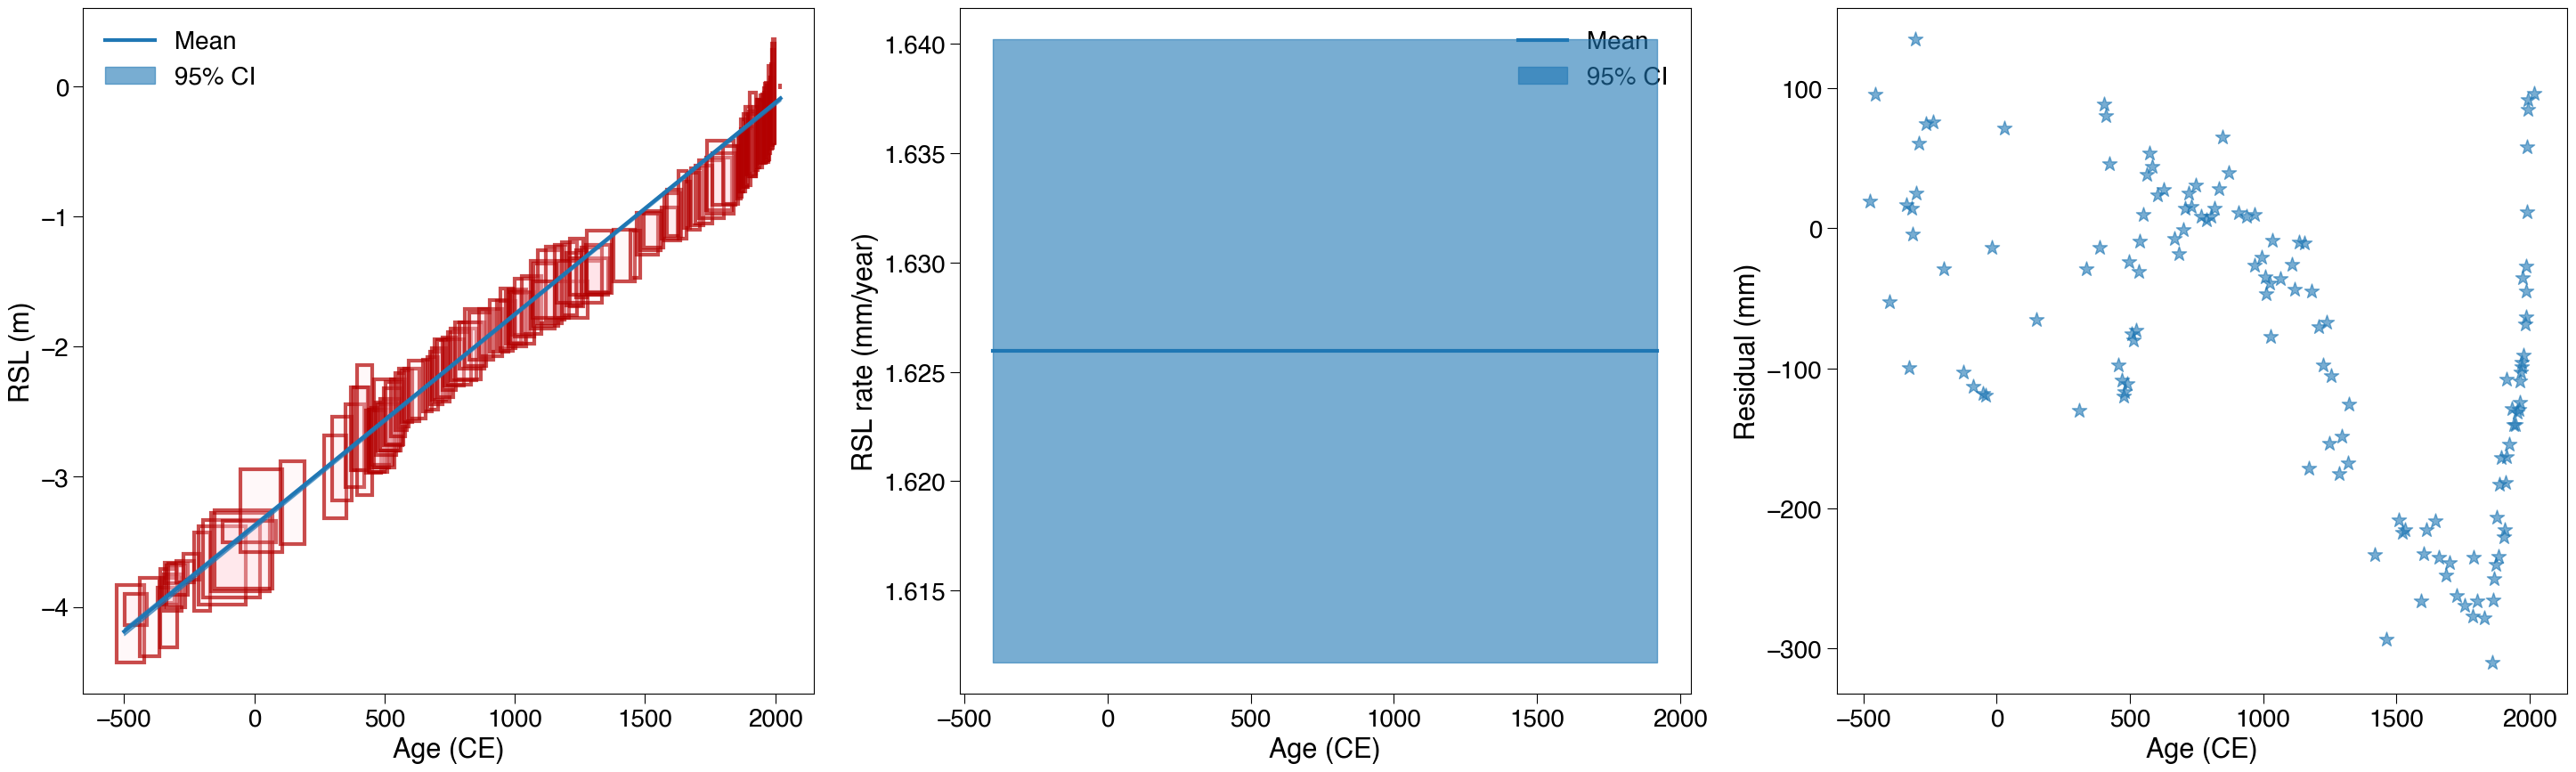

In [33]:
# Make predictions on new inputs
x_test = torch.arange(-500,2025,5.).double()
y_mean, y_var = gpr(x_test, full_cov=True)
sd = torch.diag(y_var).sqrt()  # standard deviation at each input point x
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),y_var.detach().numpy(),y_mean.detach().numpy())

axes = PSTHM.plotting.plot_tem_regression(X,y,x_sigma,y_sigma,x_test,y_mean,sd,
                          rsl_time,rsl_rate,rsl_rate_sd)


**1.5 Periodic Kernel**

Ok, up to now we are working for long-term sea-level change data across thousands of years, but if we work for short-term sea-level data with hourly resolution, we might expect the tide to go up and down. In other words, it has some periodicity we want to capture and we want to see those periodicity even for future when we do not observations. This is when Periodic Kernel becomes useful:
$$
k_{Periodic}(t,t')=\sigma^2\exp\left(-2\times\frac{\sin^2(\pi(t,t')/p)}{l^2}\right)
$$
As above, $\sigma$ here is an amplitude hyperparameter and $l$ is a length scale hyperparameter and $p$ is a periodicity parameter which controls the output periodicity. To better illustrate this kernel, we use a synthetic sine wave data.

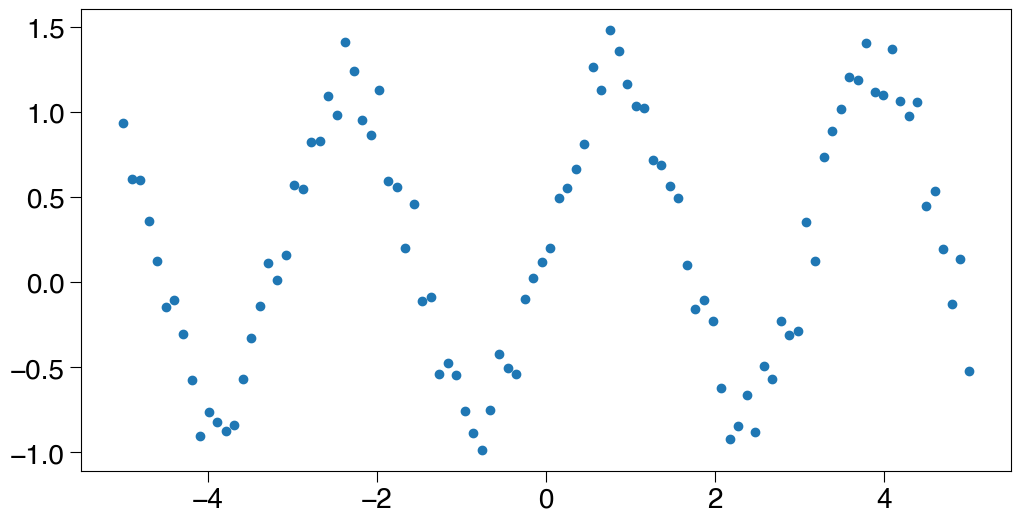

In [34]:
#generate synthetic data
syn_X = torch.linspace(-5, 5, 100)
syn_y = torch.sin(syn_X *2)+torch.rand_like(syn_X) * 0.5
plt.scatter(syn_X, syn_y)
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

Execution time: 3.061 s


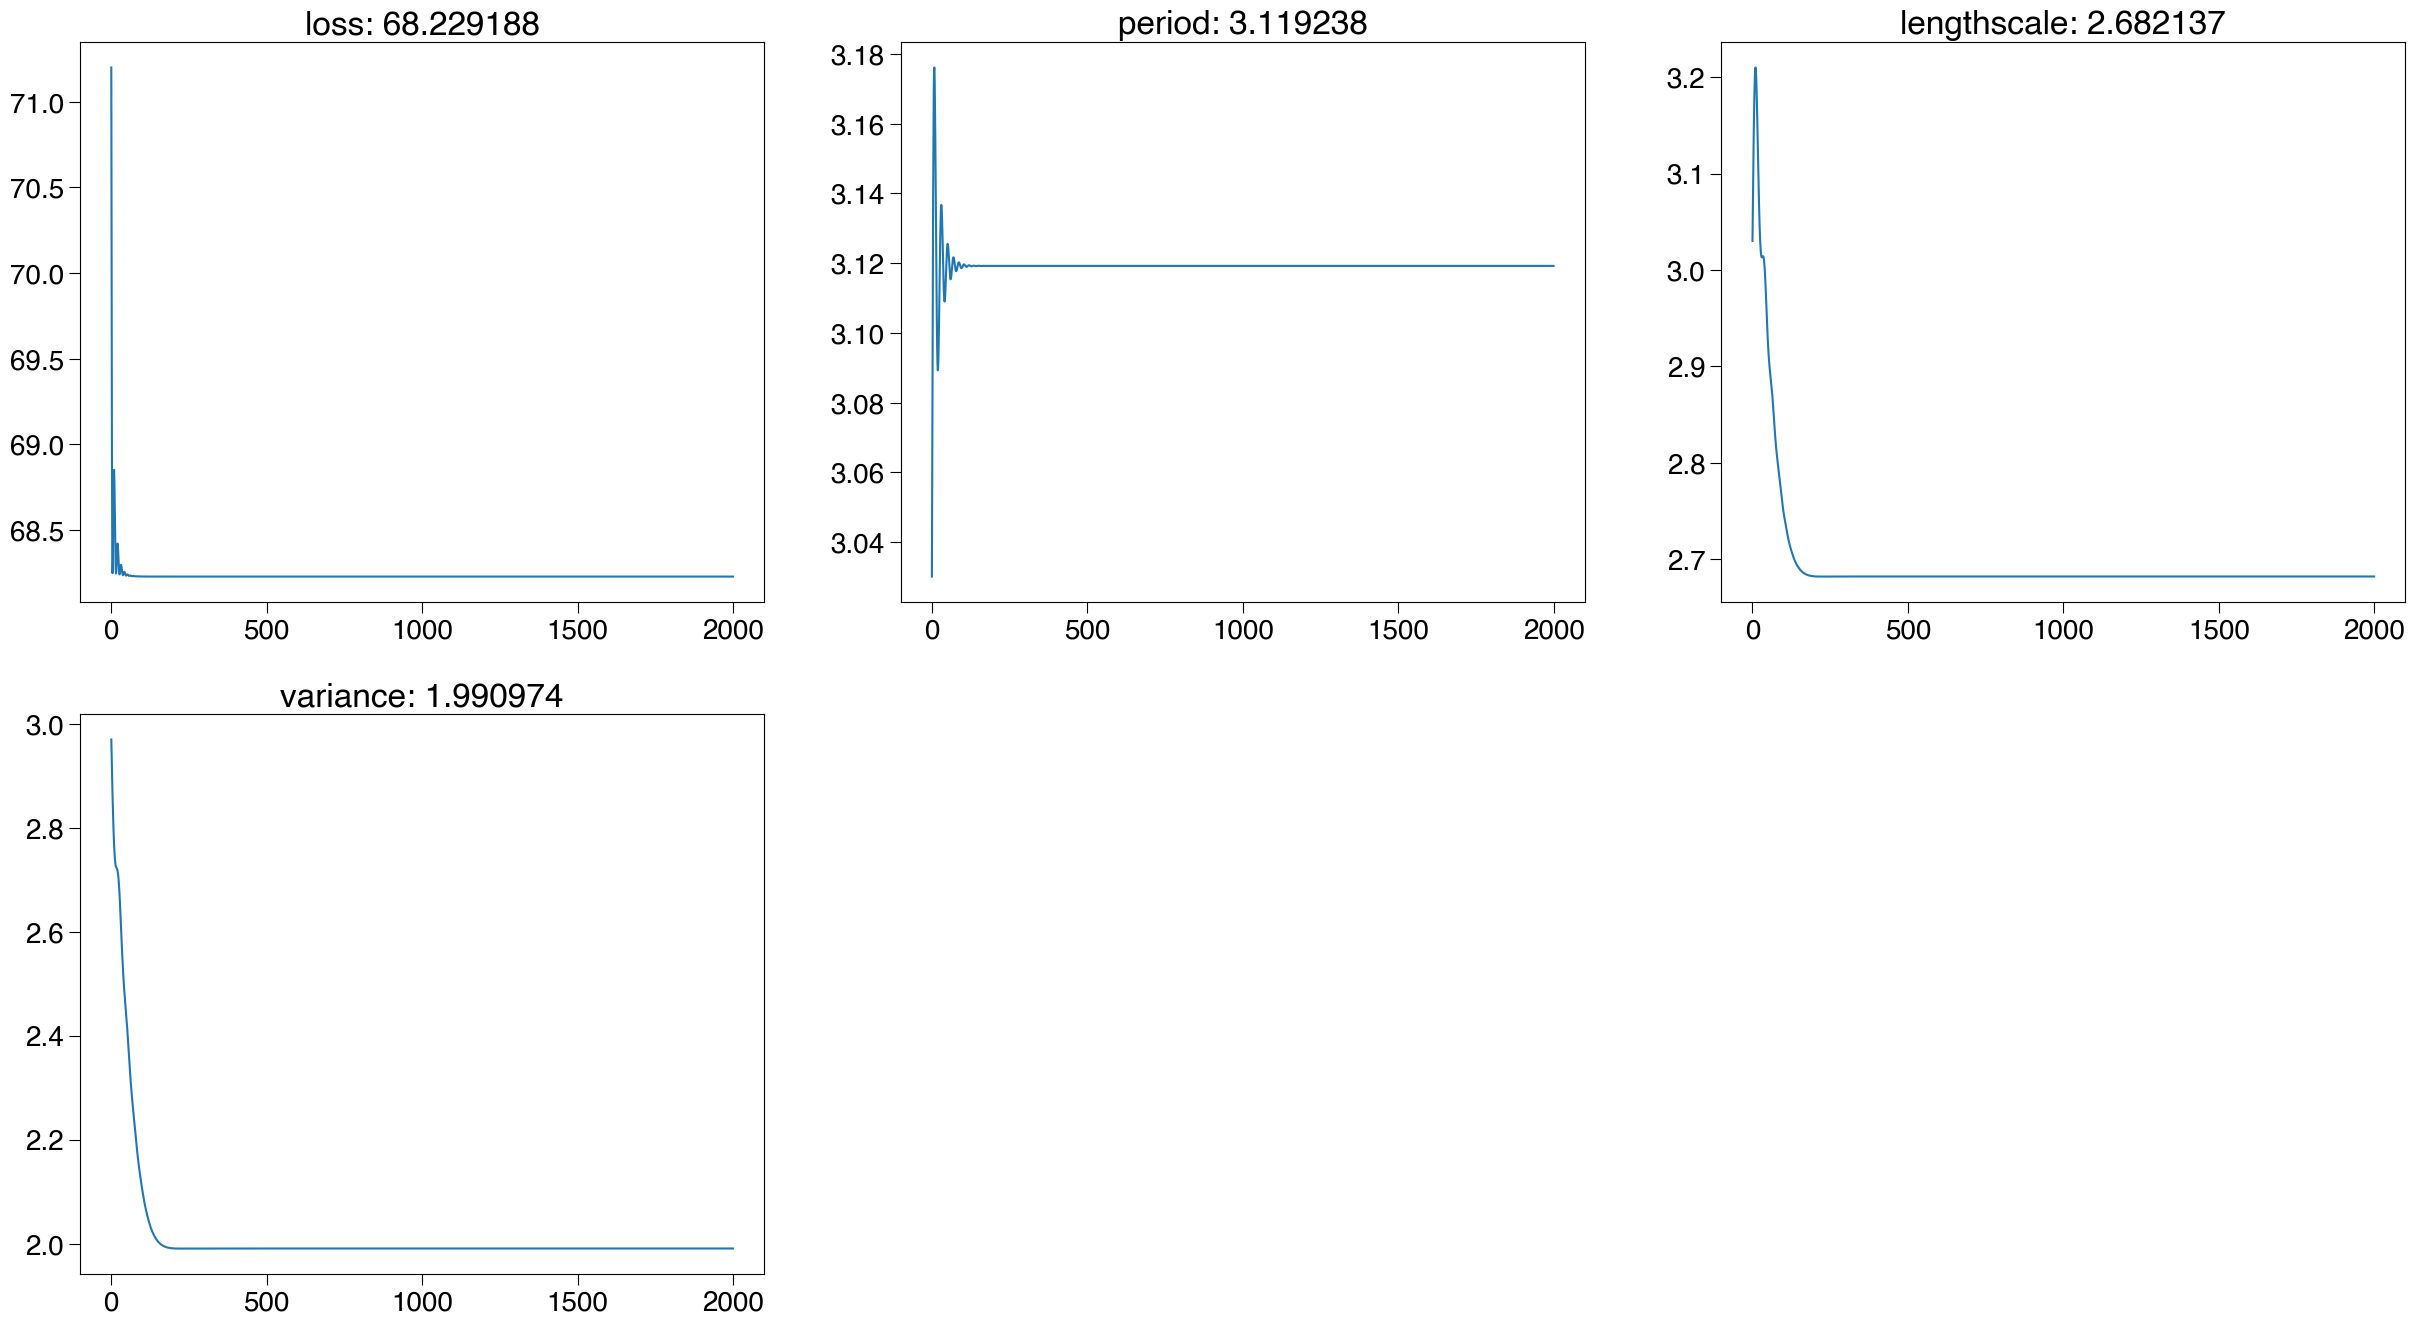

In [35]:
# calculate computational time
st = time.time() 

pyro.clear_param_store()

#generate a Matern52 kernel 
P_kernel = PSTHM.kernels.Periodic(input_dim=1,variance=torch.tensor(3.),lengthscale=torch.tensor(3.),period=torch.tensor(3.))

#generate a GP gression model conditioned on RSL data
gpr = PSTHM.model.GPRegression_V(syn_X, syn_y, P_kernel,noise=torch.ones(len(syn_X))*0.5,jitter=1e-5)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=2000,lr=0.01)

axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

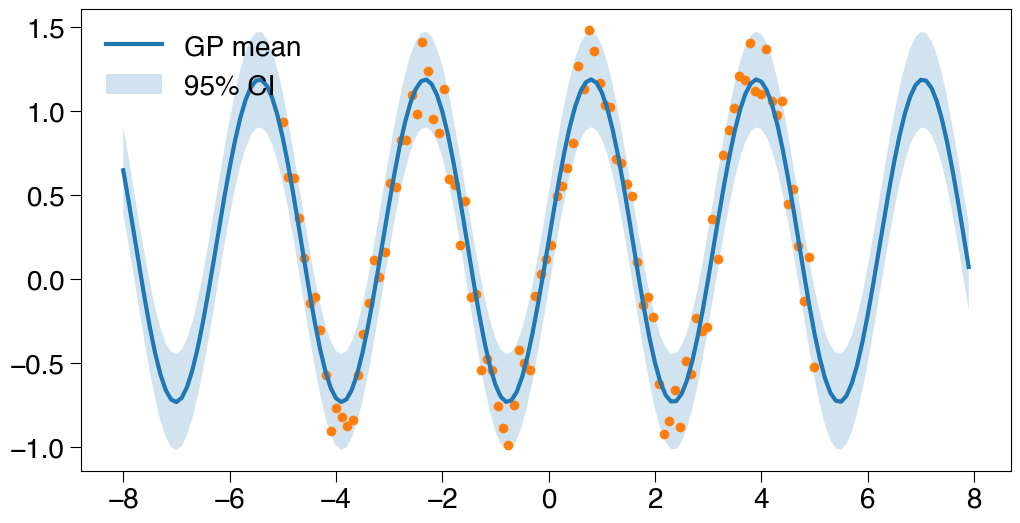

In [36]:
# Make predictions on new inputs
x_test = torch.arange(-8,8,0.1,requires_grad=True)
P_y_mean, P_y_var = gpr(x_test.double(), full_cov=True)
P_sd = torch.diag(P_y_var).sqrt()  # standard deviation at each input point x
rsl_time,P_rsl_rate,P_rsl_rate_sd = PSTHM.post.cal_rate_var(x_test.detach().numpy(),P_y_var.detach().numpy(),P_y_mean.detach().numpy()
                                                       ,difftimestep=1)

plt.plot(x_test.detach().numpy(),P_y_mean.detach().numpy(),lw=3,label='GP mean ')
plt.fill_between(x_test.detach().numpy(),P_y_mean.detach().numpy()-2*P_sd.detach().numpy(),
                    P_y_mean.detach().numpy()+2*P_sd.detach().numpy(),alpha=0.2,label='95% CI')
plt.scatter(syn_X, syn_y)
plt.legend()
plt.show()

**2. Combining different GP kernels**


For environmental problems, there are many cases where a single kernel cannot capture all underlying physical processes. For example, if we look real-world yearly local sea-level data, we should see more than more physical processes including seasonal variability, long-term global sea-level rise and some local noisy signal due to sediment compaction or anthropogenic operations like groundwater extraction. 

**2.1 Summing two kernels**

Here's how combining different GP kernels work. We know that GP is controlled by mean and covariance function, and if we assume a 0 mean function, it only controls by the covariance function. But instead of using only one covariance function, we can use multiple, for example, we can sum two kernels into to get a combined kernel with combined property of each kernel
$$
k_{Combined}(t,t') = k_{Periodic}(t,t') + k_{Linear}(t,t')

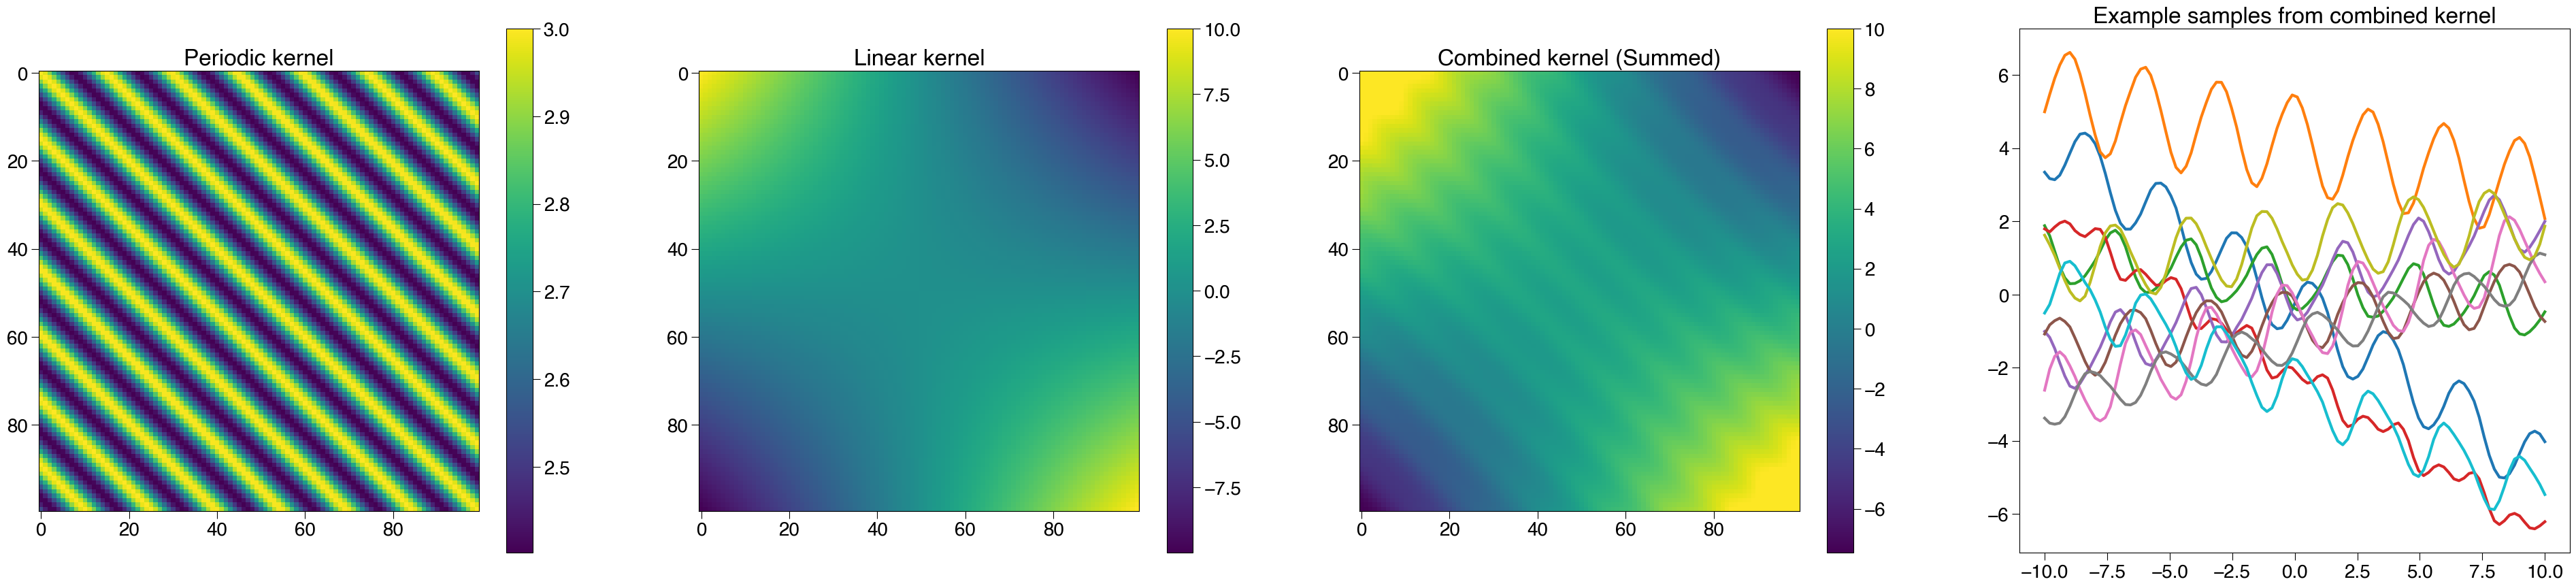

In [37]:
pyro.clear_param_store()
#build a periodic kernel
P_kernel = PSTHM.kernels.Periodic(input_dim=1,variance=torch.tensor(3.),lengthscale=torch.tensor(3.),period=torch.tensor(3.))
#build a linear kernel 
Linear_kernel = PSTHM.kernels.Polynomial(input_dim=1,degree=1,bias=torch.tensor(0),variance=torch.tensor(0.1))
# Linear_kernel.variance = 0.1
#combine kernels
Combined_kernel = PSTHM.kernels.Sum(Linear_kernel,P_kernel)

#calculate the covariance matrix
test_x = torch.linspace(-10,10,100)
P = P_kernel(test_x).detach().numpy()
L = Linear_kernel(test_x).detach().numpy()
K = Combined_kernel(test_x)

#draw samples from combined kernel 

#draw sample from a multivariate normal distribution using covariance matrix above
#add a small number to the diagonal of the covariance matrix to make it positive definite
K += + (torch.ones(len(test_x))*1e-4).diag() 
samples = dist.MultivariateNormal(
            torch.zeros(len(test_x)), covariance_matrix=K
        ).sample(sample_shape=(10,))

plt.figure(figsize=(48,10))

plt.subplot(1,4,1)
plt.imshow(P)
plt.title('Periodic kernel')
plt.colorbar()

plt.subplot(1,4,2)
plt.imshow(L,vmax=10)
plt.title('Linear kernel')
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(K.detach().numpy(),vmax=10)
plt.title('Combined kernel (Summed)')
plt.colorbar()
plt.subplot(1,4,4)
for i in range(10):
    plt.plot(test_x,samples[i,:].detach().numpy(),lw=3)
plt.title('Example samples from combined kernel');

**2.2 Multiplying two kernels**

Other than summing two kernels together, we can multiply two kernels for a new combined kernel. This is very important for spatio-temporal GP which we will cover in next tutorial series. This process can be written as:
$$
k_{Combined_2}(t,t') = k_{Periodic}(t,t') \cdot k_{Linear}(t,t')
$$
where '$\cdot$' indicates element wise multiplication instead of matrix multiplication. 


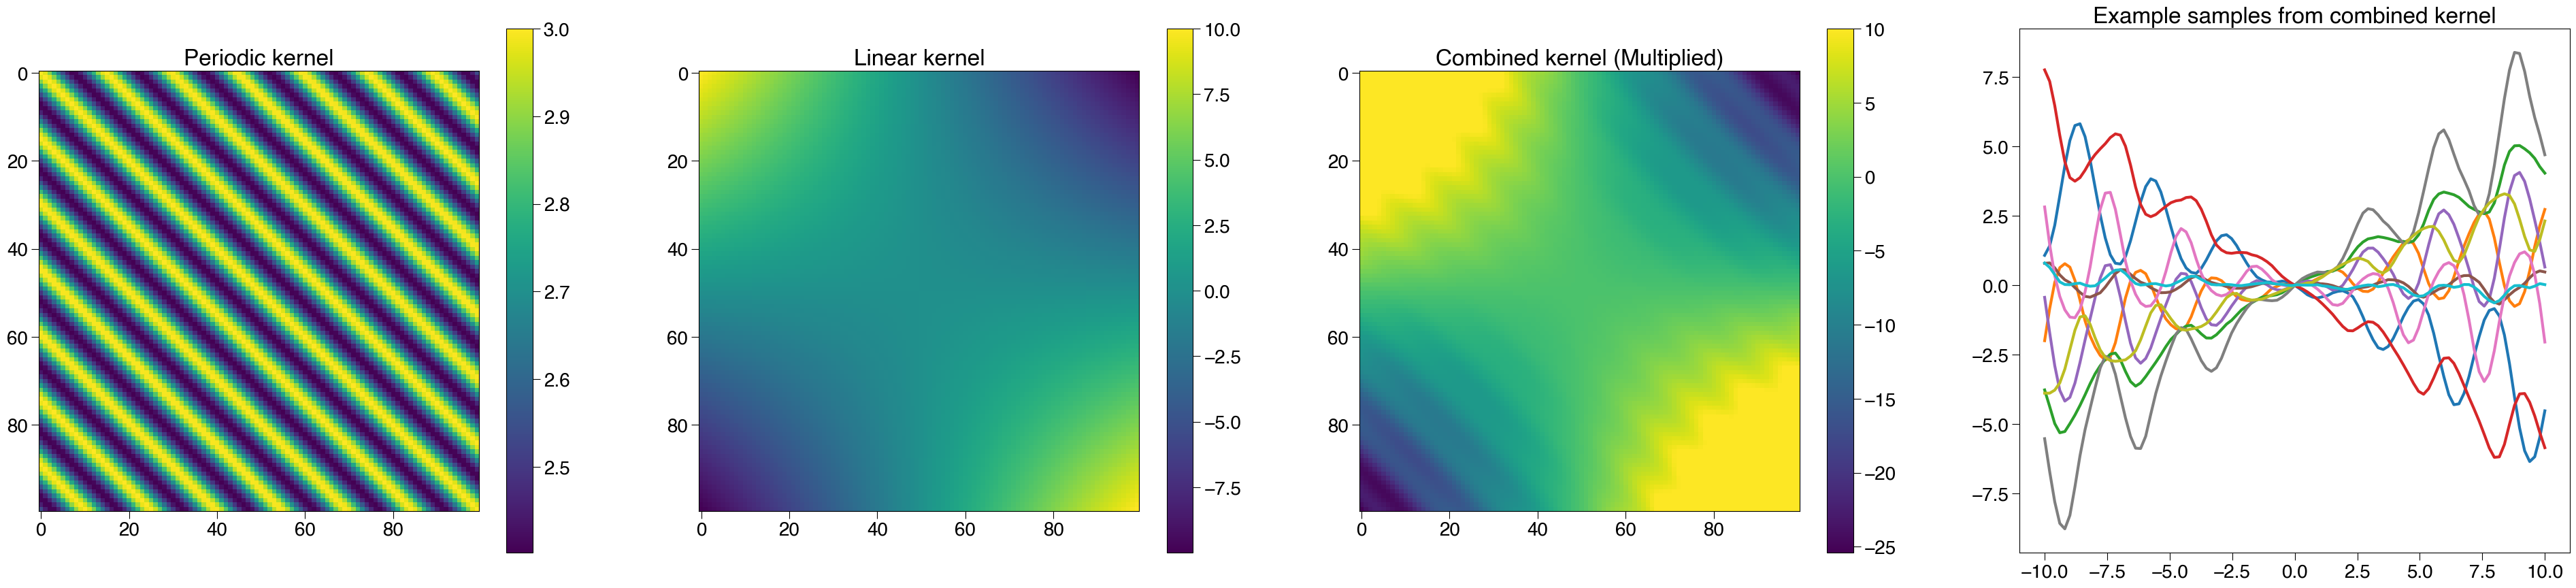

In [38]:
pyro.clear_param_store()
#build a periodic kernel
P_kernel = PSTHM.kernels.Periodic(input_dim=1,variance=torch.tensor(3.),lengthscale=torch.tensor(3.),period=torch.tensor(3.))
#build a linear kernel 
Linear_kernel = PSTHM.kernels.Polynomial(input_dim=1,degree=1,bias=torch.tensor(0),variance=torch.tensor(0.1))
#combine kernels
Combined_kernel2 = PSTHM.kernels.Product(Linear_kernel,P_kernel)

#calculate the covariance matrix
test_x = torch.linspace(-10,10,100)
P = P_kernel(test_x).detach().numpy()
L = Linear_kernel(test_x).detach().numpy()
K2 = Combined_kernel2(test_x)

#draw samples from combined kernel 

#draw sample from a multivariate normal distribution using covariance matrix above
#add a small number to the diagonal of the covariance matrix to make it positive definite
K2 += + (torch.ones(len(test_x))*1e-4).diag() 
samples2 = dist.MultivariateNormal(
            torch.zeros(len(test_x)), covariance_matrix=K2
        ).sample(sample_shape=(10,))

plt.figure(figsize=(48,10))

plt.subplot(1,4,1)
plt.imshow(P)
plt.title('Periodic kernel')
plt.colorbar()

plt.subplot(1,4,2)
plt.imshow(L,vmax=10)
plt.title('Linear kernel')
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(K2.detach().numpy(),vmax=10)
plt.title('Combined kernel (Multiplied)')
plt.colorbar()

plt.subplot(1,4,4)
for i in range(10):
    plt.plot(test_x,samples2[i,:].detach().numpy(),lw=3)
plt.title('Example samples from combined kernel');

**3. Modelling real-world example of CO2 concentration**

Let's test what we have learned so far by modelling real-world CO2 concentration data from [Mauna Loa Observatory](https://gml.noaa.gov/ccgg/trends/data.html). Let's check the data.

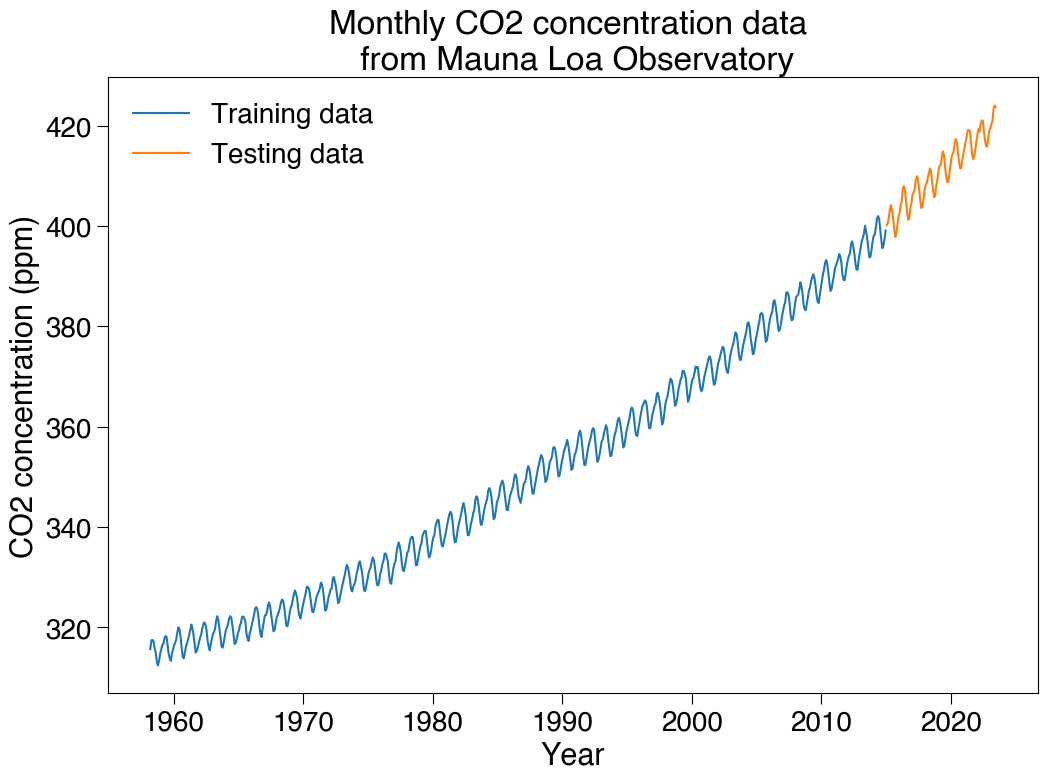

In [39]:
CO2_data = pd.read_csv('../2.Temporal_GP/Data/co2_mm_mlo.csv',header=None)
CO2_X = torch.tensor(CO2_data.iloc[:,0].values)
CO2_y = torch.tensor(CO2_data.iloc[:,1].values)
test_year = 2015
train_X = CO2_X[CO2_X<test_year]
train_y = CO2_y[CO2_X<test_year]
test_X = CO2_X[CO2_X>=test_year]
test_y = CO2_y[CO2_X>=test_year]
plt.figure(figsize=(12,8))
plt.plot(train_X,train_y,label='Training data')
plt.plot(test_X,test_y,label='Testing data')
plt.legend()
plt.xlabel('Year')
plt.ylabel('CO2 concentration (ppm)')
plt.title('Monthly CO2 concentration data \n from Mauna Loa Observatory');

You can see that we have monthly atmospheric CO2 concentration data from 1958 to 2023. To make it more interesting, we will use data from 1958 to 2015 to train the GP model (i.e., training data) and then use data from 2015 to 2023 to see whether this model can predict the CO2 variation between 2015 and 2023 without seeing the data (i.e., testing data). 

**Kernel design**

To design the kernel to use with our Gaussian process, we can make some assumption regarding the data at hand. We observe that they have several characteristics: we see a long term rising trend, a seasonal variation and some smaller irregularities. We can use different appropriate kernel that would capture these features:

1. Long-term trend: 52 Matérn kernel. We can represent the long term trend by a 52 Matérn kernel since we can expect which to be relatively smooth. 

1. Seasonal variability: Periodic kernel. A periodic kernel is used to reflect the seasonal trend.

1. Small irregularities: Whitenoise kernel, which can be written as :$k_{Whitenoise}(t,t') = \sigma^2 \delta(t,t')$, where $\delta$ is a Dirac delta function and $\sigma$ is an amplitude hyperparameter. It can add some identically distributed noise to capture small irregularities. 

To combine them, we multiply long-term trend with seasonal variability and add which with whitenoise kernel.

One last thing to bear in mind is that, we can set prior distribution to our kernel parameters in order to reflect our prior knowledge to the fianl results. In this case, we can set a informative prior to the periodcity parameter as we know the seasonal trend should have roughly 1-year period. And for the others, we can use non-informative prior to let the data to constrain the model for us.

  0%|          | 0/500 [00:00<?, ?it/s]

Execution time: 12.942 s


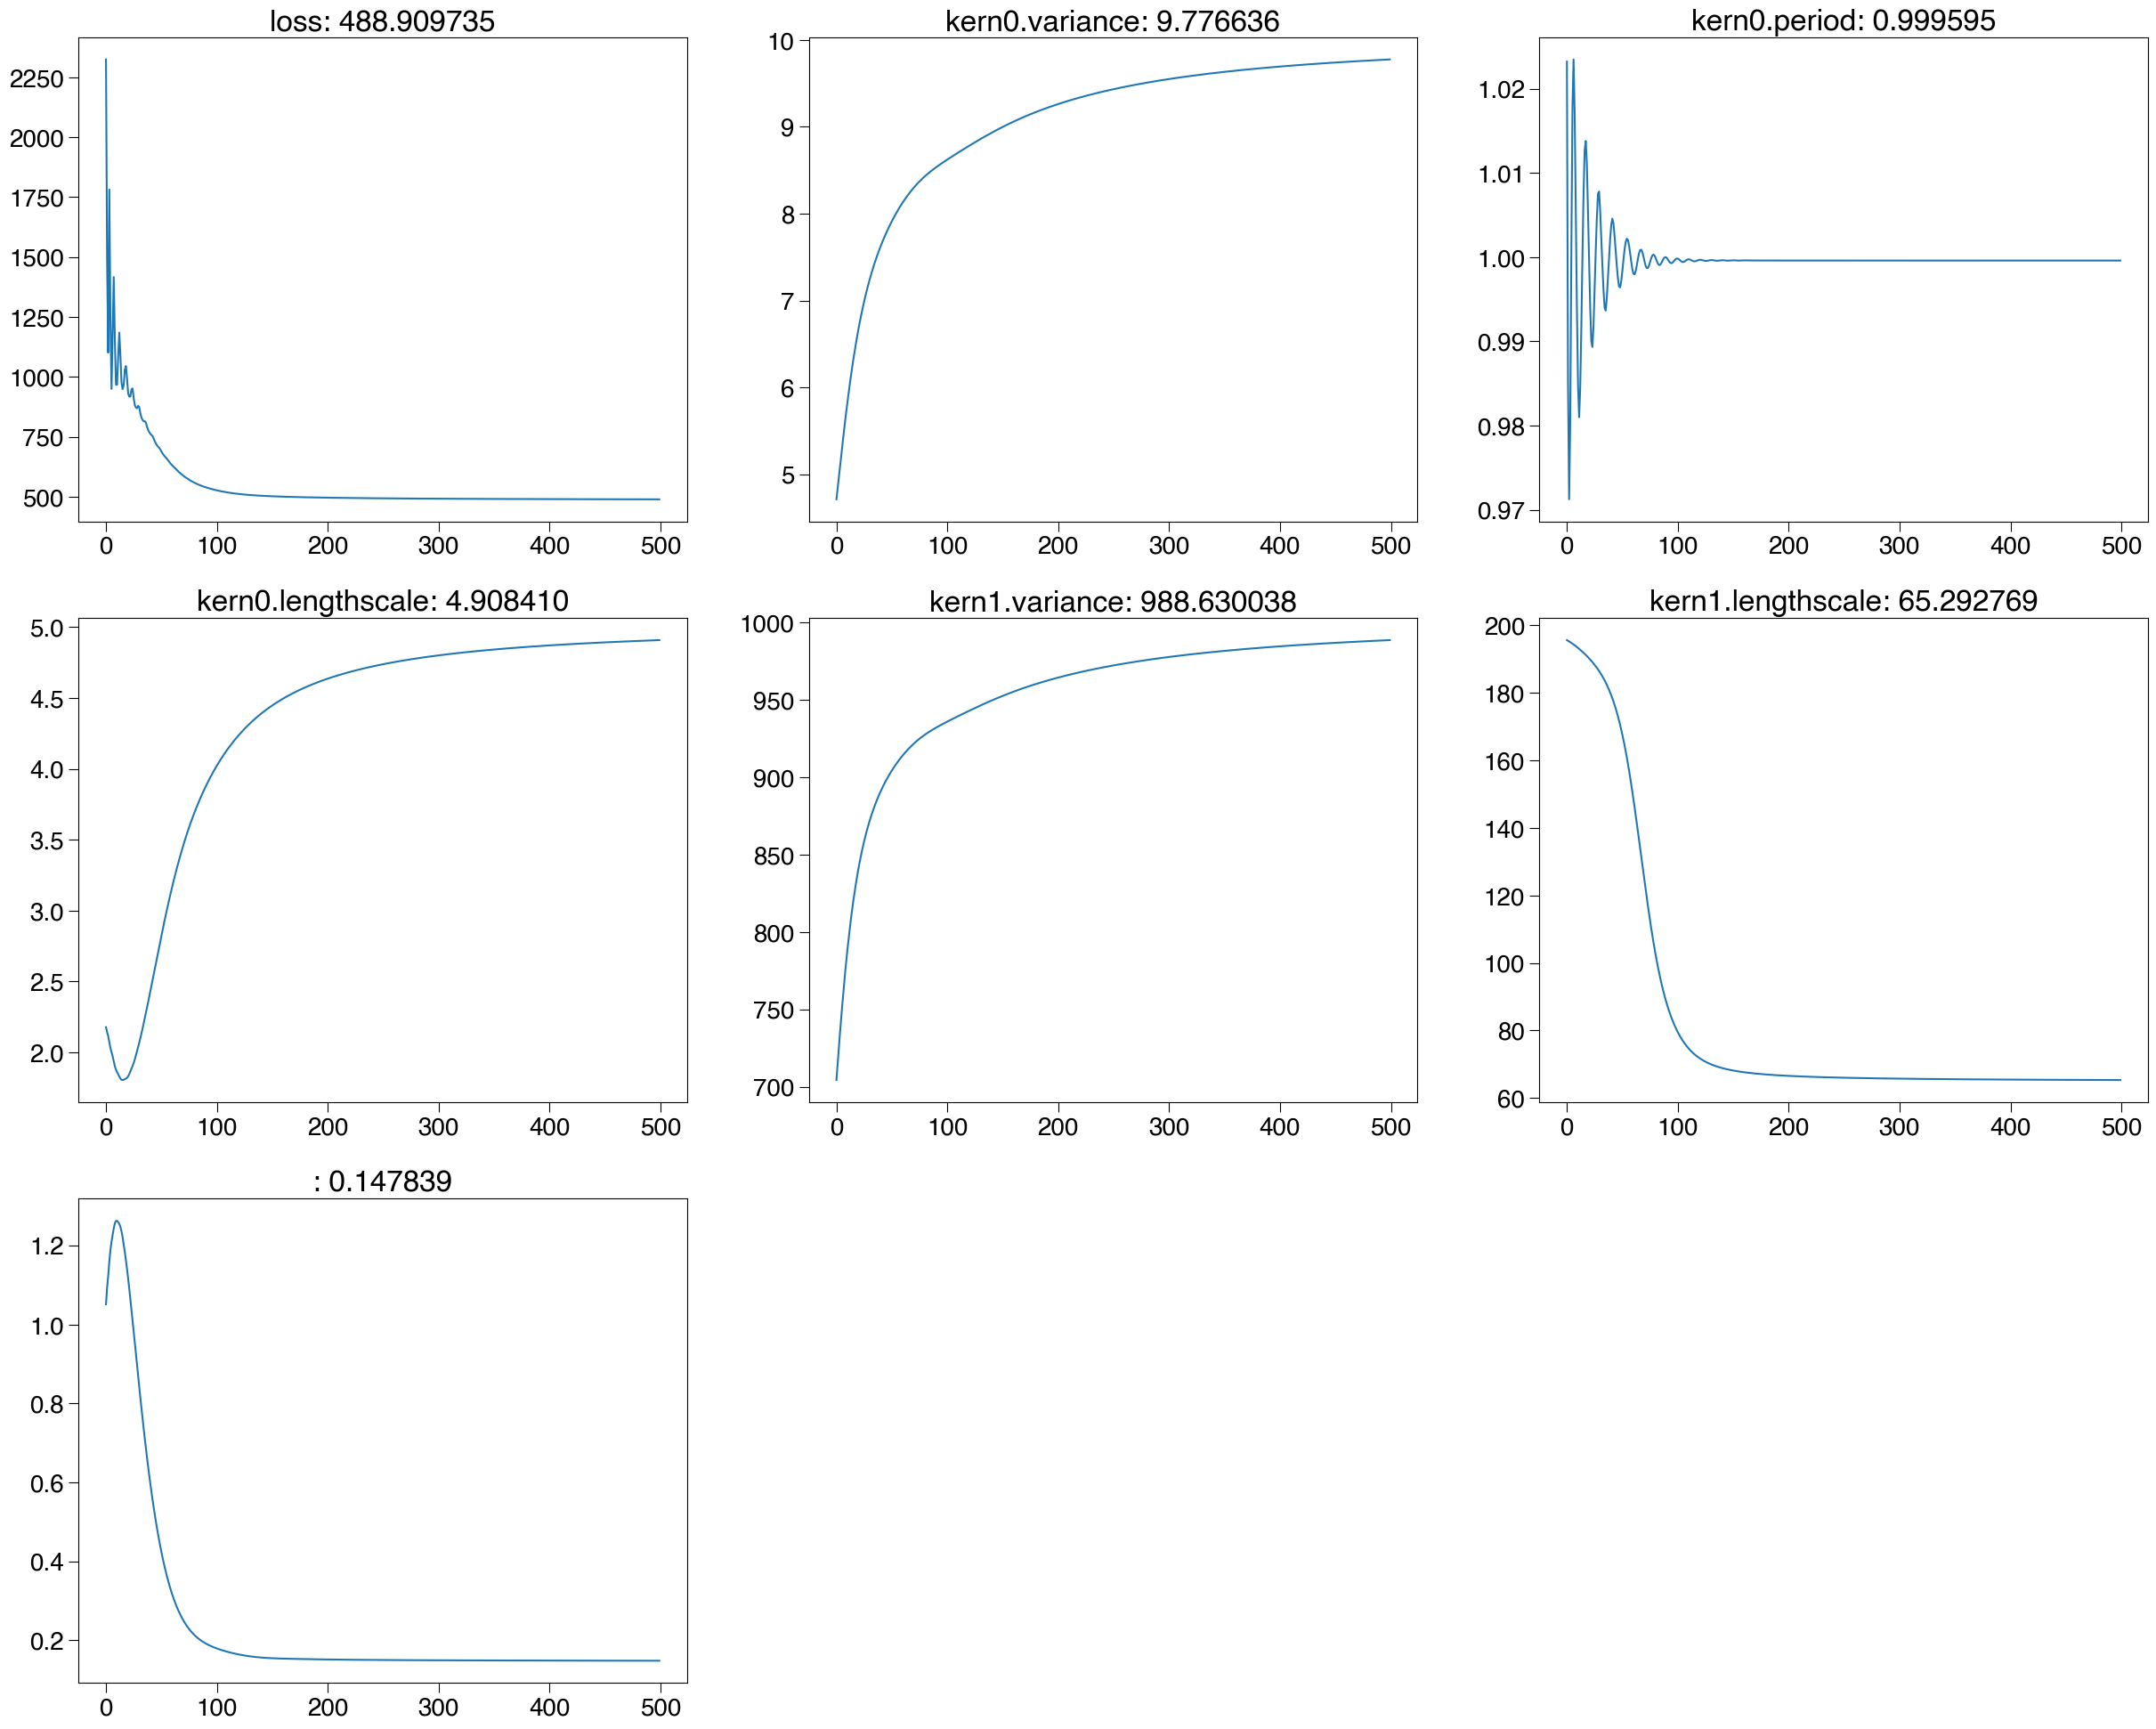

In [40]:
torch.manual_seed(10)

st = time.time() 

pyro.clear_param_store()

#create a periodic kernel
P_kernel = PSTHM.kernels.Periodic(input_dim=1)
P_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.01),torch.tensor(10.)))
P_kernel.set_prior("period", dist.Normal(torch.tensor(1.),torch.tensor(0.05)))
P_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(0.1),torch.tensor(5.)))

M52_kernel = PSTHM.kernels.Matern52(input_dim=1,lengthscale=torch.tensor(1.),variance=torch.tensor(1.))
M52_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.01),torch.tensor(1000.)))
M52_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(65.),torch.tensor(200.)))

combined_kernel = PSTHM.kernels.Product(P_kernel,M52_kernel)

gpr = PSTHM.model.GPRegression_V(train_X, train_y, combined_kernel,jitter=1e-5)

#Empirical bayes optimization 
gpr,track_list = PSTHM.opti.SVI_optm(gpr,num_iteration=500,lr=0.05)

PSTHM.plotting.plot_track_list(track_list)
et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

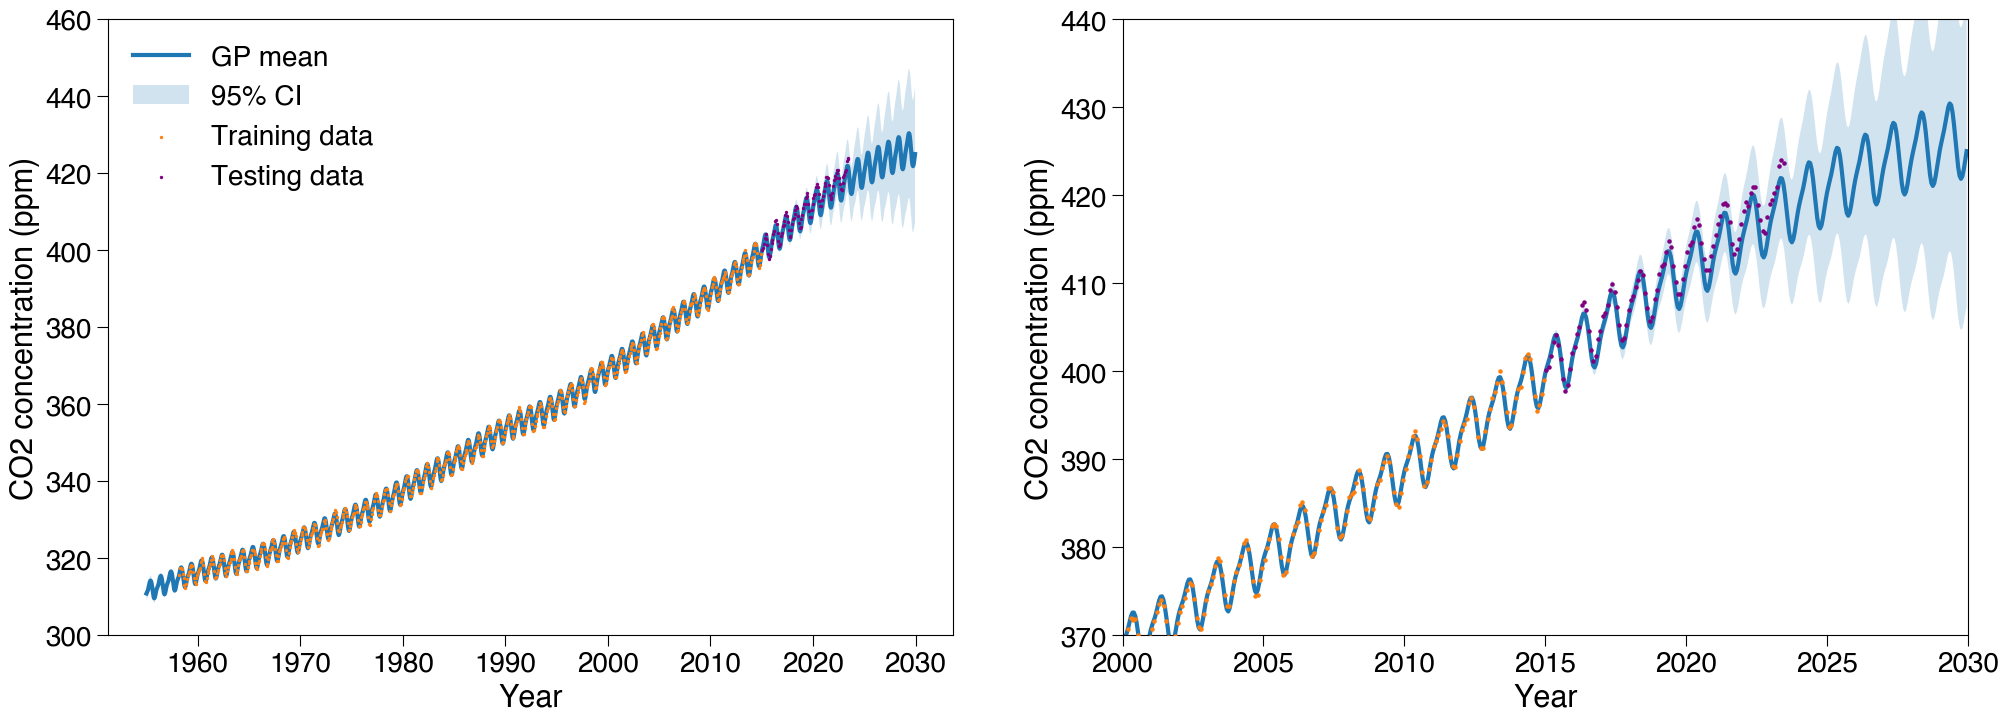

In [41]:
test_x = torch.arange(1955,2030,0.05).double()
CO2mean,CO2cov = gpr(test_x, full_cov=True)
CO2_sd = torch.diag(CO2cov).sqrt()
plt.figure(figsize=(24,8))
plt.subplot(121)
plt.plot(test_x.detach().numpy(),CO2mean.detach().numpy(),lw=3,label='GP mean ')
plt.fill_between(test_x.detach().numpy(),CO2mean.detach().numpy()-2*CO2_sd.detach().numpy(),
                    CO2mean.detach().numpy()+2*CO2_sd.detach().numpy(),alpha=0.2,label='95% CI')
plt.scatter(train_X,train_y,zorder=10,s=2,label='Training data')
plt.scatter(test_X,test_y,zorder=10,s=2,label='Testing data',color='purple')
plt.legend()
plt.ylim(300,460)
plt.xlabel('Year')
plt.ylabel('CO2 concentration (ppm)');
plt.subplot(122)
plt.plot(test_x.detach().numpy(),CO2mean.detach().numpy(),lw=3,label='GP mean ')
plt.fill_between(test_x.detach().numpy(),CO2mean.detach().numpy()-2*CO2_sd.detach().numpy(),
                    CO2mean.detach().numpy()+2*CO2_sd.detach().numpy(),alpha=0.2,label='95% CI')
plt.scatter(train_X,train_y,zorder=10,s=5,label='Training data')
plt.scatter(test_X,test_y,zorder=10,s=5,label='Testing data',color='purple')
plt.ylim(370,440)
plt.xlim(2000,2030)
plt.xlabel('Year')
plt.ylabel('CO2 concentration (ppm)');

You can see that our GP model does a fairly good job in modelling the CO2 trend after 2015, although the confidence interval seems a bit too high, which can be fine-tuned with hyperparameter prior distributions and kernel design. If you are interested in modelling CO2 with more advanced GP kernel design, you can check this [tutorial](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/GP-MaunaLoa.htmll). 


